参考: 

https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification

https://www.kaggle.com/code/werus23/g2net-pytorch-with-generated-data

In [1]:
# たまにgpu取れないときあるので取れないときは終わらせる
import torch
if torch.cuda.is_available() == False:
    raise Exception

In [2]:
!nvidia-smi

Sat Dec 24 18:52:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   44C    P0    40W / 300W |      3MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# papermill parameters
cfg_optimizer = "adamw" # "sam"
device_ids = [0]
epochs = 15
gradient_accumulation_steps = 1
is_syncBN = False

#lr = 5e-3  # 高すぎるみたい
lr = 4e-4

warmup_t = 3
#warmup_t = 1

min_lr_ratio = 1e-2

weight_decay = 1e-5  # 1e-6にしてもほぼ変わらない
#weight_decay = 1e-6

is_wandb = True
is_wandb = False
n_seeds = 1
cfg_seeds = [0]

cfg_apex = True
#cfg_apex = False  # ampなしにしても変わらず

#BATCH_SIZE = 2
#BATCH_SIZE = 8  # 8にしても16と変わらず学習遅くなるだけ
BATCH_SIZE = 16
#BATCH_SIZE = 32  # 32以降ぐらいからbatch上げるとepochごとのスコア安定しない
#BATCH_SIZE = 64
#BATCH_SIZE = 128
#BATCH_SIZE = 384

load_model_path = "none"
#load_model_path = "/volume/kaggle/g2net2/output/tmp/tmp_fold0_seed0_best_score.pth"
#model_cls = "CustomModel"
#model_cls = "CustomModelDrop"
model_cls = "CustomModelMultiOutput"
#model_cls = "CustomModelMultiInput"
#model_cls = "CustomModelLargeKernel"

# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook
cfg_drop_rate = 0.4
cfg_drop_path_rate = 0.2

#MODEL_NAME = ""
MODEL_NAME = "mobilenetv3_small_050"
#MODEL_NAME = "tf_efficientnetv2_b1"
#MODEL_NAME = "tf_efficientnet_b4_ap"
#MODEL_NAME = "tf_efficientnet_b5_ns"
#MODEL_NAME = "tf_efficientnet_b7_ns"
#MODEL_NAME = "seresnext101d_32x8d"
cfg_pretrained = True

n_fold = 5
#trn_fold = [0,1,2,3,4]
#is_trn_allfold = True
trn_fold = [0]
#trn_fold = "[3]"
is_trn_allfold = False

cfg_scheduler = 'CosineLRScheduler'  # warmup
#cfg_scheduler = 'CosineLRScheduler_cycle_limit3'  # warmup

# data params
cfg_ch = 2
#cfg_step = 64
cfg_step = 128
#cfg_step = 256
#cfg_step = 340
#cfg_step = 512
#cfg_step = 5760
cfg_spec_max = 4096
#cfg_spec_max = 4224  # 33 * 128
#cfg_spec_max = 5760

size_h, size_w = 360, cfg_step
#size_h, size_w = 360, 128
#size_h, size_w = 360, 256

# train+test set stat img  https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-img4096
# np.mean(p.reshape(freq, step, spec_max//step), axis=2)直後の統計値
cfg_p_mean = [2.4080, 2.3525]  # [H1, L1]
cfg_p_std = [0.6578, 0.8358]  # [H1, L1]

#normalize_type = "default-norm|ts-ma"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-max"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|ts-ma|p-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel|p-stand|ts-ma"
#normalize_type = "largekernel"

cfg_is_add_ch = False
cfg_is_train_zip_dataset = False
cfg_prob_mixup = 0.0

#cfg_prob_sample_mixup = 0.0
#cfg_prob_sample_mixup = 0.5
cfg_prob_sample_mixup = 0.8

cfg_is_sample_mixup_use_pseudo = True
#cfg_is_sample_mixup_use_pseudo = False

cfg_prob_add_sample_nega_mixup = 0.0
#cfg_prob_add_sample_nega_mixup = 0.5

#cfg_prob_mean_mixup = 0.0
cfg_prob_mean_mixup = 0.3

#cfg_prob_noise_band = 0.0
cfg_prob_noise_band = 0.3

#cfg_prob_noise_spot = 0.0
cfg_prob_noise_spot = 0.05

#cfg_prob_noise_vline = 0.0
cfg_prob_noise_vline = 0.2

#cfg_prob_noise_hband = 0.0
cfg_prob_noise_hband = 0.2
cfg_prob_noise_hband = 0.5

cfg_prob_spec_start_random = 0.0
#cfg_prob_spec_start_random = 0.5

#cfg_prob_swap_ch_nega = 0.0
cfg_prob_swap_ch_nega = 0.5

#cfg_prob_flip_nega = 0.0
cfg_prob_flip_nega = 0.5

#cfg_prob_swap_nega = 0.0
cfg_prob_swap_nega = 0.5

cfg_prob_vshift_nega = 0.0
#cfg_prob_vshift_nega = 0.5

#cfg_prob_vshift = 0.0
cfg_prob_vshift = 1.0

#cfg_freq_mask_num = 0  # マスクする横線
#cfg_time_mask_num = 0  # マスクする縦線
cfg_freq_mask_num = 2
cfg_time_mask_num = 1
cfg_freq_mask_param = 10
cfg_time_mask_param = 10
#cfg_freq_mask_param = 30
#cfg_time_mask_param = 50

cfg_cv_col = "target"
#cfg_cv_col = "freq_min//10"
#cfg_cv_col = "freq_min//10_target"

cfg_add_split_str = ""
#cfg_add_split_str = "KFold"
#cfg_add_split_str = "StratifiedKFold"

cfg_is_npy = True
#cfg_is_npy = False

FCOFF = 1e22
#FCOFF = 5e22

ADD_DIRS_STR = ""
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL, EX004_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL1, EX005_SIGNAL_ISO1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX003_NOISE2, EX004_SIGNAL, EX004_SIGNAL_ISO, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX006_SIGNAL800]"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

IS_ADD_ALL_TRAIN1 = False
#IS_ADD_ALL_TRAIN1 = True


PSEUDO_CSV = ""
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
#cfg_pseudo_max = 0.0  # pseudoの閾値なし
#cfg_pseudo_min = 0.0  # pseudoの閾値なし
#cfg_is_pseudo_hard = True
cfg_is_pseudo_hard = False

cfg_pseudo_type = ""
#cfg_pseudo_type = "real"
#cfg_pseudo_type = "sim"


ADD_PSEUDO_DIRS = ""
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"


cfg_freq_div_n = 10
#cfg_freq_div_n = 50
#cfg_freq_div_n = 100

cfg_pseudo_sim_max = cfg_pseudo_max
cfg_pseudo_sim_min = cfg_pseudo_min
#cfg_pseudo_sim_max = 0.8
#cfg_pseudo_sim_min = 0.4
#cfg_pseudo_sim_max = 0.0
#cfg_pseudo_sim_min = 0.0

cfg_pseudo_real_max = cfg_pseudo_max
cfg_pseudo_real_min = cfg_pseudo_min

is_matplotlib_agg = False
#is_matplotlib_agg = True  # 可視化なしにする

IS_MAKE_SUB = False
#IS_MAKE_SUB = True

#DEBUG = False
DEBUG = True

# ==============================================================
# kqi_3090_ex075_v2 base Parameters
# ==============================================================
add_name = "_pseudo_multioutput_freq_b5_ap_freq_div_n50"
BATCH_SIZE = 64
MODEL_NAME = "tf_efficientnet_b5_ap"
model_cls = "CustomModelMultiOutput"
epochs = 50
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
cfg_apex = True
cfg_step = 128
size_w = 128
cfg_is_sample_mixup_use_pseudo = True
cfg_add_split_str = "StratifiedKFold"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1

cfg_is_pseudo_hard = False
cfg_freq_div_n = 50
IS_ADD_ALL_TRAIN1 = False
IS_MAKE_SUB = True
n_fold = 5
#is_trn_allfold = True
#DEBUG = False
# ==============================================================

# ==============================================================
# kqi_3090_ex075_v2_tta_v3_miximp_hvflip_pseudo_lb0771_1000_simall_100ep Parameters
# ==============================================================
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"
cfg_pseudo_max = 1.0 
cfg_pseudo_min = 0.0
cfg_pseudo_sim_max = 0.0
cfg_pseudo_real_max = -1
epochs = 100
# ==============================================================

#PSEUDO_CSV = "./kqi_dl/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_submission.csv"
#PSEUDO_CSV = "./kqi_dl/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep_submission_tta012.csv"

DEL_Outlier_Pseudo_MEAN_TH = 0
DEL_Outlier_Pseudo_MEAN_TH = 5

DEL_Outlier_Pseudo_STD_TH = 0
DEL_Outlier_Pseudo_STD_TH = 10

# pseudo全部入れる
cfg_pseudo_max = 0.0
cfg_pseudo_min = 1.0
cfg_pseudo_sim_max = -1
cfg_pseudo_real_max = -1

## pseudo sim全部入れる+real[<0.1,>0.9]だけ入れる
#cfg_pseudo_max = 0.9
#cfg_pseudo_min = 0.1
#cfg_pseudo_sim_max = 0
#cfg_pseudo_real_max = 0.9
#cfg_pseudo_real_min = 0.1

cfg_alb_norm_mean_th = 0  # albで画像正規化しない
cfg_alb_norm_mean_th = DEL_Outlier_Pseudo_MEAN_TH  # これ以上の h1_mean+l1_mean を取る画像は除いて統計値出してalbで正規化する。
#cfg_alb_norm_mean_th = 1000000  # 全データで正規化

cfg_alb_norm_std_th = 0  # albで画像正規化しない
cfg_alb_norm_std_th = DEL_Outlier_Pseudo_STD_TH  # これ以上の h1_std+l1_std を取る画像は除いて統計値出してalbで正規化する。trainの h1_std,l1_std は 0.42 ぐらいがmax値
#cfg_alb_norm_std_th = 1000000  # 全データで正規化

add_name = ""

In [4]:
# Parameters
add_name = "_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"
cfg_pseudo_max = 0.0
cfg_pseudo_min = 0.0
cfg_pseudo_sim_max = -1
cfg_pseudo_real_max = -1
epochs = 100
cfg_alb_norm_mean_th = 5
cfg_alb_norm_std_th = 10
DEL_Outlier_Pseudo_MEAN_TH = 5
DEL_Outlier_Pseudo_STD_TH = 10
is_trn_allfold = True
is_wandb = True
DEBUG = False


In [5]:
# papermillで引数をlistで渡さなかった場合の対策
if isinstance(device_ids, int):
    device_ids = [0]
    
# trn_foldをpapermillで渡したときの対策
if type(trn_fold) is str:
    trn_fold = eval(trn_fold)
    
# 全fold学習
if is_trn_allfold:
    trn_fold = list(range(n_fold))
    
# 複数seedで学習
if n_seeds > 1:
    cfg_seeds = list(range(n_seeds))
    
# ダウンロードしたデータで事前学習する場合はfold=0のみ
if cfg_is_train_zip_dataset:
    trn_fold = [0]
    
# フラグあればch増やす
if cfg_is_add_ch:
    cfg_ch = 2 + 2 
    
# 移動平均の場合は画像の横幅-1する
if "ts-ma" in normalize_type:
    size_w -= 1
    
# フーリエ係数変える場合
if FCOFF != 1e22:
    normalize_type += f"_{str(FCOFF)}"
    
## largekernelを使う場合
#if "largekernel" in normalize_type:
#    cfg_spec_max = 5760
    
# LargeKernelモデルを使う場合
if model_cls == "CustomModelLargeKernel":
    MODEL_NAME = ""
    cfg_step = 5760
    cfg_spec_max = 5760
    size_h, size_w = 360, cfg_step
    normalize_type = "largekernel"
    cfg_prob_mean_mixup = 0.0
    cfg_prob_spec_start_random = 0.0
    cfg_time_mask_param = int( 10 * (cfg_spec_max / 128) )

In [6]:
#import ipynbname
#NAME = ipynbname.name()
if DEBUG:
    NAME = f"tmp"
    #NAME = f"tmp_real"
    #NAME = f"tmp_no-alb"
    #NAME = f"tmp_VerticalFlip"
    #NAME = f"tmp_HorizontalFlip"
    #NAME = f"tmp_no-alb_EX003_NOISE01"
else:
    NAME = f"kqi_3090_ex075_v2{add_name}"
print(NAME)

kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep


# Directory

In [7]:
import os, sys

if "kaggle_web_client" in sys.modules:
    INPUT_DIR_TRAIN = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    INPUT_DIR_TEST = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"

elif "/work" in os.getcwd():
    INPUT_DIR_TRAIN = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    INPUT_DIR_TEST = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    OUTPUT_DIR = f"/volume/kaggle/g2net2/output/{NAME}"  # HDD
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise_gap5000"  # HDD 5000件
    EX004_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_1"  # HDD 800件
    EX005_SIGNAL_ISO1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_iso_1"  # HDD 800件
    EX006_NOISE1400 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap1400"  # HDD 1400件
    EX006_SIGNAL800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap800"  # HDD 800件
    EX006_SIGNAL_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso800"  # HDD 800件
    EX006_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap5000"  # HDD 5000件
    EX006_SIGNAL2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap2000"  # HDD 2000件
    EX006_SIGNAL_ISO2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso2000"  # HDD 2000件
    EX007_NONSTAT_NOISE800 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary800"  # HDD 800件
    EX007_NONSTAT_NOISE1000 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary1000"  # HDD 1000件
    EX008_SIGNAL_D5075_400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_400"  # HDD 400件
    EX008_SIGNAL_D5075_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_iso400"  # HDD 400件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/volume-ssd/kaggle_g2net2/npys"  # SSD
    

elif "/kqi/output" in os.getcwd():
    INPUT_DIR_TRAIN = f"/workspace/g2net2/input"  # cp_SSD
    INPUT_DIR_TEST = f"/kqi/output/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"
    
    # ============================================
    # 生成データのパス
    # ============================================
    _dir = f"/workspace/g2net2/pyfstat_output/{normalize_type}"
    EX003_NOISE = f"{_dir}/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"{_dir}/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"{_dir}/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"{_dir}/ex003_generating_noise_gap5000"  # SSD 5000件
    EX004_SIGNAL = f"{_dir}/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"{_dir}/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"{_dir}/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"{_dir}/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"{_dir}/ex005_generating_signal_gap_1"  # SSD 800件
    EX005_SIGNAL_ISO1 = f"{_dir}/ex005_generating_signal_gap_iso_1"  # SSD 800件
    EX006_NOISE1400 = f"{_dir}/ex006_generating_noise_gap1400"  # SSD 1400件
    EX006_SIGNAL800 = f"{_dir}/ex006_generating_signal_gap800"  # SSD 800件
    EX006_SIGNAL_ISO800 = f"{_dir}/ex006_generating_signal_gap_iso800"  # SSD 800件
    EX006_NOISE5000 = f"{_dir}/ex006_generating_noise_gap5000"  # SSD 5000件
    EX006_SIGNAL2000 = f"{_dir}/ex006_generating_signal_gap2000"  # SSD 2000件
    EX006_SIGNAL_ISO2000 = f"{_dir}/ex006_generating_signal_gap_iso2000"  # SSD 2000件
    EX007_NONSTAT_NOISE800 = f"{_dir}/ex007_generating_noise_nonstationary800"  # SSD 800件
    EX007_NONSTAT_NOISE1000 = f"{_dir}/ex007_generating_noise_nonstationary1000"  # SSD 1000件
    EX008_SIGNAL_D5075_400 = f"{_dir}/ex008_generating_signal_d5075_400"  # SSD 400件
    EX008_SIGNAL_D5075_ISO400 = f"{_dir}/ex008_generating_signal_d5075_iso400"  # SSD 400件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/workspace/g2net2/pyfstat_output"  # SSD
    
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)

./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep


# Data

In [8]:
import os, sys
import shutil
import cv2
import glob
import random
import h5py
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

if is_matplotlib_agg:
    import matplotlib
    matplotlib.use('Agg')
    from matplotlib import pyplot as plt
else:
    from matplotlib import pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2
from src.zip_dataset import ZipDataset
from src import largekernel

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
if cfg_is_train_zip_dataset:
    
    zip_path = f'{INPUT_DIR_TRAIN}/../g2net-generated-signals'
    zip_mod = 100
    zip_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod)
    
    # ZipDatasetのラベルをcsvにしておく
    if os.path.exists(f'{zip_path}/zip_df.csv') == False:
        zip_labels = []
        zip_paths = []
        for i, (img, y) in tqdm(enumerate(zip_dataset), total=len(zip_dataset)):
            y = int(y)
            zip_labels.append(y)
            zip_paths.append(f'{zip_path}/archive/{y}_data_{zip_mod*(1+(i)//zip_mod)}/signals_{i%zip_mod}.npy')
            if i == 14900-1:
                break
        zip_df = pd.DataFrame({"id": range(len(zip_labels)), 
                               "target": zip_labels,
                               "path": zip_paths,
                               "fold": -1,
                              })
        zip_df.to_csv(f'{zip_path}/zip_df.csv', index=False)
        

#train_df = pd.read_csv(INPUT_DIR_TRAIN + '/train_labels.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
train_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/train_summary.csv").rename(columns={"Unnamed: 0":'id'})
train_df["path"] = INPUT_DIR_TRAIN + "/train/" + train_df["id"] + ".hdf5"
train_df = train_df[train_df.target >= 0]  # Remove 3 unknowns (target = -1)
train_df["orig"] = 1  # オリジナルデータのフラグ
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
train_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/train_mean_std.csv").drop(['target'], axis=1)
train_df = pd.merge(train_df, train_ma_img_mean_std, on="id")
print("train_df.shape:", train_df.shape)
#display(train_df)
#print(train_df["freq_min//10"].max(), train_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
train_df["freq_min//N"] = train_df["freq min"] // cfg_freq_div_n
print(train_df["freq_min//N"].max(), train_df["freq_min//N"].min())

# h1_mean+l1_mean, h1_std+l1_std 列追加
train_df["h1_l1_mean"] = train_df["h1_mean"] + train_df["l1_mean"]
train_df["h1_l1_std"] = train_df["h1_std"] + train_df["l1_std"]

#test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
test_df["target"] = 0.5
test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
test_df["orig"] = 1  # オリジナルデータのフラグ
test_df["freq_min//10"] = test_df["freq min"]//10
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
test_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/test_mean_std.csv").drop(['target'], axis=1)
test_df = pd.merge(test_df, test_ma_img_mean_std, on="id")

# リアルデータ/シュミレーションデータを区別するためのタイムスタンプのブロックごとでの標準偏差の差の列を追加
# stddiff == 0 はタイムスタンプのブロックごとでの差がない（=ガウスノイズ）なのでシュミレーションデータ
# https://www.kaggle.com/code/anonamename/g2net2-winning-strategy-with-external-data?scriptVersionId=112011488
df_stat_test = pd.read_csv(f"./kaggle_dl/g2net2-winning-strategy-with-external-data_v1/df_stat_test.csv").drop(['fname'], axis=1)
test_df = pd.merge(test_df, df_stat_test, on="id")

# リアルデータとシュミレーションデータのフラグ
_real_sim_flags = test_df["h1_stddiff"] + test_df["l1_stddiff"]
_real_sim_flags = _real_sim_flags.to_numpy()
test_df["real_sim"] = np.array([1 if _f > 0 else 0 for _f in _real_sim_flags])  # リアルデータ=1,シュミレーションデータ=0
print("test real_sim_flags:")
print(test_df["real_sim"].value_counts())

print("test_df.shape:", test_df.shape)
#display(test_df)
#print(test_df["freq_min//10"].max(), test_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
test_df["freq_min//N"] = test_df["freq min"] // cfg_freq_div_n
print(test_df["freq_min//N"].max(), test_df["freq_min//N"].min())

# h1_mean+l1_mean, h1_std+l1_std 列追加
test_df["h1_l1_mean"] = test_df["h1_mean"] + test_df["l1_mean"]
test_df["h1_l1_std"] = test_df["h1_std"] + test_df["l1_std"]


train_df.shape: (600, 22)
9.0 1.0
test real_sim_flags:
0    6478
1    1497
Name: real_sim, dtype: int64
test_df.shape: (7975, 29)
10.0 0.0


In [11]:
# ==================================================
# test_dfをリアルデータ/シュミレーションデータだけにする
# ==================================================
if cfg_pseudo_type == "real":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] > 0)].reset_index(drop=True)  #  shape: (1497, xxx)
elif cfg_pseudo_type == "sim":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] == 0)].reset_index(drop=True)  #  shape: (6478, xxx)
print("test_df.shape:", test_df.shape)

test_df.shape: (7975, 32)


In [12]:
# ==================================================
# 学習に使う生成データのパスやラベルをcsvにする
# ==================================================
if ADD_DIRS_STR != "":
    add_df_all = None
    for _add_dir in eval(ADD_DIRS_STR):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
        if "generating_noise" in _add_dir:
            _target = 0
        else:
            _target = 1
        add_df = pd.DataFrame({"path": sorted(glob.glob(f"{_add_dir}/*{_suff}")), 
                               "target": _target})
        add_df["id"] = [Path(p).stem for p in add_df["path"]]
        add_df["sqrtSX"] = add_df["id"].apply(lambda x: x.split("_")[1].split("sqrtSX")[1])
        add_df["F0"] = add_df["id"].apply(lambda x: x.split("_")[2].split("F0")[1])

        if "_signal" in _add_dir:
            add_df["F1"] = add_df["id"].apply(lambda x: x.split("_")[3].split("F1")[1])
            add_df["h0deg"] = add_df["id"].apply(lambda x: x.split("_")[4].split("h0deg")[1])

        add_df["type"] = add_df["id"].apply(lambda x: x.split("_")[-1])

        # どのデータかわかるようにディレクトリの名前残しとく
        add_df["dir_name"] = Path(_add_dir).name

        if "ex003_generating_noise" in _add_dir: 
            # gapデータだけにする
            add_df = add_df[add_df["type"] == "gap"]

            ## segmentデータだけにする
            #add_df = add_df[add_df["type"] != "gap"]
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_df = pd.merge(add_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_df["freq_min//N"] = add_df["freq min"] // cfg_freq_div_n
        print(add_df["freq_min//N"].max(), add_df["freq_min//N"].min())
        
        if add_df is None:
            add_df_all = add_df
        else:
            add_df_all = pd.concat([add_df_all, add_df]).reset_index(drop=True)

    add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_df_all.shape:", add_df_all.shape)
    #display(add_df_all)
    #print(add_df_all["freq_min//10"].value_counts())
    #print(add_df_all["freq_min//10"].max(), add_df_all["freq_min//10"].min())

9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
add_df_all.shape: (8400, 24)


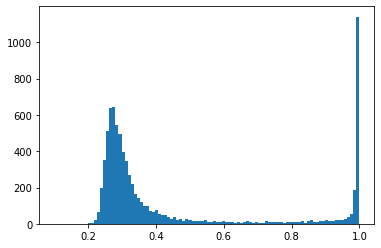

In [13]:
pseudo_df = pd.read_csv(PSEUDO_CSV)
plt.hist(pseudo_df["target"], bins=100, label="use target_real")
plt.show()

np.clip(pseudo_df['target'], 0.2, None)
10.0 0.0
(7975, 32)
(7327, 32)


0    6478
1     849
Name: real_sim, dtype: int64


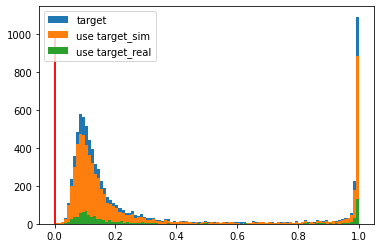

pseudo_df.shape: (7327, 32)


In [14]:
# ==================================================
# for Pseudo
# ==================================================
from sklearn.preprocessing import MinMaxScaler

if PSEUDO_CSV != "":
    pseudo_df = pd.read_csv(PSEUDO_CSV)
    pseudo_df["path"] = INPUT_DIR_TEST + "/test/" + pseudo_df["id"] + ".hdf5"
    #display(pseudo_df)
    
    if PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv":
        print("np.clip(pseudo_df['target'], 0.2, None)")
        # lb0.771のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.2, None)
        
    elif PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_ver18_lb0772.csv":
        print("np.clip(pseudo_df['target'], 0.2, None)")
        # lb0.772のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.2, None)
        
    elif PSEUDO_CSV == "./kqi_dl/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_submission.csv":
        print("np.clip(pseudo_df['target'], 0.21, None)")
        # lb0.774のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.21, None)
        
    elif PSEUDO_CSV == "./kqi_dl/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep_submission_tta012.csv":
        print("np.clip(pseudo_df['target'], 0.22, None)")
        # lb0.775のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.22, None)
    
    pseudo_df = pd.merge(pseudo_df, test_df[["id", "real_sim"]], on="id")
    
    # 確信度0-1に正規化
    pseudo_df["target"] = MinMaxScaler().fit_transform(pseudo_df["target"].values.reshape(-1, 1))
    #display(pseudo_df)
    
    # 分布可視化
    plt.hist(pseudo_df["target"], bins=100, label="target")
    
    p_sim_df = pseudo_df[pseudo_df["real_sim"] == 0].copy()
    p_real_df = pseudo_df[pseudo_df["real_sim"] == 1].copy()
    
    # 確信度が高い低いものだけ採用。0なら全部入れる
    if cfg_pseudo_max > 0:
        pseudo_df = pseudo_df[ (pseudo_df["target"] > cfg_pseudo_max) | (pseudo_df["target"] < cfg_pseudo_min) ].reset_index(drop=True)
        #display(pseudo_df)
        
    # simデータが高い低いものだけ採用
    if cfg_pseudo_sim_max > 0:
        p_sim_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_sim_max) | (p_sim_df["target"] < cfg_pseudo_sim_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == -1:
        # -1なら追加なし
        pass
        
    # realデータが高い低いものだけ採用
    if cfg_pseudo_real_max > 0:
        p_real_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_real_max) | (p_sim_df["target"] < cfg_pseudo_real_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == -1:
        # -1なら追加なし
        pass
        
    # ハードラベルにする
    if cfg_is_pseudo_hard:
        pseudo_df.loc[pseudo_df["target"] >= 0.5, "target"] = 1
        pseudo_df.loc[pseudo_df["target"] < 0.5, "target"] = 0
        pseudo_df["target"] = pseudo_df["target"].astype(int)
        #display(pseudo_df)
        print("pseudo_df['target'].value_counts():")
        print(pseudo_df["target"].value_counts())
        pseudo_df.target.plot.hist()
        plt.show()
        
    # test setと同じサイズに変更
    pseudo_df = pd.merge(pseudo_df[["id", "target"]], test_df.drop("target", axis=1), on="id").reset_index(drop=True)
    
    # MultiOutputに使う freq_min//N 列をつくる
    pseudo_df["freq_min//N"] = pseudo_df["freq min"] // cfg_freq_div_n
    print(pseudo_df["freq_min//N"].max(), pseudo_df["freq_min//N"].min())

    # 振幅が外れ値のpseudo_label除く
    if (DEL_Outlier_Pseudo_MEAN_TH > 0) or (DEL_Outlier_Pseudo_STD_TH > 0):
        print(pseudo_df.shape)
        pseudo_df = pseudo_df[
            (pseudo_df["h1_l1_mean"] <= DEL_Outlier_Pseudo_MEAN_TH)
            & (pseudo_df["h1_l1_std"] <= DEL_Outlier_Pseudo_STD_TH)
        ].reset_index(drop=True)
        print(pseudo_df.shape)
        display(
            pseudo_df[["h1_mean", "l1_mean", "h1_std", "l1_std", "h1_l1_mean", "h1_l1_std"]]
            .describe()
            .style.background_gradient(cmap="Blues")
        )
        print(pseudo_df["real_sim"].value_counts())
        
    # 分布可視化
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==0, "target"], bins=100, label="use target_sim")
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==1, "target"], bins=100, label="use target_real")
    plt.vlines(cfg_pseudo_max, 0, 1000, colors="red")
    plt.vlines(cfg_pseudo_min, 0, 1000, colors="red")
    plt.legend()
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()
    
    pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("pseudo_df.shape:", pseudo_df.shape)
    #display(pseudo_df)
    #print(pseudo_df["freq_min//10"].value_counts())
    #print(pseudo_df["freq_min//10"].max(), pseudo_df["freq_min//10"].min())

In [15]:
# ==================================================
# for Pseudo 追加
# ==================================================
if ADD_PSEUDO_DIRS != "":
    
    add_pseudo_df = None
    for _add_dir in eval(ADD_PSEUDO_DIRS):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
    
        _add_df = pd.read_csv(_add_dir + "/df.csv")
        _add_df["path"] = _add_dir + "/" + _add_df["id"] + _suff
        
        if add_pseudo_df is None:
            add_pseudo_df = _add_df
        else:
            add_pseudo_df = pd.concat([add_pseudo_df, _add_df]).reset_index(drop=True)
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_pseudo_df = pd.merge(add_pseudo_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_pseudo_df["freq_min//N"] = add_pseudo_df["freq min"] // cfg_freq_div_n
        print(add_pseudo_df["freq_min//N"].max(), add_pseudo_df["freq_min//N"].min())

    add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_pseudo_df.shape:", add_pseudo_df.shape)
    #display(add_pseudo_df)
    #print(add_pseudo_df["freq_min//10"].value_counts())
    #print(add_pseudo_df["freq_min//10"].max(), add_pseudo_df["freq_min//10"].min())

9.0 1.0
add_pseudo_df.shape: (796, 18)


In [16]:
#=====

In [17]:
if cfg_spec_max == 4096:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd/notebook?scriptVersionId=109593703
    # shape: (360, 4096)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 4279:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-spec-max4279?scriptVersionId=110466908
    # shape: (360, 4279)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 5760:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-largekernel-abs?scriptVersionId=111603297
    # shape: (360, 5760)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値


In [18]:
# ====================================================================================
# 前処理の helper 関数
# ====================================================================================
def get_cut_ids(ts, step: int):
    """同程度の時間幅になるタイムスタンプのインデックスを取得"""
    full_length = ts.max() - ts.min() + 1
    cut_length = full_length // step  # この時間単位でidx取得する
    cut_ids = [0] 
    _store = 0
    for i in range(1, len(ts)):
        _store += ts[i] - ts[i-1]
        if _store > cut_length:
            cut_ids.append(i)
            _store = 0
    if cut_ids[-1] != len(ts) - 1:
        cut_ids += [len(ts) - 1] 
    return cut_ids  # リストの長さはstepより少ないので注意すること


def standardization(x , mu: float, std: float, max_pixel_value=None):
    """標準化"""
    if max_pixel_value is None:
        return (x - mu) / std
    else:
        # https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize
        return (x - mu * max_pixel_value) / (std * max_pixel_value)

    
def a2p(a):
    """振幅をパワーに変換"""
    a = a[:,:]
    a = a * FCOFF
    #a = a * 1e22  # Fourier coefficient complex64  # 正規化しない場合ではこの係数だと振幅大きいデータでnanになる
    #a = a * 1e21
    #a = a * 1e20  # 振幅低くなりすぎて精度でない
    p = a.real**2 + a.imag**2  # power. shape=(360, 4224など)
    return p


def power_norm(p, norm_type: str, s: str = ""):
    """パワーを正規化"""
    if "p-norm" in norm_type:
        # normalize
        p /= np.mean(p)
    elif "p-stand" in norm_type:
        # チャネルごとの平均と標準偏差で標準化
        p = standardization(p, p.mean(), p.std())
    elif "p-common-stand" in norm_type:
        # データセット全体の統計値で標準化
        if s == "H1":
            p = standardization(p, cfg_p_mean[0], cfg_p_std[0])
        else:
            p = standardization(p, cfg_p_mean[1], cfg_p_std[1])
    elif "p-max" in norm_type:
        # 最大値で割って0-1にする
        p /= np.max(p)
        # MinMaxScaler
        #p = MinMaxScaler().fit_transform(p)
    elif "p-robustscaler" in norm_type:
        # RobustScaler
        p = RobustScaler().fit_transform(p)
    return p


def power_a_comp(p, step: int, spec_max: int, freq: int, norm_type: str):
    """パワーをtimestepsごとに平均+resizeして圧縮する"""
    if "ts-ma" in norm_type:
        ### timestepsごとに移動平均. compress 4096 -> 127
        
        # https://www.kaggle.com/anonamename/g2net2-exporing-test-train-datasets
        n_ma = spec_max//step

        # 累積合計を計算。 np.cumsum(np.array([1, 2, 3, 4, 5, 6])): [ 1  3  6 10 15 21]
        power_ma_cumsum = np.cumsum(p, axis=1)  

        # 累積合計をMA個の要素ごとの平均とる
        power_ma_cumsum_0 = np.concatenate((np.zeros((p.shape[0],1)), power_ma_cumsum), axis=1)[:,::n_ma]  

        # 累積合計を平均で引き算。numpy.diff() は受け取った配列の隣り合う要素同士の差分をとる
        p = np.diff(power_ma_cumsum_0, axis=1)[:,:-1]/n_ma  
        
    elif "ts-a" in norm_type:
        # timestepsごとに平均. compress 4096 -> 128
        p = np.mean(p.reshape(freq, step, spec_max//step), axis=2)
        
    return p

def power_img_clip(img):
    """
    H1とL1でパワーの最大値が違いすぎる画像はノイズっぽいので、最大値が小さい方のチャネルを基準にして最大値大きい方のチャネルの値をクリッピングする
    """
    #th_max = 1.5
    th_max = 2.0
    th_clip = 1.25
    #print(np.max(img[0]), np.max(img[1]))
    if (np.max(img[0]) > np.max(img[1])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[0] = np.clip(img[0], None, np.max(img[1])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[0][img[0] == np.max(img[1])*th_clip]  # クリッピング部分
        _x_other = img[0][img[0] != np.max(img[1])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[0][img[0] == np.max(img[1])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[0] = RobustScaler().fit_transform(img[0])
        
    if (np.max(img[1]) > np.max(img[0])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[1] = np.clip(img[1], None, np.max(img[0])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[1][img[1] == np.max(img[0])*th_clip]  # クリッピング部分
        _x_other = img[1][img[1] != np.max(img[0])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[1][img[1] == np.max(img[0])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[1] = RobustScaler().fit_transform(img[1])

    return img

# ====================================================================================
# 前処理のメイン関数
# ====================================================================================
def amp2power(a, s, step, spec_max, norm_type, freq, ts=None):
    """振幅をパワーに変換して前処理も実行するメイン関数"""
    
    if "spec-sequence_a" in norm_type:
        ### gap区切りでパワーを圧縮してから正規化
        # 振幅をパワーに変換
        p = a2p(a)

        # 1つ隣のタイムポイントで引き算して+1800。基本の間隔は1800なので連続して計測してる場合は0になる
        gap_length = ts[1:] - (ts[:-1] + 1800)  

        # 隣接データでタイムポイントが0以上になった1800以上空いてるデータ点のインデックスのリスト
        gap_length_nonzero_idx = np.argwhere(gap_length != 0).flatten()
        #gap_length_nonzero_idx = gap_length_nonzero_idx[::2]  # 1つ飛ばしでidx取る場合

        # gapがある時刻区切りで平均化
        p_sequence_a = np.empty((freq, len(gap_length_nonzero_idx)+1), dtype=np.float32)
        s_idx = 0
        for i, e_idx in enumerate(gap_length_nonzero_idx):
            #print(i, s_idx, e_idx, np.mean(p[:,s_idx:e_idx], axis=1).shape, p_sequence_a[:,i].shape)
            p_sequence_a[:,i] = np.mean(p[:,s_idx:e_idx], axis=1)
            s_idx = e_idx
        if e_idx != len(gap_length_nonzero_idx)-1:
            p_sequence_a[:,-1] = np.mean(p[:,e_idx:], axis=1)

        # 後続処理のためstep単位のサイズにしておく
        spec_max = step*(p_sequence_a.shape[1]//step)
        p = p_sequence_a[:,:spec_max]
    
        p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        p = power_norm(p, norm_type, s=s)  # パワーを正規化
        
    else:
        if "default-norm" in norm_type:
            ### パワーを正規化してから圧縮(public NBの前処理)
            p = a2p(a)  # 振幅をパワーに変換
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        else:
            ### パワーを圧縮してから正規化
            p = a2p(a)  # 振幅をパワーに変換
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            
    return p


# https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification
def hdf5_to_img(h_path, step, spec_max, 
                norm_type=normalize_type, 
                ch=2, 
                freq=360,
               ):
    """hdf5ファイルロードしてパワーの画像に変換する"""
    
    if "largekernel" in norm_type:
        # publicNBの前処理
        # https://www.kaggle.com/code/laeyoung/g2net-large-kernel-inference/notebook
        if "p-robustscaler" in norm_type:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=True)
        else:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=False)
        ps = largekernel.preprocess(1, power, h1_m, l1_m, is_cuda=False, is_tta=True)[0]
        
        ## パワー圧縮前に外れ値クリッピング
        #if "clip" in norm_type:
        #    ps = power_img_clip( np.stack([ ps[0], ps[1] ] ) )
        
        p_h1 = power_a_comp(ps[0], step, 5760, freq, norm_type)  # パワーを圧縮
        p_l1 = power_a_comp(ps[1], step, 5760, freq, norm_type)  # パワーを圧縮
        img = np.stack([ p_h1, p_l1 ] ).astype(np.float32)
        
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
        return img
    
    file_id = Path(h_path).stem
    img = None
    with h5py.File(h_path, 'r') as f:
        g = f[file_id]
        
        a_h1, ts_h1 = g["H1"]['SFTs'][:], g["H1"]['timestamps_GPS'][:]
        a_l1, ts_l1 = g["L1"]['SFTs'][:], g["L1"]['timestamps_GPS'][:]
        
        ## 振幅の外れ値クリッピング
        #if "clip" in norm_type:
        #    a_clip = power_img_clip( np.stack([ a_h1, a_l1 ] ) )
        #    a_h1, a_l1 = a_clip[0], a_clip[1]
        
        if "same_ts_interval" in norm_type:
            ### H1,L1のズレを軽減するために、同じ時間間隔でパワーを平均してから正規化
            
            # 同程度の時間幅になるタイムスタンプのインデックスを取得
            h1_cut_ids = get_cut_ids(ts_h1, step+10)  # stepより小さくなるから大きめに取る
            l1_cut_ids = get_cut_ids(ts_l1, step+10)  # stepより小さくなるから大きめに取る
            #print(len(ts_h1), h1_cut_ids)
            #print(len(ts_l1), l1_cut_ids)
            
            # サイズ揃える
            n_min = min(len(h1_cut_ids), len(l1_cut_ids))
            img = np.empty((ch, freq, n_min-1), dtype=np.float32)
            p_h1 = a2p(a_h1)
            p_l1 = a2p(a_l1)
            for i in range(1, n_min):
                img[0,:,i-1] = np.mean(p_h1[:,h1_cut_ids[i-1]:h1_cut_ids[i]], axis=1)  # パワーを圧縮
                img[1,:,i-1] = np.mean(p_l1[:,l1_cut_ids[i-1]:l1_cut_ids[i]], axis=1)  # パワーを圧縮
            img[0] = power_norm(img[0], norm_type, s="H1")  # パワーを正規化
            img[1] = power_norm(img[1], norm_type, s="L1")  # パワーを正規化
            if "ts-ma" in norm_type:
                img = img[:,:,:step-1]
            else:
                img = img[:,:,:step]
            #print(img.shape)
            
        else:
            ### 振幅をパワーに変換
            p_h1 = amp2power(a_h1, "H1", step, spec_max, norm_type, freq, ts=ts_h1)
            p_l1 = amp2power(a_l1, "L1", step, spec_max, norm_type, freq, ts=ts_l1)
            # サイズ揃える
            min_len = min(p_h1.shape[1], p_l1.shape[1])
            img = np.stack([ p_h1[:,:min_len], p_l1[:,:min_len] ] ).astype(np.float32)
            
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
    return img

# Quick EDA

In [19]:
def show_1img_2ch(img):
    
    if normalize_type == "default_3ch":
        plt.figure(figsize=(20, 12))
        
        for i in range(img.shape[0]):
            plt.subplot(1, 6, i+1)
            plt.title('Spectrogram')
            plt.xlabel('time')
            plt.ylabel('frequency')
            plt.imshow(img[i])
            plt.colorbar()
            
        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()
    else:
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.title('H1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[0])
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('L1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[1])
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

In [20]:
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#
#print()
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    pass
#print(_path)
#img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
#                  norm_type=normalize_type, 
#                  ch=cfg_ch, 
#                  freq=360)
#print("img.max(), img.min():", img.max(), img.min())
#print("img.shape:", img.shape)
#print("y:", test_df.iloc[806]["target"])
#show_1img_2ch(img)
#print(img)

=> train label dist
1    400
0    200
Name: target, dtype: int64

=> train+test SFTs w
H1 SFTs w max(), min() 4887.0 4281.0
L1 SFTs w max(), min() 4878.0 4279.0

=> normalize_type: largekernel|p-robustscaler|ts-ma|clip
/workspace/g2net2/input/train/02887d232.hdf5
img.max(), img.min(): 0.98194396 -0.22631836
img.shape: (2, 360, 127)
y: 1


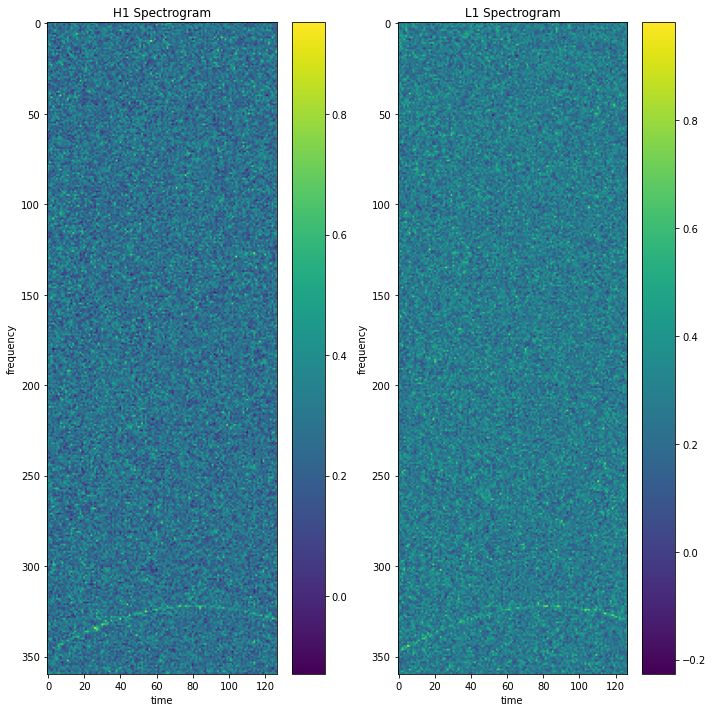

[[[0.3439952  0.14955014 0.33968183 ... 0.27611762 0.1611518  0.36105958]
  [0.24551754 0.43467417 0.23059684 ... 0.24906684 0.24220648 0.2196479 ]
  [0.13005266 0.25246972 0.27681237 ... 0.34472114 0.2696289  0.20864257]
  ...
  [0.28589532 0.29320085 0.02045508 ... 0.08943685 0.18378635 0.2775472 ]
  [0.35115185 0.42867374 0.14893036 ... 0.40314943 0.3257107  0.05790473]
  [0.51326555 0.45509452 0.46702778 ... 0.3156033  0.35514593 0.31131455]]

 [[0.1470839  0.24464017 0.16885151 ... 0.2705268  0.29387206 0.24636501]
  [0.5226985  0.2558361  0.44855195 ... 0.52117515 0.23853081 0.29988065]
  [0.19417733 0.27680364 0.48412114 ... 0.20174153 0.39838326 0.2993978 ]
  ...
  [0.17014015 0.23523475 0.09281849 ... 0.19130045 0.2806993  0.21143934]
  [0.06807415 0.37778178 0.59807014 ... 0.36835125 0.13459201 0.43517795]
  [0.18805464 0.33352354 0.24057071 ... 0.20960829 0.36946887 0.35831162]]]

/kqi/output/g2net-detecting-continuous-gravitational-waves/test/0040fc1b3.hdf5
img.max(), img.m

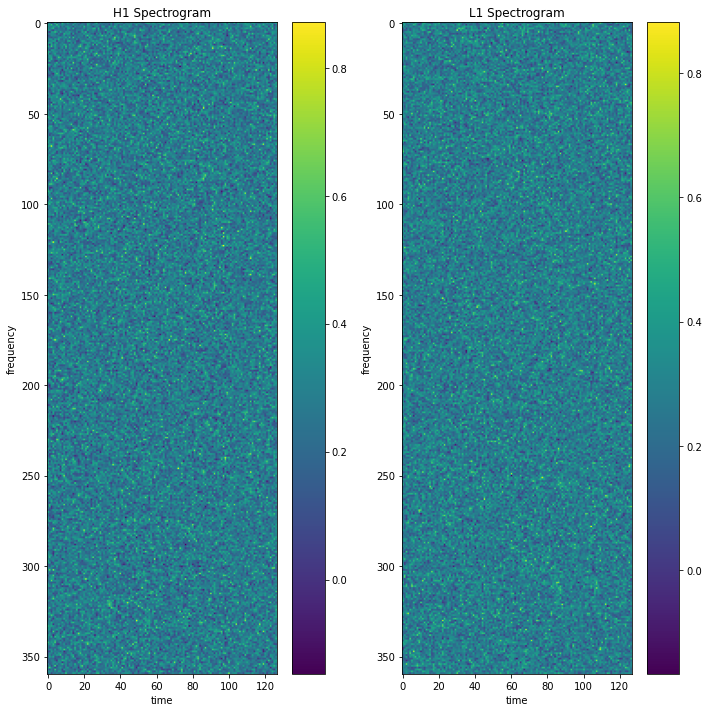

[[[0.12124544 0.36804736 0.04238129 ... 0.20784234 0.31707084 0.47362468]
  [0.46234632 0.33104688 0.5898562  ... 0.50326604 0.04364149 0.21597221]
  [0.33758253 0.3275305  0.27540025 ... 0.35268825 0.14797634 0.2869629 ]
  ...
  [0.22363488 0.0858983  0.2892658  ... 0.17597927 0.04318034 0.36307508]
  [0.36758474 0.35399204 0.30537245 ... 0.4657335  0.35894367 0.24987522]
  [0.16459998 0.33468667 0.07454694 ... 0.32655436 0.10443251 0.23136394]]

 [[0.42914826 0.34857678 0.22337706 ... 0.2172065  0.17765842 0.1798801 ]
  [0.31704423 0.46204996 0.21622509 ... 0.4168023  0.34211427 0.15257975]
  [0.50088316 0.18978305 0.35714057 ... 0.4344157  0.08825412 0.20547146]
  ...
  [0.2454727  0.34384483 0.29906806 ... 0.34504938 0.40651312 0.17650825]
  [0.20939682 0.31080484 0.40330145 ... 0.05805121 0.2878445  0.23225369]
  [0.14764802 0.23995294 0.35467488 ... 0.3349311  0.3717041  0.26442328]]]


In [21]:
print("=> train label dist")
print(train_df.target.value_counts())
print()

print("=> train+test SFTs w")
_df = pd.concat([train_df, test_df])
print("H1 SFTs w max(), min()", _df["H1 SFTs w"].max(), _df["H1 SFTs w"].min())
print("L1 SFTs w max(), min()", _df["L1 SFTs w"].max(), _df["L1 SFTs w"].min())
print()

#normalize_type = "default-norm|p-norm|ts-a"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "spec-sequence_a|ts-ma|p-norm"
#normalize_type = "spec-sequence_a|ts-ma|p-stand"
#normalize_type = "spec-sequence_a|ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-norm"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|p-stand"
#normalize_type = "same_ts_interval|p-common-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel"

#cfg_step = 32
#cfg_step = 64
#cfg_step = 128

#cfg_spec_max = 4096
#cfg_spec_max = 4224


# 画像可視化
print("=> normalize_type:", normalize_type)

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", train_df.iloc[_i]["target"])
show_1img_2ch(img)
print(img)

print()
_path = test_df.iloc[_i]["path"]
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/a666b93a9.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d6828b59a.hdf5"
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360)
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", test_df.iloc[806]["target"])
show_1img_2ch(img)
print(img)

In [22]:
#%debug

In [23]:
#=====

# To npy

In [24]:
#!rm -r {NPY_DIR}/{normalize_type}

In [25]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def hdf5_to_npy(h_paths, out_dir):
    """
    前処理したhdf5データをnpyに保存する
    """
    if cfg_is_npy and (os.path.exists(out_dir) == False): 
        os.makedirs(out_dir, exist_ok=True)
        for _path in tqdm(h_paths):
            img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                              norm_type=normalize_type, 
                              ch=cfg_ch, 
                              freq=360,
                             )
            np.save(os.path.join(out_dir, f'{Path(_path).stem}.npy'), np.array(img))
    else:
        print(f"INFO: Exist {out_dir}")


if cfg_is_npy:
    _npy_dir = f"{NPY_DIR}/{normalize_type}"
    _max_workers = multiprocessing.cpu_count()  # total CPU
    with ThreadPoolExecutor(max_workers=_max_workers, thread_name_prefix="thread") as executor:
        hdf5_to_npy(train_df["path"].to_numpy(), f"{_npy_dir}/train")
        if IS_MAKE_SUB or (PSEUDO_CSV != ""):
            hdf5_to_npy(test_df["path"].to_numpy(), f"{_npy_dir}/test")
        if ADD_DIRS_STR != "":
            for _add_dir in eval(ADD_DIRS_STR):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        if ADD_PSEUDO_DIRS != "":
            for _add_dir in eval(ADD_PSEUDO_DIRS):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        
    # path書き換え
    train_df["path"] = f"{_npy_dir}/train/" + train_df["id"] + ".npy"
    print(train_df["path"].iloc[0])  # パス確認
    if IS_MAKE_SUB:
        test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
        print(test_df["path"].iloc[0])  # パス確認
    if ADD_DIRS_STR != "":
        add_df_all["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_df_all["path"].to_numpy()
        ]
        add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_df_all["path"].iloc[0])  # パス確認
    if PSEUDO_CSV != "":
        pseudo_df["path"] = f"{_npy_dir}/test/" + pseudo_df["id"] + ".npy"
        pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(pseudo_df["path"].iloc[0])  # パス確認
    if ADD_PSEUDO_DIRS != "":
        add_pseudo_df["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_pseudo_df["path"].to_numpy()
        ]
        add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_pseudo_df["path"].iloc[0])  # パス確認

INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/train
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/test
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex003_generating_noise_2_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_noise_gap1400
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_signal_gap800
INFO: Exist /workspace/g2ne

In [26]:
#=====

# Libraries

In [27]:
import warnings
warnings.filterwarnings("ignore")  

import os
import gc
import cv2
import math
import copy
import time
import random
import shutil
import yaml
import glob
from pprint import pprint
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict
import traceback
import imagesize

# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px
from PIL import Image
from matplotlib import pyplot as plt

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import torchaudio

# Utils
import pickle, joblib
from tqdm import tqdm
tqdm.pandas()

# Sklearn Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

# For Image Models
import timm
print("timm:", timm.__version__)
from timm.data import ImageDataset
from timm.data.mixup import Mixup, one_hot
from timm.data.auto_augment import rand_augment_transform
from timm.loss.cross_entropy import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy
from timm.scheduler import CosineLRScheduler  # warmupつきCosineAnnealingLR

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# tta
import ttach as tta

# DDP
# 何故か3090ではエラーになる
#from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs

## Synchronized-BatchNorm for DP
## https://blog.shikoan.com/sync-batch-norm-pytorch/
#import sys
#sys.path.append('./Synchronized-BatchNorm-PyTorch')
#from sync_batchnorm import convert_model, DataParallelWithCallback 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

TORCH_VERSION = '.'.join(torch.__version__.split('.')[:3])
print('torch:', TORCH_VERSION)

timm: 0.6.12
device: cuda
torch: 1.13.1+cu117


In [28]:
%reload_ext autoreload
%autoreload 2
from src.sam import SAM, ASAM
from src.cv_split import cv_split, cv_split_kfold

In [29]:
## timmのモデル一覧
## https://github.com/rwightman/pytorch-image-models/blob/master/results/README.md
##!pip install "git+https://github.com/rwightman/pytorch-image-models.git"
#import timm
#from pprint import pprint
#model_names = timm.list_models(pretrained=True)
#pprint(model_names)

In [30]:
#def test_timm_lr_Scheduler():
#    """
#    timmのlr_Schedulerの動作確認
#    https://timm.fast.ai/SGDR#cycle_limit=2
#    """
#    from timm import create_model 
#    from timm.optim import create_optimizer
#    from types import SimpleNamespace
#    from matplotlib import pyplot as plt
#
#    def get_lr_per_epoch(scheduler, num_epoch):
#        lr_per_epoch = []
#        for epoch in range(num_epoch):
#            lr_per_epoch.append(scheduler.get_epoch_values(epoch))
#        return lr_per_epoch
#
#    model = create_model('resnet34')
#
#    num_epoch = 50
#    
#    args = SimpleNamespace()
#    args.weight_decay = 0
#    args.lr = 1e-2
#    args.opt = 'adam' 
#    args.momentum = 0.9
#
#    optimizer = create_optimizer(args, model)
#
#    scheduler = CosineLRScheduler(optimizer, 
#                                  t_initial=num_epoch//3,  # 総エポック数
#                                  lr_min=args.lr*1e-2,  # 最小学習率
#                                  warmup_t=3,  # ウォームアップ完了時のエポック数
#                                  warmup_lr_init=args.lr*1e-2,  # ウォームアップの初期学習率
#                                  warmup_prefix=True,  # Warmupが完了したタイミングの学習率をオプティマイザーで設定した基本学習率にするかどうか
#                                  cycle_limit=1,  # lr restartの回数
#                                 )
#    lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
#
#    plt.plot([i for i in range(num_epoch)], lr_per_epoch);
#    
#test_timm_lr_Scheduler()

# CFG

In [31]:
import os, yaml, shutil

class Config:
    def __init__(self):
        self.name=NAME
        self.train=True
        self.debug=DEBUG
        self.print_freq=1000
        self.is_save_per_steps=False
        self.target_col="target"
        self.num_classes=1
        self.loss = "nn.BCEWithLogitsLoss"
        
        self.model_cls=model_cls
        self.apex=cfg_apex
        self.load_model_path=load_model_path
        #self.load_model_path=f"{OUTPUT_DIR}/tmp_fold0_seed0_best_score.pth"
        #self.is_load_opt=True
        self.is_load_opt=False
        
        # ============== model params ==============
        self.model_name=MODEL_NAME
        self.size_h=size_h
        self.size_w=size_w
        self.batch_size=BATCH_SIZE
        self.gradient_accumulation_steps=gradient_accumulation_steps
        self.is_syncBN = is_syncBN
        self.pretrained = cfg_pretrained
        self.drop_rate = cfg_drop_rate
        self.drop_path_rate = cfg_drop_path_rate
        # ==========================================
        
        self.num_workers=8#16 if "/work" in os.getcwd() else 8
        self.epochs=epochs
        self.optimizer=cfg_optimizer
        self.lr=lr
        self.warmup_lr_init=self.lr*min_lr_ratio
        self.min_lr=self.lr*min_lr_ratio
        self.weight_decay=weight_decay
        self.scheduler=cfg_scheduler  # 'CosineLRScheduler'  # warmup
        self.warmup_t=warmup_t
        self.T_max=epochs
        self.max_grad_norm=1000
        
        self.cv_col=cfg_cv_col
        self.seeds=cfg_seeds
        self.n_fold=n_fold
        self.trn_fold=trn_fold
        
        self.is_wandb=is_wandb
        self.device_ids=device_ids
        
        # ============== data params ==============
        self.step=cfg_step
        self.spec_max=cfg_spec_max
        self.ch=cfg_ch
        self.freq=360
        self.norm_type=normalize_type
        # ==========================================
        
        # 自作mixup
        self.prob_mixup = cfg_prob_mixup  # 0.0なら発生確率=0
        self.mix_alpha = 1.0
        self.is_mix_or = True
        #self.mixup_off_epoch = self.epochs-5  # 最後の5epochはmixup/cutmixなしにする
        self.mixup_off_epoch = 0  # 常にmixup/cutmixなし
        
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        self.prob_sample_mixup = cfg_prob_sample_mixup
        # sample_mixupのデータはpseudoデータだけにするか
        self.is_sample_mixup_use_pseudo = cfg_is_sample_mixup_use_pseudo
        
        # 追加データのtarget=0とオリジナルのtarget=0とのmixup確率
        self.prob_add_sample_nega_mixup = cfg_prob_add_sample_nega_mixup
        
        # データセットの移動平均のpowerとのmixupの確率
        self.prob_mean_mixup = cfg_prob_mean_mixup
        
        # ch追加するか
        self.is_add_ch = cfg_is_add_ch
        
        # スペクトログラムの開始点をランダムに変えるか
        self.prob_spec_start_random = cfg_prob_spec_start_random
        
        # test setのような縦線や横線のノイズ入れる確率
        self.prob_noise_band = cfg_prob_noise_band
        
        # test setのような外れ点ノイズ入れる確率
        self.prob_noise_spot = cfg_prob_noise_spot
        
        # test setのようなまばらな外れ縦線ノイズ入れる確率
        self.prob_noise_vline = cfg_prob_noise_vline
        
        # test setのようなまばらな外れ横バンドノイズ入れる確率
        self.prob_noise_hband = cfg_prob_noise_hband
        
        # target=0のデータのチャネル入れ替える確率
        self.prob_swap_ch_nega = cfg_prob_swap_ch_nega
        
        # target=0のデータhflipする確率
        self.prob_flip_nega = cfg_prob_flip_nega
        
        # target=0のデータ同士をシャッフルする確率
        self.prob_swap_nega = cfg_prob_swap_nega
        
        # target=0のデータをVshiftする確率
        self.prob_vshift_nega = cfg_prob_vshift_nega
        
        # データ関係なくVshiftする確率
        self.prob_vshift = cfg_prob_vshift
        
        # torchaudioで縦横cutout(マスク)する本数
        self.time_mask_num = cfg_time_mask_num  # 縦線
        self.freq_mask_num = cfg_freq_mask_num  # 横線
        self.time_mask_param = cfg_time_mask_param  # マスクの可能な最大長。[0, time_mask_param) 
        self.freq_mask_param = cfg_freq_mask_param  # マスクの可能な最大長。[0, freq_mask_param) 
        
        # zip_datasetをtrainにして学習するか
        self.is_train_zip_dataset = cfg_is_train_zip_dataset
        
        # 生成したデータは別の切り方でfold分けるときに使うKfoldのAPI名(StratifiedKFold, KFoldなど)。""なら別の切り方でfold分けない
        self.add_split_str = cfg_add_split_str
        
        # データをnpyに変換するか
        self.is_npy = cfg_is_npy
        
        # 学習に追加した生成データのディレクトリ名
        self.add_dirs_str = ADD_DIRS_STR
        
        # 学習に追加したtestの疑似ラベルに使うcsv、確信度の閾値、ハードラベルにするか
        self.pseudo_csv = PSEUDO_CSV
        self.pseudo_ths = [cfg_pseudo_max, cfg_pseudo_min]
        self.is_pseudo_hard = cfg_is_pseudo_hard
        
        # 学習に追加したtestの疑似ラベルをリアルデータ/シュミレーションデータだけにするか
        self.pseudo_type = cfg_pseudo_type
        
        # 追加の疑似ラベルのディレクトリ名
        self.add_pseudo_dirs = ADD_PSEUDO_DIRS
        
        # MultiOutputに使う列の要素。freq_min//cfg_freq_div_n の freq_min//N 列をつくる
        self.freq_div_n = cfg_freq_div_n
        
        # これ以上の h1_mean+l1_mean, h1_std+l1_std を取る画像は除いて統計値出し、その統計値でalbの正規化行う
        self.alb_norm_mean_th = cfg_alb_norm_mean_th 
        self.alb_norm_std_th = cfg_alb_norm_std_th  
        

CFG = Config()
        
if CFG.debug:
    #CFG.seeds=[0,1,2]
    CFG.is_wandb=False
    #CFG.is_wandb=True
    CFG.print_freq=10
    CFG.epochs=1
    #CFG.epochs=5
    #CFG.warmup_t=1
    #CFG.mixup_off_epoch=3
    #CFG.epochs=1
    #CFG.mixup_off_epoch=1
    #CFG.epochs=10
    #CFG.trn_fold=[0]
    #CFG.trn_fold=[0,1,2,3,4]
#    train_df = cv_split(train_df, 0, 10, cv_col="target")
#    train_df = train_df[train_df["fold"] == 0].reset_index(drop=True)
#    print("debug train_df.shape:", train_df.shape)
#    test_df = test_df.iloc[:30]
#    print("debug test_df.shape:", test_df.shape)
    # モデル削除
    !rm -f {OUTPUT_DIR}/*pth
    
with open(OUTPUT_DIR + "/cfg.yaml", "w") as wf:
    yaml.dump(CFG.__dict__, wf)
        
if len(CFG.device_ids) > 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(_) for _ in CFG.device_ids])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    CFG.batch_size = CFG.batch_size*len(CFG.device_ids)
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(CFG.device_ids[0])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    # For descriptive error messages
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    
pprint(CFG.__dict__)

os.environ['CUDA_VISIBLE_DEVICES']: 0
{'T_max': 100,
 'add_dirs_str': '[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, '
                 'EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, '
                 'EX006_SIGNAL800, EX006_SIGNAL_ISO800]',
 'add_pseudo_dirs': '[EX007_NONSTAT_NOISE800]',
 'add_split_str': 'StratifiedKFold',
 'alb_norm_mean_th': 5,
 'alb_norm_std_th': 10,
 'apex': True,
 'batch_size': 64,
 'ch': 2,
 'cv_col': 'target',
 'debug': False,
 'device_ids': [0],
 'drop_path_rate': 0.2,
 'drop_rate': 0.4,
 'epochs': 100,
 'freq': 360,
 'freq_div_n': 50,
 'freq_mask_num': 2,
 'freq_mask_param': 10,
 'gradient_accumulation_steps': 1,
 'is_add_ch': False,
 'is_load_opt': False,
 'is_mix_or': True,
 'is_npy': True,
 'is_pseudo_hard': False,
 'is_sample_mixup_use_pseudo': True,
 'is_save_per_steps': False,
 'is_syncBN': False,
 'is_train_zip_dataset': False,
 'is_wandb': True,
 'load_model_path': 'none',
 'loss': 'nn.BCEWithLogitsLoss',
 'lr': 0.0004,
 'max_grad_norm': 1000,

# Utils

In [32]:
def init_logger(log_file=OUTPUT_DIR + '/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('> SEEDING DONE')

# Wandb

In [33]:
if CFG.is_wandb:
    import wandb
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        wandb.login(key="")  # 自分の api key でログイン  # https://wandb.ai/settings
        wandb.init(project="", entity='', name=NAME)
        wandb.config.update(CFG.__dict__)  # ハイパラ登録

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anonamename. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Dataset

In [34]:
class TrainDataset(Dataset):
    def __init__(self, train, transforms=None, 
                 is_npy=True,
                 is_add_ch=False,
                 prob_spec_start_random=0.0,
                 prob_sample_mixup=0.0,
                 is_sample_mixup_use_pseudo=CFG.is_sample_mixup_use_pseudo,
                 prob_add_sample_nega_mixup=0.0,
                 prob_mean_mixup=0.0, 
                 prob_noise_band=0.0,
                 prob_noise_spot=0.0,
                 prob_noise_vline=0.0,
                 prob_noise_hband=0.0,
                 prob_swap_ch_nega=0.0,
                 prob_flip_nega=0.0,
                 prob_swap_nega=0.0,
                 prob_vshift_nega=0.0,
                 prob_vshift=0.0,
                 time_mask_num=0,
                 freq_mask_num=0,
                 time_mask_param=CFG.time_mask_param,
                 freq_mask_param=CFG.freq_mask_param,
                ):
        self.train = train
        self.file_names = train['path'].values
        self.labels = train['target'].values
        self.transforms = transforms
        
        self.labels_freq = train['freq_min//N'].values - (40 // CFG.freq_div_n)  # for MultiOutput
        
        self.orig_flags = train['orig'].values  # np.nanは追加データ
        
        self.is_npy = is_npy  # npyをロードするか
        
        self.prob_spec_start_random = prob_spec_start_random  # スペクトログラムの開始点をランダムに変える確率
        
        self.is_add_ch = is_add_ch  # ch増やすか
        
        #self.train0 = train[train["target"] == 0]   # label=0のdf
        if is_sample_mixup_use_pseudo:
            #self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
            self.train0 = pseudo_df[pseudo_df["target"] < 0.5]   # label=0のdf pseudoのデータだけでmix
            if ADD_PSEUDO_DIRS != "":
                self.train0 = pd.concat([self.train0, add_pseudo_df], ignore_index=True)
        else:
            self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
        
        self.train0_orig = train[train["target"] < 0.5].dropna(subset=['freq min']).reset_index(drop=True)  # label=0かつオリジナルデータのdf
        
        self.prob_sample_mixup = prob_sample_mixup  # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        
        self.prob_add_sample_nega_mixup = prob_add_sample_nega_mixup  # 追加データのtarget=0とオリジナルのtarget=0とをmixup確率
        
        self.prob_mean_mixup = prob_mean_mixup  # データセットの移動平均のpowerとのmixup
        
        self.prob_noise_band = prob_noise_band  # test setのような縦線や横線のノイズ入れる確率
        
        self.prob_noise_spot = prob_noise_spot  # test setのような外れ点ノイズ入れる確率
        
        self.prob_noise_vline = prob_noise_vline  # test setのようなまばらな外れ縦線ノイズ入れる確率
        
        self.prob_noise_hband = prob_noise_hband  # test setのようなまばらな外れ横バンドノイズ入れる確率
        
        self.prob_swap_ch_nega = prob_swap_ch_nega # negaサンプルch入れ替える確率
        
        self.prob_flip_nega = prob_flip_nega  # negaサンプルhflipする確率
        
        self.prob_swap_nega = prob_swap_nega  # negaサンプル別の使う確率
        
        self.prob_vshift_nega = prob_vshift_nega  # negaサンプルのみ縦方向に平行移動(VShift)する確率
        
        self.prob_vshift = prob_vshift  # 縦方向に平行移動(VShift)する確率
        
        self.time_mask_num = time_mask_num # number of time masking
        self.freq_mask_num = freq_mask_num # number of frequency masking
        self.transforms_time_mask = nn.Sequential(
            # time_mask_param はマスクする幅の最大長。[0, time_mask_param) 
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param),
        )
        self.transforms_freq_mask = nn.Sequential(
            # freq_mask_param はマスクする幅の最大長。[0, freq_mask_param) 
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param),
        )    
        
    def __len__(self):
        return len(self.train)
    
    def load_img(self, path):
        if self.is_npy:
            img = np.load(path)
        else:
            img = hdf5_to_img(path, CFG.step, CFG.spec_max, 
                              norm_type=CFG.norm_type, 
                              ch=CFG.ch, 
                              freq=CFG.freq)  # (C,H,W)
        img = img.transpose(1, 2, 0)  # (H,W,C)
    
        ### 振幅の開始点をランダムに変更
        if (np.random.rand() > 1 - self.prob_spec_start_random) and (img.shape[1] > CFG.size_w):
            spec_start = img.shape[1] - CFG.size_w
            spec_start = int(np.random.uniform(low=0, high=spec_start))
            img = img[:, spec_start:spec_start+CFG.size_w, :]  # shape=(360, size_w, 2)
            #print("spec_start:", spec_start)
        
        ### 横幅のサイズはsize_wまでにする
        if CFG.size_w > 0:
            img = img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
        
        #print("img.shape:", img.shape)
        return img
    
    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.float)
        img = self.load_img(self.file_names[index])
        
        orig_flag = self.orig_flags[index]
        
        # ===============================================
        # for MultiOutput
        # ===============================================
        label_freq = self.labels_freq[index]
        label_freq = torch.tensor(label_freq, dtype=torch.long)
        label_freq = one_hot(label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
        
        # ===============================================
        # test setのような縦線や横線のノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 v_noise_band {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 v_noise_band {v_n_line}")
            
        # ===============================================
        # test setのような外れ点ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_spot:
            # H1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 0] *= _ratio  # 係数掛ける
            #print(f"{index} H1 noise_spot {n_area}")
        if np.random.rand() > 1 - self.prob_noise_spot:
            # L1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 1] *= _ratio  # 係数掛ける
            #print(f"{index} L1 noise_spot {n_area}")
            
        # ===============================================
        # test setのようなまばらな外れ縦線ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_vline:
            # H1の外れ縦線
            v_n_line = np.random.randint(1,8)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 0] += _gs_n
            #print(f"{index} H1 noise_vline {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_vline:
            # L1の外れ縦線
            v_n_line = np.random.randint(1, 5)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,1].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 1] += _gs_n
            #print(f"{index} L1 noise_vline {v_n_line}")
            
        # ===============================================
        # test setのようなまばらな外れ横バンドノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_hband:
            # H1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 0] += _gs_n
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_hband:
            # L1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 1] += _gs_n
            #print(f"{index} L1 h_noise_band {w_n_line}")
            
        # ソフトラベルの対策。negativeとみなすラベルの値
        nega_th = 0.5
        
        # ===============================================
        # VShift
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        if (np.random.rand() > 1 - self.prob_vshift):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift")
        ### Negative VShift
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_vshift_nega):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift_nega")
        
        # ===============================================
        # Negative Swap CH
        # ===============================================
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_swap_ch_nega):
            i0 = img[:,:,0].copy()
            img[:,:,0] = img[:,:,1]
            img[:,:,1] = i0
            #print("swap_ch_nega")
        
        # ===============================================
        # 前回コンペ8位のaug
        # https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275335
        # ===============================================
        # LIGO Swap は A.ChannelShuffle で実行
        
        # Negative Flip
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[:, ::-1, :].copy()  # hflip
            #print("hflip_nega")
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[::-1, :, :].copy()  # vflip
            #print("vflip_nega")
        
        # Swap with Other Negative
        if (label < nega_th) and (self.prob_swap_nega > 0.0):
            sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,0] = sample_img[:,:,0]
                #print("h1 swap_nega")
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,1] = sample_img[:,:,1]
                #print("l1 swap_nega")
            
        # ===============================================
        # Sample Mixup
        # ===============================================
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmix
        if np.random.rand() > 1 - self.prob_sample_mixup:
            if label < nega_th:
                sample = self.train.sample()
            else:
                sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            img = (img + sample_img) / 2.0
            # mix_sample_lam の割合で混ぜる
            #mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            #img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
            
            if sample.iloc[0]['target'] >= nega_th:
                label = torch.tensor(sample.iloc[0]['target']).float()
            
            # for MultiOutput
            sample_label_freq = sample.iloc[0]['freq_min//N'] - (40 // CFG.freq_div_n)
            sample_label_freq = torch.tensor(sample_label_freq, dtype=torch.long)
            sample_label_freq = one_hot(sample_label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
            label_freq = (label_freq + sample_label_freq) / 2.0
            
            #print("sample_mixup", sample.iloc[0]['target'])
            
        # ===============================================
        # Add Data Nega Sample Mixup
        # ===============================================
        # target=0について add_data と orig_data をmixup
        if np.random.rand() > 1 - self.prob_add_sample_nega_mixup:
            if np.isnan(orig_flag):
                # orig_flagがnegaならadd_data
                if label < nega_th:
                    sample = self.train0_orig.sample()
                sample_img = self.load_img(sample.iloc[0]['path'])
                # mix_sample_lam の割合で混ぜる
                mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
                img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
                #print("add_sample_nega_mixup")
        
        # ===============================================
        # Mean Mixup
        # ===============================================
        # データセット全体の移動平均とmix
        if np.random.rand() > 1 - self.prob_mean_mixup:

            # データセット全体の移動平均の振幅をパワーに変換
            abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step), dtype=np.float32)
            if ("ts-ma" in CFG.norm_type) and (cfg_step % 64 == 0):
                # step%64=0の移動平均は1要素減る
                abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step-1), dtype=np.float32)
            abs_mean_img[0] = amp2power(a_abs_mean_h1, "H1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img[1] = amp2power(a_abs_mean_l1, "L1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img = abs_mean_img.transpose(1, 2, 0)  # (H,W,C)
            # 横幅のサイズはsize_wまでにする
            if CFG.size_w > 0:
                abs_mean_img = abs_mean_img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
            
            # mean_lam の割合で混ぜる
            mean_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            img = mean_lam*img + (1-mean_lam)*abs_mean_img
        
            # 移動平均と混ぜた分のラベルもmix
            if label < nega_th:
                label += 0.1*(1-mean_lam)
            #print("mean_mixup")
            
        # ===============================================
        # ch増やす
        # ===============================================
        if self.is_add_ch:
            img = np.stack([img[:,:,0], img[:,:,1],
                            img[:,:,0] + img[:,:,1], 
                            img[:,:,0] - img[:,:,1]])  # (C,H,W)
            img = img.transpose(1, 2, 0)  # (H,W,C)
              
        if self.transforms:
            img = self.transforms(image=img)["image"]  # (C,H,W)

        # ===============================================
        # Torchaudio Masking
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        # imgはtorch型の(C,H,W)形式じゃないとだめ
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.time_mask_num): # time masking
                img = self.transforms_time_mask(img)
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.freq_mask_num): # frequency masking
                img = self.transforms_freq_mask(img)
            
        return img, label, label_freq

# calc_mean_std

In [35]:
%reload_ext autoreload
%autoreload 2
from src import calc_mean_std

_df = pd.concat([train_df, test_df])
print(_df.shape)

# 外れ値のデータは除く
_df = _df[
    (_df["h1_l1_mean"] <= CFG.alb_norm_mean_th)
    & (_df["h1_l1_std"] <= CFG.alb_norm_std_th)
].reset_index(drop=True)
print(_df.shape)
display(_df[["h1_mean", "l1_mean", "h1_std", "l1_std", "h1_l1_mean", "h1_l1_std"]].describe().style.background_gradient(cmap="Blues"))

_dataset = TrainDataset(_df, 
                        is_npy=CFG.is_npy, 
                        is_add_ch=CFG.is_add_ch,)
_loader = DataLoader(_dataset, 
                     #batch_size=CFG.batch_size * 2, # batch_size=1でないとだめ
                     shuffle=False, 
                     num_workers=CFG.num_workers, pin_memory=False, drop_last=False)
X_MEAN, X_STD, X_MAX = calc_mean_std.calc_mean_std_max(_dataset, _loader, N_CHANNELS=CFG.ch)

(8575, 33)
(7927, 33)


==> Computing mean and std..


100%|██████████████████████████████████████████████████████████████████████████████| 7927/7927 [00:53<00:00, 147.23it/s]


mean, std, max: [0.2797384  0.27972412] [0.12301076 0.12294598] [2.8376431 2.6048286]


# Transform

In [36]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            ToTensorV2(),
        ])
    elif data == 'train_norm':
        print("train_norm")
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            A.Normalize(
                mean=X_MEAN, std=X_STD, max_pixel_value=np.max(X_MAX),
                p=1.0,
            ),
            ToTensorV2(),
        ])
    elif data == 'valid_norm':
        print("valid_norm")
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            A.Normalize(
                mean=X_MEAN, std=X_STD, max_pixel_value=np.max(X_MAX),
                p=1.0,
            ),
            ToTensorV2(),
        ])
    #elif data == 'tta1':
    #    return A.Compose([
    #        A.Resize(CFG.size_h, CFG.size_w),
    #        A.ChannelShuffle(always_apply=True, p=1.0),
    #        ToTensorV2(),
    #    ])

In [37]:
def mixup(x, y, alpha):
    """
    Usage:
        x, y = batch["x"], batch["y"]
        x, y_mixs = mixup(x, y.long(), 1.0)
        y_hat = model(x.float())
        loss = criterion(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + criterion(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])
    """
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.7)
    x = lam*x + (1-lam)*shuffled_x
    ys = (y, shuffled_y, lam)

    return x, ys

# Dataloader check

train_norm
torch.Size([15, 2, 360, 127]) torch.Size([15]) torch.Size([15, 1, 11])


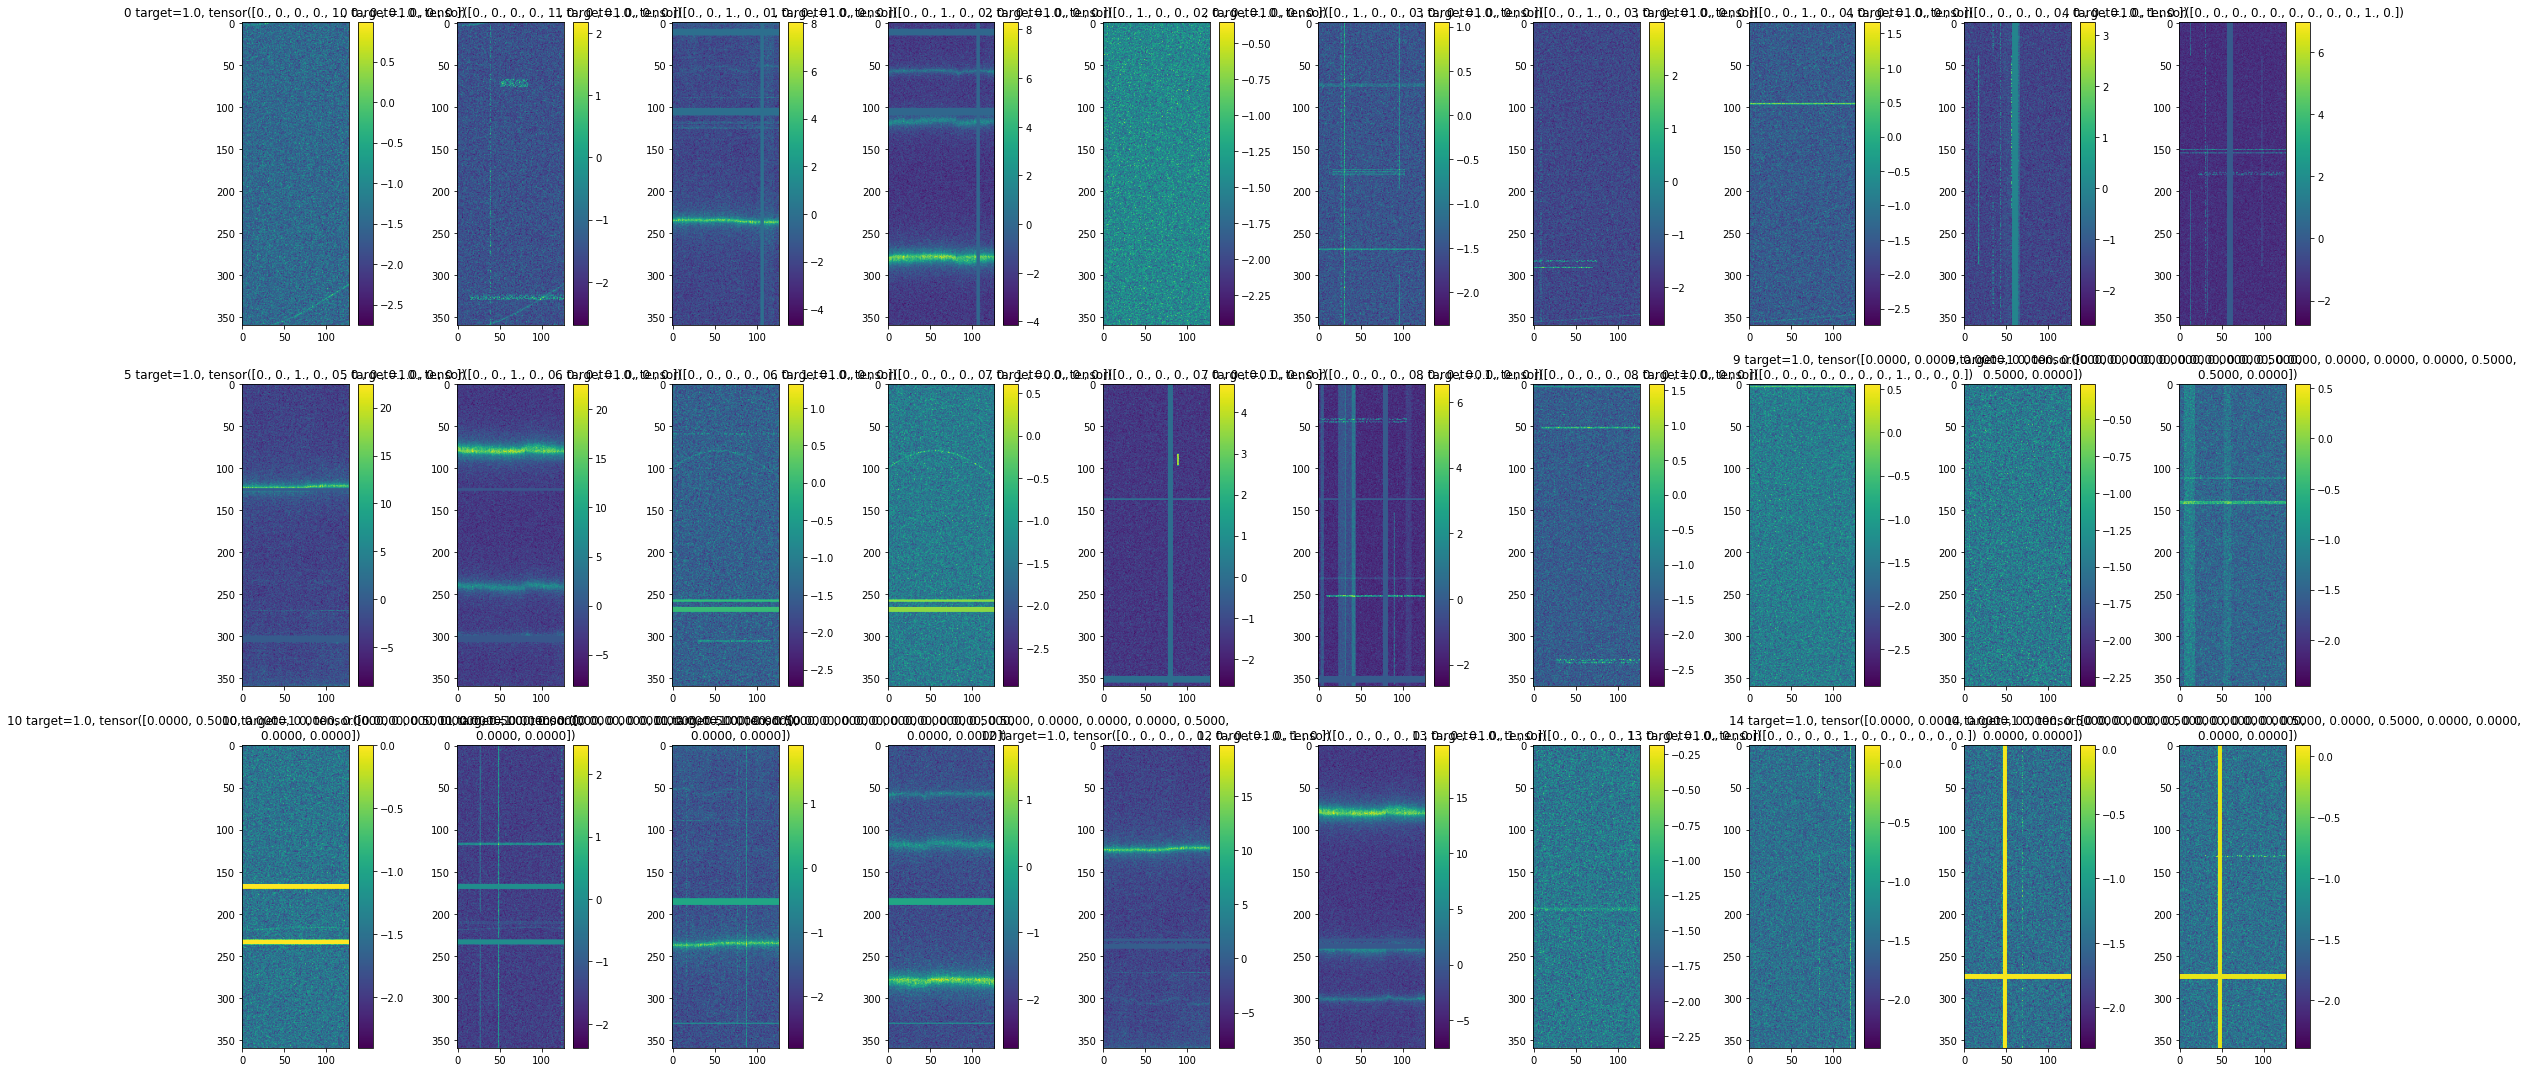

In [38]:
#%%time
# timeでファイルioに時間かかるか確認
if CFG.is_train_zip_dataset:
    train_dataset = ZipDataset(
        path=f"{zip_path}/archive", mod=zip_mod, transforms=get_transforms(data="train")
    )
else:
    train_dataset = TrainDataset(
        train_df,
        #pd.concat([train_df, add_df_all]),
        #transforms=get_transforms(data="train"),
        transforms=get_transforms(data="train_norm"),
        is_npy=CFG.is_npy,
        is_add_ch=CFG.is_add_ch,
        prob_spec_start_random=CFG.prob_spec_start_random,
        prob_sample_mixup=CFG.prob_sample_mixup,
        prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
        prob_mean_mixup=CFG.prob_mean_mixup,
        prob_noise_band=CFG.prob_noise_band,
        prob_noise_spot=CFG.prob_noise_spot,
        prob_noise_vline=CFG.prob_noise_vline,
        prob_noise_hband=CFG.prob_noise_hband,
        prob_swap_ch_nega=CFG.prob_swap_ch_nega,
        prob_flip_nega=CFG.prob_flip_nega,
        prob_swap_nega=CFG.prob_swap_nega,
        prob_vshift_nega=CFG.prob_vshift_nega,
        prob_vshift=CFG.prob_vshift,
        time_mask_num=CFG.time_mask_num,
        freq_mask_num=CFG.freq_mask_num,
    )
    #train_dataset = TrainDataset(
    #    #train_df,
    #    pd.concat([train_df, add_df_all]),
    #    transforms=get_transforms(data="train"),
    #    is_npy=CFG.is_npy,
    #    #is_add_ch=True,
    #    #prob_spec_start_random=1.0,
    #    prob_add_sample_nega_mixup=1.0,
    #    prob_sample_mixup=1.0,
    #    prob_mean_mixup=1.0,
    #    prob_noise_band=1.0,
    #    prob_noise_spot=1.0,
    #    prob_noise_vline=1.0,
    #    prob_noise_hband=1.0,
    #    #prob_swap_ch_nega=1.0,
    #    #prob_flip_nega=1.0,
    #    #prob_swap_nega=1.0,
    #    #prob_vshift_nega=1.0,
    #    #prob_vshift=1.0,
    #    #time_mask_num=5,
    #    #freq_mask_num=5,
    #)
train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True,
    #collate_fn=mixup_collate_fn,
)
for step, (images, labels, labels_freq) in enumerate(train_loader):
    print(images.shape, labels.shape, labels_freq.shape)
    
    if normalize_type == "largekernel":
        plt.figure(figsize=(30,25))
    else:
        plt.figure(figsize=(30,15))
    i = 1
    for idx, (im, la, la_f) in enumerate(zip(images, labels, labels_freq)):
        #print(la_f.shape)
        #print(la_f.squeeze().shape)
        im = im.transpose(0, 1).transpose(1, 2)  # (H,W,C)
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,0])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,1])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if i > 30:
            break
            
    plt.tight_layout()
    plt.show()
    break

In [39]:
#%debug

In [40]:
#=====

# Model

In [41]:
class CustomModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch)        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModel(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [42]:
# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook を参考にdropout入れて過学習避ける
class CustomModelDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch, 
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [43]:
class CustomModelMultiOutput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [44]:
class CustomModelMultiOutputDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch,
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutputDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [45]:
from src import layer_edit
class CustomModelMultiOutputStride12(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)
        
        # 最初の conv レイヤーのモデル ストライドをfirst_strideに変更
        self.net = layer_edit.patch_first_conv_stride(self.net, first_stride=(1,2))
        
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // cfg.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

In [46]:
#=====

In [47]:
class CustomModelAddEmb(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features+(500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, CFG.num_classes)  # embを1次元増やす
        )
    def forward(self, x, add_x):
        feat = self.net(x)
        #print(feat.shape, add_x.shape)
        y = self.head( torch.cat((feat, add_x), 1) )
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelAddEmb(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#add_x = torch.rand(CFG.batch_size, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)
#o = m(x.cuda(), add_x.cuda())
#print(o, o.shape)
##m

In [48]:
#=====

In [49]:
class CustomModelMultiInput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net1 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2) 
        self.net2 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2)
        self.head = nn.Sequential(
            nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net1.num_features + self.net2.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        
        x1 = x[:, :CFG.ch//2, :, :]
        x2 = x[:, CFG.ch//2:, :, :]
        #print(x1.shape, x2.shape)
        
        feat1 = self.net1(x1)
        feat2 = self.net2(x2)
        y = self.head( torch.cat((feat1, feat2), 1) )
        #print(feat1.shape, feat2.shape, y.shape)
        
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelMultiInput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [50]:
#=====

In [51]:
class CustomModelLargeKernel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            pth = "/volume/kaggle/g2net2/kaggle_dl/g2net-detecting-continuous-gravitational-waves-v0/model_best.pth"
        else:
            pth = ""
        self.net = largekernel.get_model(
            model_name="tf_efficientnetv2_b0",
            path=pth,
            conv_in_chans=32
        )
        self.net.classifier = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelLargeKernel().cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [52]:
#=====

In [53]:
# https://github.com/sinpcw/kaggle-whale2/blob/master/models.py
def loadpth(pth: str, map_location=None) -> OrderedDict:
    """
    パラメータロードのヘルパー関数.
    DataParallel化したモデルは module.xxxx という形式で保存されるため読込み時にmodule.から始まる場合はそれを取除く.
    """
    ostate = torch.load(pth, map_location=map_location)['model']
    nstate = OrderedDict()
    for k, v in ostate.items():
        if k.startswith('module.'):
            nstate[k[len('module.'):]] = v
        else:
            nstate[k] = v
    return nstate

# Metric

In [54]:
def get_score(labels: np.ndarray, predictions: np.ndarray):
    # predictions が nan になったときの対策
    try:
        return roc_auc_score(labels, predictions)
    except:
        return 0.0

# Helper

In [55]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [56]:
def forward_step(step, losses, batch_size, model, criterion, images, labels, prob_mixup, optimizer, scaler, optimizer_step,
                 labels_freq, criterion2):  # for MultiOutput
    """
    SAMは2回forward必要だからforwardの処理（loss計算+backward）切り出す
    """
    # SAM 1st/2nd Path
    optimizer.step = optimizer_step
    
    # ===========================================
    # model forward for mixup
    # ===========================================
    if np.random.rand() > 1 - prob_mixup:
        x, y_mixs = mixup(images, labels.long(), CFG.mix_alpha)  # y_mixs=(target, shuffled_target, lambda)
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(x.float())  # for MultiOutput
                if CFG.is_mix_or:
                    y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                    loss = criterion(outputs, y_mix_or.float())
                else:
                    loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
        else:
            outputs, outputs2 = model(x.float())  # for MultiOutput
            if CFG.is_mix_or:
                y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                loss = criterion(outputs, y_mix_or.float())
            else:
                loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
    else:
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
                loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
        else:
            outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
            loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
            
    loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
    loss = (loss + loss2) / 2.0  # for MultiOutput
    
    # ===========================================
    # record loss
    # ===========================================
    losses.update(loss.item(), batch_size)  # loggerにloss保存
    if CFG.gradient_accumulation_steps > 1:
        loss = loss / CFG.gradient_accumulation_steps  # normalize loss to account for batch accumulation
    if CFG.apex:
        scaler.scale(loss).backward()  # 各パラメータの勾配を算出
    else:
        loss.backward()  # 誤差逆伝播して各パラメータの勾配を算出
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)  # 勾配クリッピング
    
    # ===========================================
    # optimizer step
    # ===========================================
    if (step + 1) % CFG.gradient_accumulation_steps == 0:
        if CFG.apex:
            scaler.step(optimizer)  # 勾配の情報を用いたパラメータの更新
            scaler.update()
        else:
            optimizer.step()  # 勾配の情報を用いたパラメータの更新
        optimizer.zero_grad()  # 勾配情報の初期化
        
    return optimizer, scaler, losses, grad_norm

In [57]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, 
             prob_mixup=False, mixup_fn=None,
             criterion2=None):  # for MultiOutput
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    else:
        scaler = None
    losses = AverageMeter()
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        ## ===========================================
        ## timm mixup/cutmix
        ## ===========================================
        #if mixup_fn is not None:
        #    images, labels = mixup_fn(images, labels)
        #else:
        #    labels = one_hot(labels, CFG.num_classes, device=device)
        
        if isinstance(optimizer, SAM) or isinstance(optimizer, ASAM):
            optimizer, scaler, _, _ = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                   prob_mixup, optimizer, scaler, 
                                                   optimizer.first_step,
                                                   labels_freq, criterion2)  # for MultiOutput
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.second_step,
                                                                labels_freq, criterion2)  # for MultiOutput
        else:
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.step,
                                                                labels_freq, criterion2)  # for MultiOutput
            
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.4e}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=optimizer.param_groups[0]["lr"]))
        
        if CFG.is_save_per_steps:
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                OUTPUT_DIR + "/per_steps.pth",
            )

    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg

In [58]:
@torch.inference_mode()  # pytorch >= 1.9
def valid_fn(valid_loader, model, criterion, device, 
             criterion2):  # for MultiOutput
    model.eval()
    losses = AverageMeter()
    preds = []
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(valid_loader):  # for MultiOutput
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        # ===========================================
        # compute loss
        # ===========================================
        with torch.no_grad():
            # for MultiOutput
            outputs, outputs2 = model(images)  # logit
        loss = criterion(outputs, labels)
        loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
        loss = (loss + loss2) / 2.0  # for MultiOutput
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        ## ===========================================
        ## record topk index
        ## ===========================================
        #_, tk = torch.topk(outputs, 5, dim=1)
        #topk_indexs = tk.to('cpu').detach().numpy()
        #preds.append(topk_indexs[:,0])  # top1
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
            
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg, predictions

# Train loop

In [59]:
def train_loop(folds, fold, seed):
    
    LOGGER.info(f"========== fold: {fold}, seed: {seed} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    if CFG.is_train_zip_dataset:
        train_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod, transforms=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, is_npy=False, transforms=get_transforms(data='valid'))
    else:
        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            train_transforms_type = 'train_norm'
            valid_transforms_type = 'valid_norm'
        else:
            train_transforms_type = 'train'
            valid_transforms_type = 'valid'
        train_dataset = TrainDataset(train_folds, 
                                     transforms=get_transforms(data=train_transforms_type), 
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                     prob_spec_start_random=CFG.prob_spec_start_random,
                                     prob_sample_mixup=CFG.prob_sample_mixup,
                                     prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
                                     prob_mean_mixup=CFG.prob_mean_mixup,
                                     prob_noise_band=CFG.prob_noise_band,
                                     prob_noise_spot=CFG.prob_noise_spot,
                                     prob_noise_vline=CFG.prob_noise_vline,
                                     prob_noise_hband=CFG.prob_noise_hband,
                                     prob_swap_ch_nega=CFG.prob_swap_ch_nega,
                                     prob_flip_nega=CFG.prob_flip_nega,
                                     prob_swap_nega=CFG.prob_swap_nega,
                                     prob_vshift_nega=CFG.prob_vshift_nega,
                                     prob_vshift=CFG.prob_vshift,
                                     time_mask_num=CFG.time_mask_num,
                                     freq_mask_num=CFG.freq_mask_num,
                                    )
        valid_dataset = TrainDataset(valid_folds, 
                                     transforms=get_transforms(data=valid_transforms_type),
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                    )
    
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineLRScheduler':
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
        elif CFG.scheduler=='CosineLRScheduler_cycle_limit3':
            _cycle_limit = 3
            # https://timm.fast.ai/SGDR#cycle_limit=2
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs//_cycle_limit, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True,
                                          cycle_limit=_cycle_limit,
                                         )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = eval(CFG.model_cls)(pretrained=CFG.pretrained)
    
    if os.path.exists(CFG.load_model_path):
        LOGGER.info("=> loading checkpoint '{}'".format(CFG.load_model_path))
        states = torch.load(CFG.load_model_path, map_location=torch.device("cpu"))
        if len(CFG.device_ids) > 1:
            model.load_state_dict( loadpth(CFG.load_model_path, map_location=torch.device("cpu")) )
        else:
            model.load_state_dict(states["model"])
    
    if len(CFG.device_ids) > 1:
        if CFG.is_syncBN:
            # https://blog.shikoan.com/sync-batch-norm-pytorch/
            model = convert_model(model).to(device) # Batch NormをSync Batch Normに変換
            model = DataParallelWithCallback(model, device_ids=CFG.device_ids) # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids} use SyncBN")
        else:
            model.to(device)
            model = nn.DataParallel(model, device_ids=CFG.device_ids)  # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids}")
        # https://aru47.hatenablog.com/entry/2020/11/06/225052
        cudnn.benchmark = True
    else:
        model.to(device)

    if CFG.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == "adamw":
        optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'nesterov':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay, nesterov=True)
    elif CFG.optimizer == 'sam':
        optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=CFG.lr, weight_decay=CFG.weight_decay, rho=0.05)
        
    scheduler = get_scheduler(optimizer)
    
    if os.path.exists(CFG.load_model_path):
        if CFG.is_load_opt:
            LOGGER.info("=> loading optimizer and scheduler")
            optimizer.load_state_dict(states["optimizer"])
            scheduler.load_state_dict(states["scheduler"])

    if CFG.is_wandb:
        # wandbでpytorchのモデル監視
        wandb.watch(model)
            
    # ====================================================
    # loop
    # ====================================================
    train_criterion = eval(CFG.loss)().to(device)
    valid_criterion = eval(CFG.loss)().to(device)
    # for MultiOutput
    train_criterion2 = nn.CrossEntropyLoss().to(device)
    valid_criterion2 = nn.CrossEntropyLoss().to(device)
    
    best_score = -np.inf
    best_loss = np.inf
    
    #mixup_fn = Mixup(**CFG.mixup_args)
    mixup_fn = None
    prob_mixup = CFG.prob_mixup
    
    for epoch in range(CFG.epochs):
        
        # mixup_off_epoch以上はmixup/cutmixなしにする
        if epoch >= CFG.mixup_off_epoch:
            mixup_fn = None
            prob_mixup = 0.0
            #LOGGER.info(f'Epoch {epoch+1} - mixup_fn=None')
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, train_criterion, optimizer, epoch, scheduler, device, 
                            prob_mixup=prob_mixup,
                            criterion2=train_criterion2)  # for MultiOutput

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, valid_criterion, device,
                                       valid_criterion2)  # for MultiOutput
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, CosineLRScheduler):
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler.step(epoch+1)
            
        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - lr: {optimizer.param_groups[0]["lr"]:.4e}')
       
        if CFG.is_wandb:
            # save log wandb
            wandb.log({f"[fold{fold}] epoch": epoch+1,
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] lr": optimizer.param_groups[0]["lr"]})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
            
    valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth', map_location=torch.device('cpu'))['preds'].tolist()
    #valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth', map_location=torch.device('cpu'))['preds'].tolist()

    return valid_folds

# Main

In [60]:
def get_result(result_df, preds_col="preds", add_info=""):
    labels = result_df[CFG.target_col].values
    preds = result_df[preds_col].values
    preds = np.array([np.array(p) for p in preds])
    score = get_score(labels, preds)
    LOGGER.info(f'{add_info}Score: {score:<.4f}')
    return score
    

def main(df):
    if CFG.train:
        oof_scores = []
        for seed in CFG.seeds:
            seed_torch(seed)
            
            # 生成データロード
            if ADD_DIRS_STR != "":
                add_df = pd.read_csv(f"{OUTPUT_DIR}/add_data.csv")
                if CFG.debug:
                    add_df = cv_split_kfold(add_df, 0, 10)
                    add_df = add_df[add_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_df.shape: {str(add_df.shape)}")

                # cv_split
                if CFG.add_split_str == "":
                    folds = pd.concat([df, add_df], ignore_index=True)
                    folds = cv_split(folds, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                else:
                    # オリジナルデータと生成データは別の切り方でfold分ける
                    if CFG.add_split_str == "KFold":
                        add_df = cv_split_kfold(add_df, seed, CFG.n_fold)
                    else:
                        add_df = cv_split(add_df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold

                    folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                    folds = pd.concat([folds, add_df], ignore_index=True) 
                    
                # 生成データのtarget=1はすべてtrainに使う
                if IS_ADD_ALL_TRAIN1:
                    _orig_folds = folds.dropna(subset=['freq_min//10_target'])
                    _add_folds = folds.dropna(subset=['type'])
                    _add_target0 = _add_folds[_add_folds[CFG.target_col] == 0]
                    _add_target1 = _add_folds[_add_folds[CFG.target_col] == 1]
                    _add_target1["fold"] = -1    
                    folds = pd.concat([_orig_folds, _add_target0, _add_target1]).reset_index(drop=True)
                    print(folds.groupby(['fold', CFG.target_col]).size())

            else:
                folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                
            # zip_df.csvでfinetuneする場合
            if CFG.is_train_zip_dataset:
                folds = pd.read_csv(f'{zip_path}/zip_df.csv')                
                df["fold"] = 0
                folds = pd.concat([folds, df], ignore_index=True)
                
            # 疑似ラベル全foldのtrainに入れる
            if PSEUDO_CSV != "":
                pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/pseudo_df.csv")
                if CFG.debug:
                    pseudo_df = cv_split_kfold(pseudo_df, 0, 30)
                    pseudo_df = pseudo_df[pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"pseudo_df.shape: {str(pseudo_df.shape)}")
                pseudo_df["fold"] = -1
                folds = pd.concat([folds, pseudo_df], ignore_index=True)
            if ADD_PSEUDO_DIRS != "":
                add_pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv")
                if CFG.debug:
                    add_pseudo_df = cv_split_kfold(add_pseudo_df, 0, 30)
                    add_pseudo_df = add_pseudo_df[add_pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_pseudo_df.shape: {str(add_pseudo_df.shape)}")
                add_pseudo_df["fold"] = -1
                folds = pd.concat([folds, add_pseudo_df], ignore_index=True)
                
            folds.to_csv(OUTPUT_DIR +f"/folds_seed{seed}.csv", index=False)
            LOGGER.info(f"folds.shape: {str(folds.shape)}")
            
            # train fold
            scores = []
            oof_df = pd.DataFrame()
            for fold in range(CFG.n_fold):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(folds, fold, seed)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} seed: {seed} result ==========")
                    _score = get_result(_oof_df, add_info=f"fold{fold} ")
                    scores.append(_score)
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    
            # CV result
            LOGGER.info(f"========== CV ==========")
            LOGGER.info(f'macro mean folds Score ± std: {np.mean(scores):<.4f} ± {np.std(scores):<.4f}')
            oof_score = get_result(oof_df, add_info=f"oof ")
            oof_scores.append(oof_score)
            # save result
            oof_df.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}.csv', index=False)
            
            if CFG.is_wandb:
                # save log wandb
                wandb.log({f"[fold{str(CFG.trn_fold)}] best_score": oof_score})
            
            plt.hist(oof_df["preds"], bins=100)
            plt.show()
            plt.clf()  # メモリ解放
            plt.close()
            
        if len(oof_scores) > 1:
            LOGGER.info(f'seed macro mean oof Score ± std: {np.mean(oof_scores):<.4f} ± {np.std(oof_scores):<.4f}') 

add_df.shape: (8400, 24)
pseudo_df.shape: (7327, 32)
add_pseudo_df.shape: (796, 18)


> SEEDING DONE
fold0: (1680,)
fold1: (1680,)
fold2: (1680,)
fold3: (1680,)
fold4: (1680,)
fold  target
0     0         880
      1         800
1     0         880
      1         800
2     0         880
      1         800
3     0         880
      1         800
4     0         880
      1         800
dtype: int64
fold0: (120,)
fold1: (120,)
fold2: (120,)
fold3: (120,)
fold4: (120,)
fold  target
0     0         40
      1         80
1     0         40
      1         80
2     0         40
      1         80
3     0         40
      1         80
4     0         40
      1         80
dtype: int64


folds.shape: (17123, 40)
========== fold: 0, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/239] Elapsed 0m 4s (remain 19m 42s) Loss: 1.5413(1.5413) Grad: 56149.2930  LR: 4.0000e-06  
Epoch: [1][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.5322(1.5389) Grad: 56841.7695  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 17s) Loss: 1.5591(1.5591) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5695(1.5436) 


Epoch 1 - avg_train_loss: 1.5389  avg_val_loss: 1.5436  time: 106s
Epoch 1 - Score: 0.5926
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.5926 Model
Epoch 1 - Save Best Loss: 1.5436 Model


Epoch: [2][0/239] Elapsed 0m 2s (remain 8m 49s) Loss: 1.5365(1.5365) Grad: 55960.8398  LR: 1.3600e-04  
Epoch: [2][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3972(1.4206) Grad: 56488.7695  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3067(1.3067) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3196(1.3174) 


Epoch 2 - avg_train_loss: 1.4206  avg_val_loss: 1.3174  time: 104s
Epoch 2 - Score: 0.8035
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8035 Model
Epoch 2 - Save Best Loss: 1.3174 Model


Epoch: [3][0/239] Elapsed 0m 1s (remain 7m 46s) Loss: 1.3481(1.3481) Grad: 45079.0703  LR: 2.6800e-04  
Epoch: [3][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.3501(1.3761) Grad: 39160.7461  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2988(1.2988) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3879(1.2965) 


Epoch 3 - avg_train_loss: 1.3761  avg_val_loss: 1.2965  time: 103s
Epoch 3 - Score: 0.8200
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8200 Model
Epoch 3 - Save Best Loss: 1.2965 Model


Epoch: [4][0/239] Elapsed 0m 2s (remain 8m 11s) Loss: 1.4167(1.4167) Grad: 78203.4766  LR: 4.0000e-04  
Epoch: [4][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3401(1.3684) Grad: 42717.8828  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2596(1.2596) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3526(1.2993) 


Epoch 4 - avg_train_loss: 1.3684  avg_val_loss: 1.2993  time: 104s
Epoch 4 - Score: 0.8293
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8293 Model


Epoch: [5][0/239] Elapsed 0m 2s (remain 10m 5s) Loss: 1.3817(1.3817) Grad: 45696.1289  LR: 3.9990e-04  
Epoch: [5][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.4461(1.3598) Grad: 45779.9336  LR: 3.9990e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2590(1.2590) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2161(1.2831) 


Epoch 5 - avg_train_loss: 1.3598  avg_val_loss: 1.2831  time: 103s
Epoch 5 - Score: 0.8496
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8496 Model
Epoch 5 - Save Best Loss: 1.2831 Model


Epoch: [6][0/239] Elapsed 0m 2s (remain 9m 19s) Loss: 1.3218(1.3218) Grad: 19428.1816  LR: 3.9961e-04  
Epoch: [6][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3480(1.3546) Grad: 20533.5176  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3415(1.3415) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4472(1.3229) 


Epoch 6 - avg_train_loss: 1.3546  avg_val_loss: 1.3229  time: 105s
Epoch 6 - Score: 0.8328
Epoch 6 - lr: 3.9912e-04


Epoch: [7][0/239] Elapsed 0m 2s (remain 9m 17s) Loss: 1.2840(1.2840) Grad: 20410.3965  LR: 3.9912e-04  
Epoch: [7][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3811(1.3487) Grad: 49019.0859  LR: 3.9912e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2558(1.2558) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4853(1.2846) 


Epoch 7 - avg_train_loss: 1.3487  avg_val_loss: 1.2846  time: 104s
Epoch 7 - Score: 0.8579
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Score: 0.8579 Model


Epoch: [8][0/239] Elapsed 0m 2s (remain 9m 30s) Loss: 1.3239(1.3239) Grad: 41106.6797  LR: 3.9844e-04  
Epoch: [8][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3350(1.3450) Grad: 24449.4473  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2448(1.2448) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3216(1.2657) 


Epoch 8 - avg_train_loss: 1.3450  avg_val_loss: 1.2657  time: 106s
Epoch 8 - Score: 0.8471
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Loss: 1.2657 Model


Epoch: [9][0/239] Elapsed 0m 2s (remain 9m 50s) Loss: 1.3285(1.3285) Grad: 21297.6367  LR: 3.9756e-04  
Epoch: [9][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3316(1.3387) Grad: 24057.2207  LR: 3.9756e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2479(1.2479) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2936(1.2810) 


Epoch 9 - avg_train_loss: 1.3387  avg_val_loss: 1.2810  time: 105s
Epoch 9 - Score: 0.8504
Epoch 9 - lr: 3.9649e-04


Epoch: [10][0/239] Elapsed 0m 2s (remain 8m 19s) Loss: 1.3221(1.3221) Grad: 25213.5703  LR: 3.9649e-04  
Epoch: [10][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3540(1.3460) Grad: 9714.4863  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2407(1.2407) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2645(1.2794) 


Epoch 10 - avg_train_loss: 1.3460  avg_val_loss: 1.2794  time: 103s
Epoch 10 - Score: 0.8520
Epoch 10 - lr: 3.9523e-04


Epoch: [11][0/239] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3495(1.3495) Grad: 21707.1348  LR: 3.9523e-04  
Epoch: [11][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.2860(1.3397) Grad: 26250.7734  LR: 3.9523e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2376(1.2376) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3117(1.2535) 


Epoch 11 - avg_train_loss: 1.3397  avg_val_loss: 1.2535  time: 103s
Epoch 11 - Score: 0.8523
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Loss: 1.2535 Model


Epoch: [12][0/239] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3381(1.3381) Grad: 22547.4492  LR: 3.9378e-04  
Epoch: [12][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3211(1.3349) Grad: 23637.7793  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2268(1.2268) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2930(1.2515) 


Epoch 12 - avg_train_loss: 1.3349  avg_val_loss: 1.2515  time: 104s
Epoch 12 - Score: 0.8596
Epoch 12 - lr: 3.9214e-04
Epoch 12 - Save Best Score: 0.8596 Model
Epoch 12 - Save Best Loss: 1.2515 Model


Epoch: [13][0/239] Elapsed 0m 2s (remain 11m 5s) Loss: 1.3340(1.3340) Grad: 23872.0410  LR: 3.9214e-04  
Epoch: [13][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3207(1.3350) Grad: 22198.9297  LR: 3.9214e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2124(1.2124) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3287(1.2452) 


Epoch 13 - avg_train_loss: 1.3350  avg_val_loss: 1.2452  time: 105s
Epoch 13 - Score: 0.8500
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Loss: 1.2452 Model


Epoch: [14][0/239] Elapsed 0m 2s (remain 10m 2s) Loss: 1.3668(1.3668) Grad: 20493.8750  LR: 3.9031e-04  
Epoch: [14][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3666(1.3318) Grad: 55210.7539  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2265(1.2265) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2566(1.2541) 


Epoch 14 - avg_train_loss: 1.3318  avg_val_loss: 1.2541  time: 106s
Epoch 14 - Score: 0.8544
Epoch 14 - lr: 3.8829e-04


Epoch: [15][0/239] Elapsed 0m 2s (remain 8m 18s) Loss: 1.3145(1.3145) Grad: 22551.1309  LR: 3.8829e-04  
Epoch: [15][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3519(1.3307) Grad: 30252.9297  LR: 3.8829e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2234(1.2234) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3521(1.2518) 


Epoch 15 - avg_train_loss: 1.3307  avg_val_loss: 1.2518  time: 104s
Epoch 15 - Score: 0.8463
Epoch 15 - lr: 3.8610e-04


Epoch: [16][0/239] Elapsed 0m 2s (remain 9m 19s) Loss: 1.3632(1.3632) Grad: 34079.5547  LR: 3.8610e-04  
Epoch: [16][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3414(1.3304) Grad: 20167.2031  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1916(1.1916) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2080(1.2355) 


Epoch 16 - avg_train_loss: 1.3304  avg_val_loss: 1.2355  time: 106s
Epoch 16 - Score: 0.8548
Epoch 16 - lr: 3.8372e-04
Epoch 16 - Save Best Loss: 1.2355 Model


Epoch: [17][0/239] Elapsed 0m 2s (remain 9m 7s) Loss: 1.3618(1.3618) Grad: 46938.8398  LR: 3.8372e-04  
Epoch: [17][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3556(1.3291) Grad: 17867.8730  LR: 3.8372e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2193(1.2193) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3156(1.2390) 


Epoch 17 - avg_train_loss: 1.3291  avg_val_loss: 1.2390  time: 105s
Epoch 17 - Score: 0.8515
Epoch 17 - lr: 3.8116e-04


Epoch: [18][0/239] Elapsed 0m 2s (remain 9m 29s) Loss: 1.3505(1.3505) Grad: 24923.4355  LR: 3.8116e-04  
Epoch: [18][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2609(1.3259) Grad: 18600.1230  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2431(1.2431) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2441(1.2533) 


Epoch 18 - avg_train_loss: 1.3259  avg_val_loss: 1.2533  time: 105s
Epoch 18 - Score: 0.8495
Epoch 18 - lr: 3.7842e-04


Epoch: [19][0/239] Elapsed 0m 2s (remain 9m 24s) Loss: 1.3105(1.3105) Grad: 27287.7070  LR: 3.7842e-04  
Epoch: [19][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3259(1.3275) Grad: 23275.1484  LR: 3.7842e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2613(1.2613) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1708(1.2551) 


Epoch 19 - avg_train_loss: 1.3275  avg_val_loss: 1.2551  time: 105s
Epoch 19 - Score: 0.8394
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/239] Elapsed 0m 2s (remain 10m 5s) Loss: 1.4195(1.4195) Grad: 40405.1602  LR: 3.7551e-04  
Epoch: [20][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3151(1.3267) Grad: 24526.5996  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2448(1.2448) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2008(1.2481) 


Epoch 20 - avg_train_loss: 1.3267  avg_val_loss: 1.2481  time: 104s
Epoch 20 - Score: 0.8469
Epoch 20 - lr: 3.7243e-04


Epoch: [21][0/239] Elapsed 0m 2s (remain 9m 14s) Loss: 1.3131(1.3131) Grad: 33698.6445  LR: 3.7243e-04  
Epoch: [21][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3482(1.3297) Grad: 42103.6133  LR: 3.7243e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2192(1.2192) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3675(1.2407) 


Epoch 21 - avg_train_loss: 1.3297  avg_val_loss: 1.2407  time: 104s
Epoch 21 - Score: 0.8501
Epoch 21 - lr: 3.6918e-04


Epoch: [22][0/239] Elapsed 0m 2s (remain 8m 46s) Loss: 1.2974(1.2974) Grad: 18021.3594  LR: 3.6918e-04  
Epoch: [22][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3142(1.3222) Grad: 17185.1641  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2057(1.2057) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2023(1.2486) 


Epoch 22 - avg_train_loss: 1.3222  avg_val_loss: 1.2486  time: 105s
Epoch 22 - Score: 0.8520
Epoch 22 - lr: 3.6576e-04


Epoch: [23][0/239] Elapsed 0m 2s (remain 10m 55s) Loss: 1.3298(1.3298) Grad: 17498.8555  LR: 3.6576e-04  
Epoch: [23][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3755(1.3216) Grad: 27500.2461  LR: 3.6576e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1998(1.1998) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1854(1.2441) 


Epoch 23 - avg_train_loss: 1.3216  avg_val_loss: 1.2441  time: 104s
Epoch 23 - Score: 0.8481
Epoch 23 - lr: 3.6219e-04


Epoch: [24][0/239] Elapsed 0m 2s (remain 9m 21s) Loss: 1.3153(1.3153) Grad: 19884.8379  LR: 3.6219e-04  
Epoch: [24][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3354(1.3239) Grad: 23386.0117  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2018(1.2018) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3373(1.2669) 


Epoch 24 - avg_train_loss: 1.3239  avg_val_loss: 1.2669  time: 103s
Epoch 24 - Score: 0.8512
Epoch 24 - lr: 3.5845e-04


Epoch: [25][0/239] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3504(1.3504) Grad: 33080.3008  LR: 3.5845e-04  
Epoch: [25][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3439(1.3241) Grad: 19127.3984  LR: 3.5845e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1894(1.1894) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1660(1.2320) 


Epoch 25 - avg_train_loss: 1.3241  avg_val_loss: 1.2320  time: 104s
Epoch 25 - Score: 0.8468
Epoch 25 - lr: 3.5456e-04
Epoch 25 - Save Best Loss: 1.2320 Model


Epoch: [26][0/239] Elapsed 0m 2s (remain 10m 25s) Loss: 1.3328(1.3328) Grad: 22778.7383  LR: 3.5456e-04  
Epoch: [26][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3530(1.3239) Grad: 11785.6758  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2364(1.2364) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1812(1.2457) 


Epoch 26 - avg_train_loss: 1.3239  avg_val_loss: 1.2457  time: 104s
Epoch 26 - Score: 0.8463
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/239] Elapsed 0m 2s (remain 10m 40s) Loss: 1.3612(1.3612) Grad: 18169.3340  LR: 3.5052e-04  
Epoch: [27][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3381(1.3228) Grad: 35500.7578  LR: 3.5052e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1937(1.1937) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2642(1.2379) 


Epoch 27 - avg_train_loss: 1.3228  avg_val_loss: 1.2379  time: 104s
Epoch 27 - Score: 0.8398
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/239] Elapsed 0m 2s (remain 9m 50s) Loss: 1.2922(1.2922) Grad: 18298.6406  LR: 3.4634e-04  
Epoch: [28][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.4060(1.3222) Grad: 17541.3711  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2258(1.2258) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3395(1.2454) 


Epoch 28 - avg_train_loss: 1.3222  avg_val_loss: 1.2454  time: 106s
Epoch 28 - Score: 0.8440
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/239] Elapsed 0m 2s (remain 9m 7s) Loss: 1.3018(1.3018) Grad: 25817.2461  LR: 3.4201e-04  
Epoch: [29][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2785(1.3178) Grad: 22756.3809  LR: 3.4201e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2375(1.2375) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0944(1.2291) 


Epoch 29 - avg_train_loss: 1.3178  avg_val_loss: 1.2291  time: 103s
Epoch 29 - Score: 0.8390
Epoch 29 - lr: 3.3754e-04
Epoch 29 - Save Best Loss: 1.2291 Model


Epoch: [30][0/239] Elapsed 0m 2s (remain 8m 42s) Loss: 1.3088(1.3088) Grad: 23676.3125  LR: 3.3754e-04  
Epoch: [30][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2728(1.3174) Grad: 18569.8242  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1808(1.1808) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0574(1.2385) 


Epoch 30 - avg_train_loss: 1.3174  avg_val_loss: 1.2385  time: 104s
Epoch 30 - Score: 0.8555
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/239] Elapsed 0m 2s (remain 10m 56s) Loss: 1.3452(1.3452) Grad: 31154.5059  LR: 3.3294e-04  
Epoch: [31][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3201(1.3179) Grad: 28784.9922  LR: 3.3294e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2271(1.2271) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2280(1.2157) 


Epoch 31 - avg_train_loss: 1.3179  avg_val_loss: 1.2157  time: 104s
Epoch 31 - Score: 0.8494
Epoch 31 - lr: 3.2821e-04
Epoch 31 - Save Best Loss: 1.2157 Model


Epoch: [32][0/239] Elapsed 0m 2s (remain 9m 38s) Loss: 1.2977(1.2977) Grad: 18310.4023  LR: 3.2821e-04  
Epoch: [32][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3047(1.3166) Grad: 20012.9766  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2358(1.2358) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1729(1.2492) 


Epoch 32 - avg_train_loss: 1.3166  avg_val_loss: 1.2492  time: 104s
Epoch 32 - Score: 0.8305
Epoch 32 - lr: 3.2336e-04


Epoch: [33][0/239] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3419(1.3419) Grad: 18272.8555  LR: 3.2336e-04  
Epoch: [33][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.3124(1.3158) Grad: 24923.3711  LR: 3.2336e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2050(1.2050) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1780(1.2432) 


Epoch 33 - avg_train_loss: 1.3158  avg_val_loss: 1.2432  time: 103s
Epoch 33 - Score: 0.8562
Epoch 33 - lr: 3.1838e-04


Epoch: [34][0/239] Elapsed 0m 2s (remain 9m 42s) Loss: 1.3088(1.3088) Grad: 27006.3652  LR: 3.1838e-04  
Epoch: [34][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3341(1.3130) Grad: 22506.5254  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2677(1.2677) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1272(1.2279) 


Epoch 34 - avg_train_loss: 1.3130  avg_val_loss: 1.2279  time: 104s
Epoch 34 - Score: 0.8393
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/239] Elapsed 0m 2s (remain 9m 7s) Loss: 1.2624(1.2624) Grad: 18486.3281  LR: 3.1329e-04  
Epoch: [35][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3598(1.3155) Grad: 34364.0703  LR: 3.1329e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2155(1.2155) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1588(1.2113) 


Epoch 35 - avg_train_loss: 1.3155  avg_val_loss: 1.2113  time: 104s
Epoch 35 - Score: 0.8476
Epoch 35 - lr: 3.0809e-04
Epoch 35 - Save Best Loss: 1.2113 Model


Epoch: [36][0/239] Elapsed 0m 2s (remain 9m 9s) Loss: 1.2851(1.2851) Grad: 17879.5977  LR: 3.0809e-04  
Epoch: [36][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3310(1.3135) Grad: 29042.3652  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1924(1.1924) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2303(1.2330) 


Epoch 36 - avg_train_loss: 1.3135  avg_val_loss: 1.2330  time: 104s
Epoch 36 - Score: 0.8539
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/239] Elapsed 0m 2s (remain 9m 16s) Loss: 1.3343(1.3343) Grad: 56724.3086  LR: 3.0279e-04  
Epoch: [37][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2682(1.3127) Grad: 19168.4863  LR: 3.0279e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1891(1.1891) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1514(1.2485) 


Epoch 37 - avg_train_loss: 1.3127  avg_val_loss: 1.2485  time: 104s
Epoch 37 - Score: 0.8521
Epoch 37 - lr: 2.9739e-04


Epoch: [38][0/239] Elapsed 0m 2s (remain 8m 13s) Loss: 1.3163(1.3163) Grad: 22477.7363  LR: 2.9739e-04  
Epoch: [38][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3111(1.3131) Grad: 23033.5840  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2416(1.2416) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2984(1.2156) 


Epoch 38 - avg_train_loss: 1.3131  avg_val_loss: 1.2156  time: 105s
Epoch 38 - Score: 0.8522
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/239] Elapsed 0m 2s (remain 8m 36s) Loss: 1.3666(1.3666) Grad: 29705.4473  LR: 2.9189e-04  
Epoch: [39][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3121(1.3132) Grad: 18037.4922  LR: 2.9189e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2480(1.2480) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1601(1.2266) 


Epoch 39 - avg_train_loss: 1.3132  avg_val_loss: 1.2266  time: 104s
Epoch 39 - Score: 0.8487
Epoch 39 - lr: 2.8630e-04


Epoch: [40][0/239] Elapsed 0m 2s (remain 8m 22s) Loss: 1.2789(1.2789) Grad: 15997.7969  LR: 2.8630e-04  
Epoch: [40][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3078(1.3119) Grad: 20400.1406  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2336(1.2336) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2202(1.2175) 


Epoch 40 - avg_train_loss: 1.3119  avg_val_loss: 1.2175  time: 104s
Epoch 40 - Score: 0.8492
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/239] Elapsed 0m 2s (remain 9m 2s) Loss: 1.2693(1.2693) Grad: 22855.3105  LR: 2.8064e-04  
Epoch: [41][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3422(1.3111) Grad: 22291.7715  LR: 2.8064e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2330(1.2330) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2501(1.2205) 


Epoch 41 - avg_train_loss: 1.3111  avg_val_loss: 1.2205  time: 104s
Epoch 41 - Score: 0.8400
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/239] Elapsed 0m 2s (remain 8m 45s) Loss: 1.3361(1.3361) Grad: 23756.6172  LR: 2.7489e-04  
Epoch: [42][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3085(1.3089) Grad: 18081.6191  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2081(1.2081) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2542(1.2524) 


Epoch 42 - avg_train_loss: 1.3089  avg_val_loss: 1.2524  time: 104s
Epoch 42 - Score: 0.8551
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/239] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3368(1.3368) Grad: 16830.6660  LR: 2.6907e-04  
Epoch: [43][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2542(1.3117) Grad: 20487.5352  LR: 2.6907e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2201(1.2201) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1928(1.2511) 


Epoch 43 - avg_train_loss: 1.3117  avg_val_loss: 1.2511  time: 104s
Epoch 43 - Score: 0.8476
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/239] Elapsed 0m 2s (remain 9m 5s) Loss: 1.2259(1.2259) Grad: 19243.6660  LR: 2.6319e-04  
Epoch: [44][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3539(1.3090) Grad: 23440.6445  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2216(1.2216) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3143(1.2358) 


Epoch 44 - avg_train_loss: 1.3090  avg_val_loss: 1.2358  time: 104s
Epoch 44 - Score: 0.8479
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/239] Elapsed 0m 2s (remain 10m 37s) Loss: 1.3359(1.3359) Grad: 23443.7559  LR: 2.5724e-04  
Epoch: [45][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2482(1.3080) Grad: 18834.1641  LR: 2.5724e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2122(1.2122) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2413(1.2421) 


Epoch 45 - avg_train_loss: 1.3080  avg_val_loss: 1.2421  time: 104s
Epoch 45 - Score: 0.8563
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/239] Elapsed 0m 2s (remain 10m 15s) Loss: 1.2933(1.2933) Grad: 26505.1250  LR: 2.5124e-04  
Epoch: [46][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2879(1.3083) Grad: 24923.4922  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2333(1.2333) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1047(1.2175) 


Epoch 46 - avg_train_loss: 1.3083  avg_val_loss: 1.2175  time: 104s
Epoch 46 - Score: 0.8477
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/239] Elapsed 0m 2s (remain 10m 12s) Loss: 1.2914(1.2914) Grad: 19605.0410  LR: 2.4519e-04  
Epoch: [47][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2898(1.3049) Grad: 22461.6914  LR: 2.4519e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2191(1.2191) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2095(1.2155) 


Epoch 47 - avg_train_loss: 1.3049  avg_val_loss: 1.2155  time: 105s
Epoch 47 - Score: 0.8418
Epoch 47 - lr: 2.3910e-04


Epoch: [48][0/239] Elapsed 0m 2s (remain 9m 4s) Loss: 1.2812(1.2812) Grad: 20254.5957  LR: 2.3910e-04  
Epoch: [48][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2962(1.3074) Grad: 20025.6523  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2494(1.2494) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2923(1.2298) 


Epoch 48 - avg_train_loss: 1.3074  avg_val_loss: 1.2298  time: 104s
Epoch 48 - Score: 0.8442
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/239] Elapsed 0m 2s (remain 9m 24s) Loss: 1.3225(1.3225) Grad: 23093.1699  LR: 2.3297e-04  
Epoch: [49][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2996(1.3068) Grad: 25178.9238  LR: 2.3297e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2376(1.2376) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1090(1.2311) 


Epoch 49 - avg_train_loss: 1.3068  avg_val_loss: 1.2311  time: 104s
Epoch 49 - Score: 0.8440
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/239] Elapsed 0m 2s (remain 9m 56s) Loss: 1.2728(1.2728) Grad: 18424.9629  LR: 2.2682e-04  
Epoch: [50][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3529(1.3056) Grad: 41845.8555  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1941(1.1941) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1524(1.2430) 


Epoch 50 - avg_train_loss: 1.3056  avg_val_loss: 1.2430  time: 104s
Epoch 50 - Score: 0.8564
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/239] Elapsed 0m 2s (remain 8m 41s) Loss: 1.3160(1.3160) Grad: 20934.1348  LR: 2.2063e-04  
Epoch: [51][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2830(1.3058) Grad: 18950.3730  LR: 2.2063e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1747(1.1747) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1980(1.2501) 


Epoch 51 - avg_train_loss: 1.3058  avg_val_loss: 1.2501  time: 104s
Epoch 51 - Score: 0.8578
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/239] Elapsed 0m 2s (remain 8m 33s) Loss: 1.3016(1.3016) Grad: 16906.2227  LR: 2.1443e-04  
Epoch: [52][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3946(1.3056) Grad: 31504.6387  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2262(1.2262) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1899(1.2106) 


Epoch 52 - avg_train_loss: 1.3056  avg_val_loss: 1.2106  time: 105s
Epoch 52 - Score: 0.8408
Epoch 52 - lr: 2.0822e-04
Epoch 52 - Save Best Loss: 1.2106 Model


Epoch: [53][0/239] Elapsed 0m 2s (remain 8m 44s) Loss: 1.3270(1.3270) Grad: 22249.3262  LR: 2.0822e-04  
Epoch: [53][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2957(1.3030) Grad: 20156.8965  LR: 2.0822e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2441(1.2441) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1489(1.2097) 


Epoch 53 - avg_train_loss: 1.3030  avg_val_loss: 1.2097  time: 104s
Epoch 53 - Score: 0.8445
Epoch 53 - lr: 2.0200e-04
Epoch 53 - Save Best Loss: 1.2097 Model


Epoch: [54][0/239] Elapsed 0m 2s (remain 9m 39s) Loss: 1.3250(1.3250) Grad: 24151.6992  LR: 2.0200e-04  
Epoch: [54][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3466(1.3054) Grad: 20588.5156  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2267(1.2267) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1455(1.2350) 


Epoch 54 - avg_train_loss: 1.3054  avg_val_loss: 1.2350  time: 104s
Epoch 54 - Score: 0.8479
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/239] Elapsed 0m 2s (remain 8m 2s) Loss: 1.2854(1.2854) Grad: 23160.1621  LR: 1.9578e-04  
Epoch: [55][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2631(1.3019) Grad: 15271.5098  LR: 1.9578e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1862(1.1862) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1612(1.2365) 


Epoch 55 - avg_train_loss: 1.3019  avg_val_loss: 1.2365  time: 104s
Epoch 55 - Score: 0.8457
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/239] Elapsed 0m 2s (remain 9m 24s) Loss: 1.3026(1.3026) Grad: 21609.3574  LR: 1.8957e-04  
Epoch: [56][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3001(1.3044) Grad: 29378.8477  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2040(1.2040) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2686(1.2095) 


Epoch 56 - avg_train_loss: 1.3044  avg_val_loss: 1.2095  time: 104s
Epoch 56 - Score: 0.8478
Epoch 56 - lr: 1.8337e-04
Epoch 56 - Save Best Loss: 1.2095 Model


Epoch: [57][0/239] Elapsed 0m 2s (remain 9m 31s) Loss: 1.3091(1.3091) Grad: 20184.5684  LR: 1.8337e-04  
Epoch: [57][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2761(1.3017) Grad: 17693.0664  LR: 1.8337e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2178(1.2178) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1744(1.2173) 


Epoch 57 - avg_train_loss: 1.3017  avg_val_loss: 1.2173  time: 104s
Epoch 57 - Score: 0.8506
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/239] Elapsed 0m 2s (remain 8m 59s) Loss: 1.3387(1.3387) Grad: 24912.6367  LR: 1.7718e-04  
Epoch: [58][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.3549(1.3031) Grad: 20651.1016  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2254(1.2254) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2617(1.2142) 


Epoch 58 - avg_train_loss: 1.3031  avg_val_loss: 1.2142  time: 103s
Epoch 58 - Score: 0.8479
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/239] Elapsed 0m 2s (remain 9m 52s) Loss: 1.3330(1.3330) Grad: 21374.5391  LR: 1.7103e-04  
Epoch: [59][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3623(1.3030) Grad: 20033.3691  LR: 1.7103e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2078(1.2078) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3222(1.2024) 


Epoch 59 - avg_train_loss: 1.3030  avg_val_loss: 1.2024  time: 104s
Epoch 59 - Score: 0.8536
Epoch 59 - lr: 1.6490e-04
Epoch 59 - Save Best Loss: 1.2024 Model


Epoch: [60][0/239] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3023(1.3023) Grad: 23970.6973  LR: 1.6490e-04  
Epoch: [60][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3337(1.2978) Grad: 26002.9590  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2303(1.2303) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2247(1.2068) 


Epoch 60 - avg_train_loss: 1.2978  avg_val_loss: 1.2068  time: 105s
Epoch 60 - Score: 0.8490
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/239] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3132(1.3132) Grad: 25354.0820  LR: 1.5881e-04  
Epoch: [61][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3277(1.3028) Grad: 22216.9668  LR: 1.5881e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1998(1.1998) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2075(1.2452) 


Epoch 61 - avg_train_loss: 1.3028  avg_val_loss: 1.2452  time: 104s
Epoch 61 - Score: 0.8430
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/239] Elapsed 0m 2s (remain 10m 31s) Loss: 1.2935(1.2935) Grad: 21193.9648  LR: 1.5276e-04  
Epoch: [62][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3166(1.2997) Grad: 17773.9180  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2103(1.2103) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1341(1.2258) 


Epoch 62 - avg_train_loss: 1.2997  avg_val_loss: 1.2258  time: 105s
Epoch 62 - Score: 0.8493
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/239] Elapsed 0m 2s (remain 9m 23s) Loss: 1.2476(1.2476) Grad: 19664.0684  LR: 1.4676e-04  
Epoch: [63][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3221(1.2992) Grad: 23881.5723  LR: 1.4676e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2072(1.2072) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1706(1.2196) 


Epoch 63 - avg_train_loss: 1.2992  avg_val_loss: 1.2196  time: 105s
Epoch 63 - Score: 0.8548
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/239] Elapsed 0m 2s (remain 9m 33s) Loss: 1.2950(1.2950) Grad: 24341.8711  LR: 1.4081e-04  
Epoch: [64][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3034(1.2978) Grad: 23407.2480  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2550(1.2550) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1405(1.2767) 


Epoch 64 - avg_train_loss: 1.2978  avg_val_loss: 1.2767  time: 104s
Epoch 64 - Score: 0.8330
Epoch 64 - lr: 1.3493e-04


Epoch: [65][0/239] Elapsed 0m 2s (remain 9m 39s) Loss: 1.2953(1.2953) Grad: 19587.1191  LR: 1.3493e-04  
Epoch: [65][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2934(1.2971) Grad: 18752.5059  LR: 1.3493e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2313(1.2313) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2263(1.2067) 


Epoch 65 - avg_train_loss: 1.2971  avg_val_loss: 1.2067  time: 105s
Epoch 65 - Score: 0.8429
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/239] Elapsed 0m 2s (remain 8m 21s) Loss: 1.2841(1.2841) Grad: 19878.9258  LR: 1.2911e-04  
Epoch: [66][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3048(1.2963) Grad: 26969.6309  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1859(1.1859) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1855(1.2347) 


Epoch 66 - avg_train_loss: 1.2963  avg_val_loss: 1.2347  time: 104s
Epoch 66 - Score: 0.8555
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/239] Elapsed 0m 2s (remain 8m 50s) Loss: 1.3067(1.3067) Grad: 28400.5879  LR: 1.2336e-04  
Epoch: [67][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2381(1.2989) Grad: 29025.7949  LR: 1.2336e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2476(1.2476) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1971(1.2817) 


Epoch 67 - avg_train_loss: 1.2989  avg_val_loss: 1.2817  time: 104s
Epoch 67 - Score: 0.7985
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/239] Elapsed 0m 2s (remain 9m 22s) Loss: 1.2441(1.2441) Grad: 22691.0723  LR: 1.1770e-04  
Epoch: [68][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2759(1.2968) Grad: 18802.0703  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2576(1.2576) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1681(1.2876) 


Epoch 68 - avg_train_loss: 1.2968  avg_val_loss: 1.2876  time: 104s
Epoch 68 - Score: 0.8265
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/239] Elapsed 0m 2s (remain 9m 27s) Loss: 1.3051(1.3051) Grad: 22487.0352  LR: 1.1211e-04  
Epoch: [69][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3261(1.3021) Grad: 19730.9492  LR: 1.1211e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1958(1.1958) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2137(1.2202) 


Epoch 69 - avg_train_loss: 1.3021  avg_val_loss: 1.2202  time: 104s
Epoch 69 - Score: 0.8434
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/239] Elapsed 0m 2s (remain 10m 4s) Loss: 1.3273(1.3273) Grad: 22043.8379  LR: 1.0661e-04  
Epoch: [70][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3216(1.2973) Grad: 22142.2773  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1915(1.1915) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2960(1.2282) 


Epoch 70 - avg_train_loss: 1.2973  avg_val_loss: 1.2282  time: 104s
Epoch 70 - Score: 0.8418
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/239] Elapsed 0m 2s (remain 11m 27s) Loss: 1.2949(1.2949) Grad: 26931.9902  LR: 1.0121e-04  
Epoch: [71][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2771(1.2928) Grad: 22798.7773  LR: 1.0121e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1960(1.1960) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3641(1.2249) 


Epoch 71 - avg_train_loss: 1.2928  avg_val_loss: 1.2249  time: 105s
Epoch 71 - Score: 0.8417
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/239] Elapsed 0m 2s (remain 10m 53s) Loss: 1.3034(1.3034) Grad: 35761.8359  LR: 9.5906e-05  
Epoch: [72][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2552(1.2961) Grad: 23171.1133  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1856(1.1856) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3379(1.2252) 


Epoch 72 - avg_train_loss: 1.2961  avg_val_loss: 1.2252  time: 104s
Epoch 72 - Score: 0.8461
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/239] Elapsed 0m 2s (remain 8m 13s) Loss: 1.3189(1.3189) Grad: 31859.3535  LR: 9.0707e-05  
Epoch: [73][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2815(1.2958) Grad: 31948.5254  LR: 9.0707e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1688(1.1688) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2723(1.2268) 


Epoch 73 - avg_train_loss: 1.2958  avg_val_loss: 1.2268  time: 104s
Epoch 73 - Score: 0.8488
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/239] Elapsed 0m 2s (remain 10m 18s) Loss: 1.3318(1.3318) Grad: 19945.1582  LR: 8.5619e-05  
Epoch: [74][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2748(1.2941) Grad: 20368.4082  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2251(1.2251) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4603(1.2140) 


Epoch 74 - avg_train_loss: 1.2941  avg_val_loss: 1.2140  time: 104s
Epoch 74 - Score: 0.8452
Epoch 74 - lr: 8.0644e-05


Epoch: [75][0/239] Elapsed 0m 2s (remain 9m 50s) Loss: 1.3277(1.3277) Grad: 26219.9473  LR: 8.0644e-05  
Epoch: [75][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3388(1.2955) Grad: 10490.0508  LR: 8.0644e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2399(1.2399) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3788(1.2119) 


Epoch 75 - avg_train_loss: 1.2955  avg_val_loss: 1.2119  time: 104s
Epoch 75 - Score: 0.8436
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/239] Elapsed 0m 2s (remain 10m 12s) Loss: 1.3660(1.3660) Grad: 28908.1230  LR: 7.5790e-05  
Epoch: [76][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2712(1.2964) Grad: 22070.0625  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2051(1.2051) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2825(1.2086) 


Epoch 76 - avg_train_loss: 1.2964  avg_val_loss: 1.2086  time: 104s
Epoch 76 - Score: 0.8438
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/239] Elapsed 0m 2s (remain 8m 53s) Loss: 1.2696(1.2696) Grad: 33534.4141  LR: 7.1060e-05  
Epoch: [77][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2890(1.2940) Grad: 20012.3281  LR: 7.1060e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2143(1.2143) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3362(1.2113) 


Epoch 77 - avg_train_loss: 1.2940  avg_val_loss: 1.2113  time: 105s
Epoch 77 - Score: 0.8480
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/239] Elapsed 0m 2s (remain 10m 11s) Loss: 1.2795(1.2795) Grad: 22072.6641  LR: 6.6460e-05  
Epoch: [78][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3442(1.2898) Grad: 25993.2637  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2290(1.2290) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2921(1.2239) 


Epoch 78 - avg_train_loss: 1.2898  avg_val_loss: 1.2239  time: 104s
Epoch 78 - Score: 0.8414
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/239] Elapsed 0m 2s (remain 9m 42s) Loss: 1.3278(1.3278) Grad: 25498.1602  LR: 6.1993e-05  
Epoch: [79][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2447(1.2929) Grad: 21159.1523  LR: 6.1993e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2086(1.2086) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3629(1.2098) 


Epoch 79 - avg_train_loss: 1.2929  avg_val_loss: 1.2098  time: 104s
Epoch 79 - Score: 0.8431
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/239] Elapsed 0m 2s (remain 8m 43s) Loss: 1.3218(1.3218) Grad: 23016.7090  LR: 5.7664e-05  
Epoch: [80][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2671(1.2883) Grad: 27754.6230  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2332(1.2332) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3826(1.2034) 


Epoch 80 - avg_train_loss: 1.2883  avg_val_loss: 1.2034  time: 104s
Epoch 80 - Score: 0.8458
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/239] Elapsed 0m 2s (remain 8m 49s) Loss: 1.2818(1.2818) Grad: 25502.2148  LR: 5.3478e-05  
Epoch: [81][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2334(1.2906) Grad: 20021.7109  LR: 5.3478e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1972(1.1972) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3566(1.2024) 


Epoch 81 - avg_train_loss: 1.2906  avg_val_loss: 1.2024  time: 103s
Epoch 81 - Score: 0.8481
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/239] Elapsed 0m 2s (remain 9m 9s) Loss: 1.2729(1.2729) Grad: 25880.3867  LR: 4.9438e-05  
Epoch: [82][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2483(1.2927) Grad: 21274.1504  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1722(1.1722) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3754(1.2004) 


Epoch 82 - avg_train_loss: 1.2927  avg_val_loss: 1.2004  time: 104s
Epoch 82 - Score: 0.8501
Epoch 82 - lr: 4.5549e-05
Epoch 82 - Save Best Loss: 1.2004 Model


Epoch: [83][0/239] Elapsed 0m 2s (remain 8m 57s) Loss: 1.2809(1.2809) Grad: 19278.5410  LR: 4.5549e-05  
Epoch: [83][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2998(1.2916) Grad: 31850.1738  LR: 4.5549e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2028(1.2028) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3375(1.2098) 


Epoch 83 - avg_train_loss: 1.2916  avg_val_loss: 1.2098  time: 104s
Epoch 83 - Score: 0.8438
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/239] Elapsed 0m 2s (remain 10m 46s) Loss: 1.3036(1.3036) Grad: 19671.3145  LR: 4.1815e-05  
Epoch: [84][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2175(1.2935) Grad: 25497.9023  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1960(1.1960) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2552(1.2087) 


Epoch 84 - avg_train_loss: 1.2935  avg_val_loss: 1.2087  time: 105s
Epoch 84 - Score: 0.8476
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/239] Elapsed 0m 2s (remain 10m 16s) Loss: 1.3325(1.3325) Grad: 24401.0312  LR: 3.8238e-05  
Epoch: [85][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3155(1.2905) Grad: 20257.1699  LR: 3.8238e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1995(1.1995) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3494(1.2037) 


Epoch 85 - avg_train_loss: 1.2905  avg_val_loss: 1.2037  time: 104s
Epoch 85 - Score: 0.8459
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/239] Elapsed 0m 2s (remain 10m 40s) Loss: 1.2784(1.2784) Grad: 22313.6172  LR: 3.4823e-05  
Epoch: [86][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2910(1.2941) Grad: 31275.5234  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1719(1.1719) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2981(1.2217) 


Epoch 86 - avg_train_loss: 1.2941  avg_val_loss: 1.2217  time: 104s
Epoch 86 - Score: 0.8430
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/239] Elapsed 0m 2s (remain 9m 45s) Loss: 1.3095(1.3095) Grad: 22881.9023  LR: 3.1573e-05  
Epoch: [87][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2686(1.2914) Grad: 29298.4785  LR: 3.1573e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1845(1.1845) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2569(1.2041) 


Epoch 87 - avg_train_loss: 1.2914  avg_val_loss: 1.2041  time: 104s
Epoch 87 - Score: 0.8452
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/239] Elapsed 0m 2s (remain 10m 36s) Loss: 1.2707(1.2707) Grad: 20160.7559  LR: 2.8491e-05  
Epoch: [88][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2749(1.2887) Grad: 22309.1133  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2212(1.2212) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2505(1.2567) 


Epoch 88 - avg_train_loss: 1.2887  avg_val_loss: 1.2567  time: 105s
Epoch 88 - Score: 0.8528
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/239] Elapsed 0m 2s (remain 8m 39s) Loss: 1.2867(1.2867) Grad: 25742.6973  LR: 2.5581e-05  
Epoch: [89][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.2741(1.2890) Grad: 32182.1660  LR: 2.5581e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2065(1.2065) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3275(1.2065) 


Epoch 89 - avg_train_loss: 1.2890  avg_val_loss: 1.2065  time: 103s
Epoch 89 - Score: 0.8451
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/239] Elapsed 0m 2s (remain 9m 11s) Loss: 1.2666(1.2666) Grad: 27975.9355  LR: 2.2844e-05  
Epoch: [90][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2296(1.2884) Grad: 26537.7910  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2056(1.2056) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2919(1.2125) 


Epoch 90 - avg_train_loss: 1.2884  avg_val_loss: 1.2125  time: 104s
Epoch 90 - Score: 0.8458
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/239] Elapsed 0m 2s (remain 9m 40s) Loss: 1.3183(1.3183) Grad: 21688.2031  LR: 2.0285e-05  
Epoch: [91][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2950(1.2917) Grad: 23294.5527  LR: 2.0285e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2100(1.2100) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2814(1.2063) 


Epoch 91 - avg_train_loss: 1.2917  avg_val_loss: 1.2063  time: 103s
Epoch 91 - Score: 0.8438
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/239] Elapsed 0m 2s (remain 8m 43s) Loss: 1.3052(1.3052) Grad: 34907.8438  LR: 1.7904e-05  
Epoch: [92][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2073(1.2863) Grad: 27649.4082  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1793(1.1793) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3049(1.2168) 


Epoch 92 - avg_train_loss: 1.2863  avg_val_loss: 1.2168  time: 104s
Epoch 92 - Score: 0.8420
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/239] Elapsed 0m 2s (remain 8m 50s) Loss: 1.2757(1.2757) Grad: 29969.4609  LR: 1.5706e-05  
Epoch: [93][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3136(1.2889) Grad: 31501.1348  LR: 1.5706e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1982(1.1982) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3118(1.2167) 


Epoch 93 - avg_train_loss: 1.2889  avg_val_loss: 1.2167  time: 104s
Epoch 93 - Score: 0.8475
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/239] Elapsed 0m 2s (remain 8m 54s) Loss: 1.3034(1.3034) Grad: 20568.3594  LR: 1.3691e-05  
Epoch: [94][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2191(1.2850) Grad: 23253.3770  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2009(1.2009) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3197(1.2072) 


Epoch 94 - avg_train_loss: 1.2850  avg_val_loss: 1.2072  time: 103s
Epoch 94 - Score: 0.8463
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/239] Elapsed 0m 2s (remain 10m 6s) Loss: 1.2356(1.2356) Grad: 37642.3984  LR: 1.1862e-05  
Epoch: [95][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2595(1.2850) Grad: 32888.4375  LR: 1.1862e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2041(1.2041) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3643(1.2083) 


Epoch 95 - avg_train_loss: 1.2850  avg_val_loss: 1.2083  time: 104s
Epoch 95 - Score: 0.8459
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/239] Elapsed 0m 2s (remain 9m 0s) Loss: 1.2572(1.2572) Grad: 18346.3574  LR: 1.0221e-05  
Epoch: [96][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3188(1.2881) Grad: 22066.3809  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1581(1.1581) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3394(1.2212) 


Epoch 96 - avg_train_loss: 1.2881  avg_val_loss: 1.2212  time: 104s
Epoch 96 - Score: 0.8480
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/239] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3297(1.3297) Grad: 29983.9277  LR: 8.7685e-06  
Epoch: [97][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2604(1.2876) Grad: 25478.4336  LR: 8.7685e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1977(1.1977) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3713(1.2173) 


Epoch 97 - avg_train_loss: 1.2876  avg_val_loss: 1.2173  time: 104s
Epoch 97 - Score: 0.8457
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/239] Elapsed 0m 2s (remain 8m 56s) Loss: 1.2736(1.2736) Grad: 32402.5488  LR: 7.5071e-06  
Epoch: [98][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.3274(1.2903) Grad: 29560.9785  LR: 7.5071e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1770(1.1770) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3555(1.2215) 


Epoch 98 - avg_train_loss: 1.2903  avg_val_loss: 1.2215  time: 103s
Epoch 98 - Score: 0.8417
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/239] Elapsed 0m 2s (remain 8m 50s) Loss: 1.3249(1.3249) Grad: 30551.4043  LR: 6.4377e-06  
Epoch: [99][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2508(1.2909) Grad: 21069.2148  LR: 6.4377e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2126(1.2126) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3254(1.2133) 


Epoch 99 - avg_train_loss: 1.2909  avg_val_loss: 1.2133  time: 103s
Epoch 99 - Score: 0.8397
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/239] Elapsed 0m 2s (remain 10m 12s) Loss: 1.2232(1.2232) Grad: 24491.7676  LR: 5.5613e-06  
Epoch: [100][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2536(1.2855) Grad: 21639.3535  LR: 5.5613e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2042(1.2042) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3141(1.2254) 


Epoch 100 - avg_train_loss: 1.2855  avg_val_loss: 1.2254  time: 104s
Epoch 100 - Score: 0.8365
Epoch 100 - lr: 4.8787e-06
========== fold: 0 seed: 0 result ==========
fold0 Score: 0.8596
========== fold: 1, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/239] Elapsed 0m 2s (remain 8m 22s) Loss: 1.5432(1.5432) Grad: 62383.3945  LR: 4.0000e-06  
Epoch: [1][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.5321(1.5414) Grad: 56245.5195  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.5539(1.5539) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5872(1.5335) 


Epoch 1 - avg_train_loss: 1.5414  avg_val_loss: 1.5335  time: 103s
Epoch 1 - Score: 0.6586
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6586 Model
Epoch 1 - Save Best Loss: 1.5335 Model


Epoch: [2][0/239] Elapsed 0m 2s (remain 10m 28s) Loss: 1.5446(1.5446) Grad: 61081.2109  LR: 1.3600e-04  
Epoch: [2][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3399(1.4230) Grad: 46669.5195  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3702(1.3702) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2614(1.3249) 


Epoch 2 - avg_train_loss: 1.4230  avg_val_loss: 1.3249  time: 104s
Epoch 2 - Score: 0.8025
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8025 Model
Epoch 2 - Save Best Loss: 1.3249 Model


Epoch: [3][0/239] Elapsed 0m 2s (remain 10m 7s) Loss: 1.3835(1.3835) Grad: 42254.6094  LR: 2.6800e-04  
Epoch: [3][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3417(1.3800) Grad: 37692.1211  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3671(1.3671) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2808(1.3090) 


Epoch 3 - avg_train_loss: 1.3800  avg_val_loss: 1.3090  time: 104s
Epoch 3 - Score: 0.8109
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8109 Model
Epoch 3 - Save Best Loss: 1.3090 Model


Epoch: [4][0/239] Elapsed 0m 2s (remain 10m 15s) Loss: 1.3821(1.3821) Grad: 40551.1172  LR: 4.0000e-04  
Epoch: [4][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3812(1.3720) Grad: 29263.7559  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3669(1.3669) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2864(1.2983) 


Epoch 4 - avg_train_loss: 1.3720  avg_val_loss: 1.2983  time: 104s
Epoch 4 - Score: 0.8243
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8243 Model
Epoch 4 - Save Best Loss: 1.2983 Model


Epoch: [5][0/239] Elapsed 0m 2s (remain 10m 6s) Loss: 1.3462(1.3462) Grad: 25844.5566  LR: 3.9990e-04  
Epoch: [5][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3261(1.3608) Grad: 20946.7695  LR: 3.9990e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3224(1.3224) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1445(1.3615) 


Epoch 5 - avg_train_loss: 1.3608  avg_val_loss: 1.3615  time: 104s
Epoch 5 - Score: 0.8453
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8453 Model


Epoch: [6][0/239] Elapsed 0m 2s (remain 10m 53s) Loss: 1.3680(1.3680) Grad: 21031.8730  LR: 3.9961e-04  
Epoch: [6][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3367(1.3551) Grad: 17898.5020  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3330(1.3330) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2944(1.2906) 


Epoch 6 - avg_train_loss: 1.3551  avg_val_loss: 1.2906  time: 104s
Epoch 6 - Score: 0.8276
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Loss: 1.2906 Model


Epoch: [7][0/239] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3424(1.3424) Grad: 19953.0254  LR: 3.9912e-04  
Epoch: [7][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3583(1.3541) Grad: 23668.0195  LR: 3.9912e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3258(1.3258) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3958(1.2913) 


Epoch 7 - avg_train_loss: 1.3541  avg_val_loss: 1.2913  time: 104s
Epoch 7 - Score: 0.8392
Epoch 7 - lr: 3.9844e-04


Epoch: [8][0/239] Elapsed 0m 2s (remain 10m 17s) Loss: 1.3644(1.3644) Grad: 30751.4863  LR: 3.9844e-04  
Epoch: [8][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3725(1.3464) Grad: 25575.3262  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3802(1.3802) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3674(1.3125) 


Epoch 8 - avg_train_loss: 1.3464  avg_val_loss: 1.3125  time: 104s
Epoch 8 - Score: 0.8442
Epoch 8 - lr: 3.9756e-04


Epoch: [9][0/239] Elapsed 0m 2s (remain 10m 46s) Loss: 1.3994(1.3994) Grad: 32926.1602  LR: 3.9756e-04  
Epoch: [9][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3743(1.3424) Grad: 42809.5117  LR: 3.9756e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2653(1.2653) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1798(1.2995) 


Epoch 9 - avg_train_loss: 1.3424  avg_val_loss: 1.2995  time: 104s
Epoch 9 - Score: 0.8525
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Score: 0.8525 Model


Epoch: [10][0/239] Elapsed 0m 2s (remain 9m 19s) Loss: 1.3525(1.3525) Grad: 21430.8262  LR: 3.9649e-04  
Epoch: [10][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3441(1.3433) Grad: 44919.4023  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2832(1.2832) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2855(1.2714) 


Epoch 10 - avg_train_loss: 1.3433  avg_val_loss: 1.2714  time: 104s
Epoch 10 - Score: 0.8328
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Loss: 1.2714 Model


Epoch: [11][0/239] Elapsed 0m 2s (remain 9m 43s) Loss: 1.3229(1.3229) Grad: 27457.7578  LR: 3.9523e-04  
Epoch: [11][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3426(1.3397) Grad: 26051.9336  LR: 3.9523e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2996(1.2996) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2567(1.2625) 


Epoch 11 - avg_train_loss: 1.3397  avg_val_loss: 1.2625  time: 104s
Epoch 11 - Score: 0.8311
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Loss: 1.2625 Model


Epoch: [12][0/239] Elapsed 0m 2s (remain 9m 27s) Loss: 1.4050(1.4050) Grad: 42970.4609  LR: 3.9378e-04  
Epoch: [12][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3480(1.3387) Grad: 18355.6152  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2702(1.2702) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2238(1.2612) 


Epoch 12 - avg_train_loss: 1.3387  avg_val_loss: 1.2612  time: 104s
Epoch 12 - Score: 0.8451
Epoch 12 - lr: 3.9214e-04
Epoch 12 - Save Best Loss: 1.2612 Model


Epoch: [13][0/239] Elapsed 0m 2s (remain 9m 24s) Loss: 1.3385(1.3385) Grad: 26435.7305  LR: 3.9214e-04  
Epoch: [13][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3137(1.3360) Grad: 28026.2285  LR: 3.9214e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2493(1.2493) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2335(1.2506) 


Epoch 13 - avg_train_loss: 1.3360  avg_val_loss: 1.2506  time: 104s
Epoch 13 - Score: 0.8408
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Loss: 1.2506 Model


Epoch: [14][0/239] Elapsed 0m 2s (remain 9m 55s) Loss: 1.3371(1.3371) Grad: 20037.0430  LR: 3.9031e-04  
Epoch: [14][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3624(1.3360) Grad: 23858.5586  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2506(1.2506) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2210(1.2534) 


Epoch 14 - avg_train_loss: 1.3360  avg_val_loss: 1.2534  time: 104s
Epoch 14 - Score: 0.8417
Epoch 14 - lr: 3.8829e-04


Epoch: [15][0/239] Elapsed 0m 2s (remain 9m 27s) Loss: 1.3790(1.3790) Grad: 21598.2168  LR: 3.8829e-04  
Epoch: [15][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3492(1.3339) Grad: 25101.3848  LR: 3.8829e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3513(1.3513) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3091(1.2705) 


Epoch 15 - avg_train_loss: 1.3339  avg_val_loss: 1.2705  time: 105s
Epoch 15 - Score: 0.8373
Epoch 15 - lr: 3.8610e-04


Epoch: [16][0/239] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3930(1.3930) Grad: 35203.3711  LR: 3.8610e-04  
Epoch: [16][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3232(1.3314) Grad: 22623.3438  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2409(1.2409) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1940(1.2447) 


Epoch 16 - avg_train_loss: 1.3314  avg_val_loss: 1.2447  time: 105s
Epoch 16 - Score: 0.8426
Epoch 16 - lr: 3.8372e-04
Epoch 16 - Save Best Loss: 1.2447 Model


Epoch: [17][0/239] Elapsed 0m 2s (remain 9m 32s) Loss: 1.3163(1.3163) Grad: 22288.3379  LR: 3.8372e-04  
Epoch: [17][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3216(1.3302) Grad: 26068.7285  LR: 3.8372e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2440(1.2440) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3085(1.2507) 


Epoch 17 - avg_train_loss: 1.3302  avg_val_loss: 1.2507  time: 105s
Epoch 17 - Score: 0.8456
Epoch 17 - lr: 3.8116e-04


Epoch: [18][0/239] Elapsed 0m 2s (remain 8m 37s) Loss: 1.3661(1.3661) Grad: 19528.7852  LR: 3.8116e-04  
Epoch: [18][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3180(1.3283) Grad: 25182.5215  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2446(1.2446) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2033(1.2446) 


Epoch 18 - avg_train_loss: 1.3283  avg_val_loss: 1.2446  time: 103s
Epoch 18 - Score: 0.8362
Epoch 18 - lr: 3.7842e-04
Epoch 18 - Save Best Loss: 1.2446 Model


Epoch: [19][0/239] Elapsed 0m 2s (remain 9m 8s) Loss: 1.3247(1.3247) Grad: 17455.8730  LR: 3.7842e-04  
Epoch: [19][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3065(1.3296) Grad: 19836.4121  LR: 3.7842e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2889(1.2889) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2140(1.2377) 


Epoch 19 - avg_train_loss: 1.3296  avg_val_loss: 1.2377  time: 104s
Epoch 19 - Score: 0.8377
Epoch 19 - lr: 3.7551e-04
Epoch 19 - Save Best Loss: 1.2377 Model


Epoch: [20][0/239] Elapsed 0m 2s (remain 9m 43s) Loss: 1.3275(1.3275) Grad: 16222.5068  LR: 3.7551e-04  
Epoch: [20][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3345(1.3289) Grad: 24132.4258  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2562(1.2562) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2937(1.2287) 


Epoch 20 - avg_train_loss: 1.3289  avg_val_loss: 1.2287  time: 104s
Epoch 20 - Score: 0.8513
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Loss: 1.2287 Model


Epoch: [21][0/239] Elapsed 0m 2s (remain 10m 1s) Loss: 1.3533(1.3533) Grad: 22389.8184  LR: 3.7243e-04  
Epoch: [21][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3086(1.3266) Grad: 15658.3438  LR: 3.7243e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2287(1.2287) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2023(1.2421) 


Epoch 21 - avg_train_loss: 1.3266  avg_val_loss: 1.2421  time: 104s
Epoch 21 - Score: 0.8395
Epoch 21 - lr: 3.6918e-04


Epoch: [22][0/239] Elapsed 0m 2s (remain 10m 51s) Loss: 1.3237(1.3237) Grad: 18246.1133  LR: 3.6918e-04  
Epoch: [22][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3290(1.3291) Grad: 28793.6875  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2481(1.2481) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2180(1.2608) 


Epoch 22 - avg_train_loss: 1.3291  avg_val_loss: 1.2608  time: 105s
Epoch 22 - Score: 0.8578
Epoch 22 - lr: 3.6576e-04
Epoch 22 - Save Best Score: 0.8578 Model


Epoch: [23][0/239] Elapsed 0m 2s (remain 9m 58s) Loss: 1.3119(1.3119) Grad: 20200.5566  LR: 3.6576e-04  
Epoch: [23][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2839(1.3212) Grad: 18657.8809  LR: 3.6576e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2374(1.2374) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1540(1.2594) 


Epoch 23 - avg_train_loss: 1.3212  avg_val_loss: 1.2594  time: 104s
Epoch 23 - Score: 0.8561
Epoch 23 - lr: 3.6219e-04


Epoch: [24][0/239] Elapsed 0m 2s (remain 10m 15s) Loss: 1.3166(1.3166) Grad: 23639.5566  LR: 3.6219e-04  
Epoch: [24][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3401(1.3187) Grad: 26697.4902  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2349(1.2349) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1229(1.2466) 


Epoch 24 - avg_train_loss: 1.3187  avg_val_loss: 1.2466  time: 104s
Epoch 24 - Score: 0.8483
Epoch 24 - lr: 3.5845e-04


Epoch: [25][0/239] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3535(1.3535) Grad: 23996.4453  LR: 3.5845e-04  
Epoch: [25][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2703(1.3206) Grad: 19718.7383  LR: 3.5845e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2548(1.2548) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1254(1.2269) 


Epoch 25 - avg_train_loss: 1.3206  avg_val_loss: 1.2269  time: 104s
Epoch 25 - Score: 0.8477
Epoch 25 - lr: 3.5456e-04
Epoch 25 - Save Best Loss: 1.2269 Model


Epoch: [26][0/239] Elapsed 0m 2s (remain 9m 13s) Loss: 1.3109(1.3109) Grad: 20156.0215  LR: 3.5456e-04  
Epoch: [26][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2853(1.3217) Grad: 21210.9648  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2403(1.2403) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2748(1.2254) 


Epoch 26 - avg_train_loss: 1.3217  avg_val_loss: 1.2254  time: 104s
Epoch 26 - Score: 0.8354
Epoch 26 - lr: 3.5052e-04
Epoch 26 - Save Best Loss: 1.2254 Model


Epoch: [27][0/239] Elapsed 0m 2s (remain 9m 33s) Loss: 1.2902(1.2902) Grad: 19280.6113  LR: 3.5052e-04  
Epoch: [27][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3384(1.3214) Grad: 23881.0898  LR: 3.5052e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2746(1.2746) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2348(1.2262) 


Epoch 27 - avg_train_loss: 1.3214  avg_val_loss: 1.2262  time: 103s
Epoch 27 - Score: 0.8356
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/239] Elapsed 0m 2s (remain 10m 33s) Loss: 1.3493(1.3493) Grad: 27982.8008  LR: 3.4634e-04  
Epoch: [28][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3814(1.3227) Grad: 28941.9043  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2540(1.2540) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3213(1.2619) 


Epoch 28 - avg_train_loss: 1.3227  avg_val_loss: 1.2619  time: 104s
Epoch 28 - Score: 0.8632
Epoch 28 - lr: 3.4201e-04
Epoch 28 - Save Best Score: 0.8632 Model


Epoch: [29][0/239] Elapsed 0m 2s (remain 9m 31s) Loss: 1.3376(1.3376) Grad: 26428.6738  LR: 3.4201e-04  
Epoch: [29][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3183(1.3172) Grad: 19686.1250  LR: 3.4201e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2401(1.2401) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1669(1.2628) 


Epoch 29 - avg_train_loss: 1.3172  avg_val_loss: 1.2628  time: 104s
Epoch 29 - Score: 0.8259
Epoch 29 - lr: 3.3754e-04


Epoch: [30][0/239] Elapsed 0m 2s (remain 10m 16s) Loss: 1.3109(1.3109) Grad: 17601.8809  LR: 3.3754e-04  
Epoch: [30][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3182(1.3162) Grad: 20319.5645  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3055(1.3055) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2743(1.2420) 


Epoch 30 - avg_train_loss: 1.3162  avg_val_loss: 1.2420  time: 104s
Epoch 30 - Score: 0.8394
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/239] Elapsed 0m 2s (remain 9m 53s) Loss: 1.3151(1.3151) Grad: 18037.5312  LR: 3.3294e-04  
Epoch: [31][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2997(1.3194) Grad: 21319.9434  LR: 3.3294e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2365(1.2365) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1800(1.2515) 


Epoch 31 - avg_train_loss: 1.3194  avg_val_loss: 1.2515  time: 104s
Epoch 31 - Score: 0.8616
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/239] Elapsed 0m 2s (remain 10m 1s) Loss: 1.2894(1.2894) Grad: 16131.8506  LR: 3.2821e-04  
Epoch: [32][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3299(1.3170) Grad: 18916.2910  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3084(1.3084) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2022(1.2511) 


Epoch 32 - avg_train_loss: 1.3170  avg_val_loss: 1.2511  time: 104s
Epoch 32 - Score: 0.8440
Epoch 32 - lr: 3.2336e-04


Epoch: [33][0/239] Elapsed 0m 2s (remain 10m 8s) Loss: 1.3391(1.3391) Grad: 17963.2500  LR: 3.2336e-04  
Epoch: [33][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3174(1.3152) Grad: 18209.9824  LR: 3.2336e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2719(1.2719) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2525(1.2186) 


Epoch 33 - avg_train_loss: 1.3152  avg_val_loss: 1.2186  time: 104s
Epoch 33 - Score: 0.8254
Epoch 33 - lr: 3.1838e-04
Epoch 33 - Save Best Loss: 1.2186 Model


Epoch: [34][0/239] Elapsed 0m 2s (remain 8m 55s) Loss: 1.2905(1.2905) Grad: 19619.6699  LR: 3.1838e-04  
Epoch: [34][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.4025(1.3178) Grad: 27323.2051  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2277(1.2277) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0727(1.2447) 


Epoch 34 - avg_train_loss: 1.3178  avg_val_loss: 1.2447  time: 104s
Epoch 34 - Score: 0.8384
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/239] Elapsed 0m 2s (remain 8m 50s) Loss: 1.2829(1.2829) Grad: 19024.7207  LR: 3.1329e-04  
Epoch: [35][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2959(1.3137) Grad: 20097.3555  LR: 3.1329e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2945(1.2945) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2327(1.2505) 


Epoch 35 - avg_train_loss: 1.3137  avg_val_loss: 1.2505  time: 104s
Epoch 35 - Score: 0.8226
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/239] Elapsed 0m 2s (remain 9m 42s) Loss: 1.2699(1.2699) Grad: 15232.1240  LR: 3.0809e-04  
Epoch: [36][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3171(1.3132) Grad: 22973.2461  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2469(1.2469) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2011(1.2364) 


Epoch 36 - avg_train_loss: 1.3132  avg_val_loss: 1.2364  time: 104s
Epoch 36 - Score: 0.8302
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/239] Elapsed 0m 2s (remain 9m 7s) Loss: 1.3068(1.3068) Grad: 27031.0781  LR: 3.0279e-04  
Epoch: [37][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3396(1.3124) Grad: 36366.7227  LR: 3.0279e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2204(1.2204) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1584(1.2371) 


Epoch 37 - avg_train_loss: 1.3124  avg_val_loss: 1.2371  time: 104s
Epoch 37 - Score: 0.8529
Epoch 37 - lr: 2.9739e-04


Epoch: [38][0/239] Elapsed 0m 2s (remain 9m 17s) Loss: 1.2635(1.2635) Grad: 18236.3945  LR: 2.9739e-04  
Epoch: [38][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3022(1.3120) Grad: 20156.0391  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2356(1.2356) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1879(1.2285) 


Epoch 38 - avg_train_loss: 1.3120  avg_val_loss: 1.2285  time: 104s
Epoch 38 - Score: 0.8339
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/239] Elapsed 0m 2s (remain 10m 39s) Loss: 1.3071(1.3071) Grad: 20165.2305  LR: 2.9189e-04  
Epoch: [39][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3037(1.3120) Grad: 25446.7715  LR: 2.9189e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2044(1.2044) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1860(1.2358) 


Epoch 39 - avg_train_loss: 1.3120  avg_val_loss: 1.2358  time: 104s
Epoch 39 - Score: 0.8453
Epoch 39 - lr: 2.8630e-04


Epoch: [40][0/239] Elapsed 0m 2s (remain 9m 30s) Loss: 1.3637(1.3637) Grad: 20464.0469  LR: 2.8630e-04  
Epoch: [40][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2950(1.3124) Grad: 19215.9414  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2133(1.2133) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1303(1.2488) 


Epoch 40 - avg_train_loss: 1.3124  avg_val_loss: 1.2488  time: 104s
Epoch 40 - Score: 0.8540
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/239] Elapsed 0m 2s (remain 9m 21s) Loss: 1.3255(1.3255) Grad: 21091.4863  LR: 2.8064e-04  
Epoch: [41][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2656(1.3123) Grad: 19901.7070  LR: 2.8064e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2359(1.2359) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0782(1.2217) 


Epoch 41 - avg_train_loss: 1.3123  avg_val_loss: 1.2217  time: 104s
Epoch 41 - Score: 0.8440
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/239] Elapsed 0m 2s (remain 9m 56s) Loss: 1.3206(1.3206) Grad: 24082.6465  LR: 2.7489e-04  
Epoch: [42][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3567(1.3146) Grad: 15157.9570  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2368(1.2368) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1679(1.2861) 


Epoch 42 - avg_train_loss: 1.3146  avg_val_loss: 1.2861  time: 105s
Epoch 42 - Score: 0.8657
Epoch 42 - lr: 2.6907e-04
Epoch 42 - Save Best Score: 0.8657 Model


Epoch: [43][0/239] Elapsed 0m 2s (remain 8m 56s) Loss: 1.2859(1.2859) Grad: 41494.2344  LR: 2.6907e-04  
Epoch: [43][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3270(1.3129) Grad: 20181.5664  LR: 2.6907e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2061(1.2061) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1633(1.2653) 


Epoch 43 - avg_train_loss: 1.3129  avg_val_loss: 1.2653  time: 104s
Epoch 43 - Score: 0.8589
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/239] Elapsed 0m 2s (remain 10m 35s) Loss: 1.3280(1.3280) Grad: 22300.5098  LR: 2.6319e-04  
Epoch: [44][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3336(1.3091) Grad: 19811.3965  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2044(1.2044) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0989(1.2233) 


Epoch 44 - avg_train_loss: 1.3091  avg_val_loss: 1.2233  time: 104s
Epoch 44 - Score: 0.8450
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/239] Elapsed 0m 2s (remain 9m 41s) Loss: 1.3193(1.3193) Grad: 25633.4258  LR: 2.5724e-04  
Epoch: [45][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3420(1.3096) Grad: 26141.5977  LR: 2.5724e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2736(1.2736) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0632(1.2349) 


Epoch 45 - avg_train_loss: 1.3096  avg_val_loss: 1.2349  time: 104s
Epoch 45 - Score: 0.8342
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/239] Elapsed 0m 2s (remain 10m 56s) Loss: 1.2989(1.2989) Grad: 19125.9629  LR: 2.5124e-04  
Epoch: [46][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3002(1.3112) Grad: 23342.6426  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2724(1.2724) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1486(1.2214) 


Epoch 46 - avg_train_loss: 1.3112  avg_val_loss: 1.2214  time: 104s
Epoch 46 - Score: 0.8329
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/239] Elapsed 0m 2s (remain 11m 5s) Loss: 1.3137(1.3137) Grad: 19362.9414  LR: 2.4519e-04  
Epoch: [47][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2806(1.3083) Grad: 18322.7227  LR: 2.4519e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1997(1.1997) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1058(1.2327) 


Epoch 47 - avg_train_loss: 1.3083  avg_val_loss: 1.2327  time: 105s
Epoch 47 - Score: 0.8551
Epoch 47 - lr: 2.3910e-04


Epoch: [48][0/239] Elapsed 0m 2s (remain 10m 24s) Loss: 1.2773(1.2773) Grad: 19473.9570  LR: 2.3910e-04  
Epoch: [48][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2896(1.3070) Grad: 19057.8418  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2378(1.2378) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1377(1.2212) 


Epoch 48 - avg_train_loss: 1.3070  avg_val_loss: 1.2212  time: 104s
Epoch 48 - Score: 0.8432
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/239] Elapsed 0m 2s (remain 9m 9s) Loss: 1.3087(1.3087) Grad: 17291.7344  LR: 2.3297e-04  
Epoch: [49][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2731(1.3067) Grad: 17833.8398  LR: 2.3297e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1958(1.1958) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1558(1.2420) 


Epoch 49 - avg_train_loss: 1.3067  avg_val_loss: 1.2420  time: 104s
Epoch 49 - Score: 0.8483
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/239] Elapsed 0m 2s (remain 9m 27s) Loss: 1.2842(1.2842) Grad: 17300.2461  LR: 2.2682e-04  
Epoch: [50][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2663(1.3043) Grad: 18380.0820  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2427(1.2427) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1364(1.2272) 


Epoch 50 - avg_train_loss: 1.3043  avg_val_loss: 1.2272  time: 104s
Epoch 50 - Score: 0.8511
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/239] Elapsed 0m 2s (remain 8m 59s) Loss: 1.3253(1.3253) Grad: 27938.6348  LR: 2.2063e-04  
Epoch: [51][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2775(1.3059) Grad: 19140.6738  LR: 2.2063e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1928(1.1928) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1231(1.2260) 


Epoch 51 - avg_train_loss: 1.3059  avg_val_loss: 1.2260  time: 104s
Epoch 51 - Score: 0.8548
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/239] Elapsed 0m 2s (remain 10m 30s) Loss: 1.3755(1.3755) Grad: 34042.1484  LR: 2.1443e-04  
Epoch: [52][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3139(1.3030) Grad: 28320.9277  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2384(1.2384) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1592(1.2170) 


Epoch 52 - avg_train_loss: 1.3030  avg_val_loss: 1.2170  time: 104s
Epoch 52 - Score: 0.8425
Epoch 52 - lr: 2.0822e-04
Epoch 52 - Save Best Loss: 1.2170 Model


Epoch: [53][0/239] Elapsed 0m 2s (remain 9m 47s) Loss: 1.2279(1.2279) Grad: 19069.9336  LR: 2.0822e-04  
Epoch: [53][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3753(1.3063) Grad: 20707.0938  LR: 2.0822e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2585(1.2585) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2257(1.2137) 


Epoch 53 - avg_train_loss: 1.3063  avg_val_loss: 1.2137  time: 104s
Epoch 53 - Score: 0.8352
Epoch 53 - lr: 2.0200e-04
Epoch 53 - Save Best Loss: 1.2137 Model


Epoch: [54][0/239] Elapsed 0m 2s (remain 11m 5s) Loss: 1.3483(1.3483) Grad: 21119.8105  LR: 2.0200e-04  
Epoch: [54][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2877(1.3053) Grad: 22257.3340  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2638(1.2638) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1802(1.2101) 


Epoch 54 - avg_train_loss: 1.3053  avg_val_loss: 1.2101  time: 105s
Epoch 54 - Score: 0.8399
Epoch 54 - lr: 1.9578e-04
Epoch 54 - Save Best Loss: 1.2101 Model


Epoch: [55][0/239] Elapsed 0m 2s (remain 10m 59s) Loss: 1.3105(1.3105) Grad: 21115.6211  LR: 1.9578e-04  
Epoch: [55][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3156(1.3026) Grad: 27963.6152  LR: 1.9578e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2558(1.2558) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0980(1.2075) 


Epoch 55 - avg_train_loss: 1.3026  avg_val_loss: 1.2075  time: 105s
Epoch 55 - Score: 0.8453
Epoch 55 - lr: 1.8957e-04
Epoch 55 - Save Best Loss: 1.2075 Model


Epoch: [56][0/239] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3057(1.3057) Grad: 27683.2383  LR: 1.8957e-04  
Epoch: [56][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3151(1.3036) Grad: 18775.7520  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2777(1.2777) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1505(1.2180) 


Epoch 56 - avg_train_loss: 1.3036  avg_val_loss: 1.2180  time: 104s
Epoch 56 - Score: 0.8348
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/239] Elapsed 0m 2s (remain 9m 11s) Loss: 1.2770(1.2770) Grad: 20157.4648  LR: 1.8337e-04  
Epoch: [57][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3244(1.3055) Grad: 24836.8711  LR: 1.8337e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2277(1.2277) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1284(1.2350) 


Epoch 57 - avg_train_loss: 1.3055  avg_val_loss: 1.2350  time: 104s
Epoch 57 - Score: 0.8513
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/239] Elapsed 0m 2s (remain 9m 13s) Loss: 1.2507(1.2507) Grad: 17286.4824  LR: 1.7718e-04  
Epoch: [58][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3391(1.3052) Grad: 23728.0547  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2472(1.2472) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2461(1.2058) 


Epoch 58 - avg_train_loss: 1.3052  avg_val_loss: 1.2058  time: 104s
Epoch 58 - Score: 0.8423
Epoch 58 - lr: 1.7103e-04
Epoch 58 - Save Best Loss: 1.2058 Model


Epoch: [59][0/239] Elapsed 0m 2s (remain 11m 35s) Loss: 1.3006(1.3006) Grad: 25608.1816  LR: 1.7103e-04  
Epoch: [59][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3031(1.3041) Grad: 16022.9912  LR: 1.7103e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2954(1.2954) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1972(1.2028) 


Epoch 59 - avg_train_loss: 1.3041  avg_val_loss: 1.2028  time: 105s
Epoch 59 - Score: 0.8372
Epoch 59 - lr: 1.6490e-04
Epoch 59 - Save Best Loss: 1.2028 Model


Epoch: [60][0/239] Elapsed 0m 2s (remain 10m 2s) Loss: 1.2780(1.2780) Grad: 16862.7539  LR: 1.6490e-04  
Epoch: [60][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3084(1.3017) Grad: 22550.5391  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2481(1.2481) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1944(1.2039) 


Epoch 60 - avg_train_loss: 1.3017  avg_val_loss: 1.2039  time: 104s
Epoch 60 - Score: 0.8403
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/239] Elapsed 0m 2s (remain 10m 9s) Loss: 1.2802(1.2802) Grad: 18576.8770  LR: 1.5881e-04  
Epoch: [61][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2742(1.3009) Grad: 19082.9258  LR: 1.5881e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2614(1.2614) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1882(1.2092) 


Epoch 61 - avg_train_loss: 1.3009  avg_val_loss: 1.2092  time: 104s
Epoch 61 - Score: 0.8374
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/239] Elapsed 0m 2s (remain 9m 35s) Loss: 1.2838(1.2838) Grad: 27992.7949  LR: 1.5276e-04  
Epoch: [62][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3108(1.3002) Grad: 19456.9746  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2931(1.2931) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0774(1.2101) 


Epoch 62 - avg_train_loss: 1.3002  avg_val_loss: 1.2101  time: 104s
Epoch 62 - Score: 0.8380
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/239] Elapsed 0m 2s (remain 10m 32s) Loss: 1.2873(1.2873) Grad: 23396.3066  LR: 1.4676e-04  
Epoch: [63][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3135(1.3024) Grad: 18760.0000  LR: 1.4676e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1962(1.1962) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1616(1.2213) 


Epoch 63 - avg_train_loss: 1.3024  avg_val_loss: 1.2213  time: 105s
Epoch 63 - Score: 0.8544
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/239] Elapsed 0m 2s (remain 9m 3s) Loss: 1.2705(1.2705) Grad: 34943.2656  LR: 1.4081e-04  
Epoch: [64][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3090(1.2997) Grad: 22330.0176  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2545(1.2545) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2153(1.1926) 


Epoch 64 - avg_train_loss: 1.2997  avg_val_loss: 1.1926  time: 104s
Epoch 64 - Score: 0.8434
Epoch 64 - lr: 1.3493e-04
Epoch 64 - Save Best Loss: 1.1926 Model


Epoch: [65][0/239] Elapsed 0m 3s (remain 12m 15s) Loss: 1.3156(1.3156) Grad: 21434.4590  LR: 1.3493e-04  
Epoch: [65][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2691(1.2985) Grad: 24745.6895  LR: 1.3493e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1891(1.1891) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1693(1.2232) 


Epoch 65 - avg_train_loss: 1.2985  avg_val_loss: 1.2232  time: 105s
Epoch 65 - Score: 0.8569
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/239] Elapsed 0m 2s (remain 10m 40s) Loss: 1.3028(1.3028) Grad: 25696.2246  LR: 1.2911e-04  
Epoch: [66][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2807(1.3009) Grad: 23376.6484  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2419(1.2419) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0510(1.1948) 


Epoch 66 - avg_train_loss: 1.3009  avg_val_loss: 1.1948  time: 105s
Epoch 66 - Score: 0.8392
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/239] Elapsed 0m 2s (remain 9m 25s) Loss: 1.2372(1.2372) Grad: 24317.1875  LR: 1.2336e-04  
Epoch: [67][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3436(1.2953) Grad: 19177.7852  LR: 1.2336e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2352(1.2352) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1375(1.2276) 


Epoch 67 - avg_train_loss: 1.2953  avg_val_loss: 1.2276  time: 104s
Epoch 67 - Score: 0.8562
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/239] Elapsed 0m 2s (remain 8m 59s) Loss: 1.2324(1.2324) Grad: 18944.7773  LR: 1.1770e-04  
Epoch: [68][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3189(1.2970) Grad: 24578.2344  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1915(1.1915) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1068(1.2289) 


Epoch 68 - avg_train_loss: 1.2970  avg_val_loss: 1.2289  time: 104s
Epoch 68 - Score: 0.8620
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/239] Elapsed 0m 2s (remain 9m 32s) Loss: 1.3517(1.3517) Grad: 23743.6250  LR: 1.1211e-04  
Epoch: [69][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2797(1.2956) Grad: 29503.3555  LR: 1.1211e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2399(1.2399) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0175(1.2030) 


Epoch 69 - avg_train_loss: 1.2956  avg_val_loss: 1.2030  time: 104s
Epoch 69 - Score: 0.8428
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/239] Elapsed 0m 2s (remain 9m 7s) Loss: 1.3562(1.3562) Grad: 30017.2305  LR: 1.0661e-04  
Epoch: [70][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2487(1.2931) Grad: 23569.0176  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2661(1.2661) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0080(1.2084) 


Epoch 70 - avg_train_loss: 1.2931  avg_val_loss: 1.2084  time: 104s
Epoch 70 - Score: 0.8392
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/239] Elapsed 0m 2s (remain 11m 26s) Loss: 1.2803(1.2803) Grad: 22044.6562  LR: 1.0121e-04  
Epoch: [71][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3293(1.2979) Grad: 24393.9844  LR: 1.0121e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2510(1.2510) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9983(1.1955) 


Epoch 71 - avg_train_loss: 1.2979  avg_val_loss: 1.1955  time: 105s
Epoch 71 - Score: 0.8405
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/239] Elapsed 0m 2s (remain 9m 11s) Loss: 1.3062(1.3062) Grad: 26326.7285  LR: 9.5906e-05  
Epoch: [72][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3045(1.2971) Grad: 27453.0840  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2443(1.2443) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9841(1.2073) 


Epoch 72 - avg_train_loss: 1.2971  avg_val_loss: 1.2073  time: 104s
Epoch 72 - Score: 0.8430
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/239] Elapsed 0m 2s (remain 9m 10s) Loss: 1.3191(1.3191) Grad: 31664.9922  LR: 9.0707e-05  
Epoch: [73][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2752(1.2991) Grad: 29737.7383  LR: 9.0707e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2018(1.2018) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0951(1.2187) 


Epoch 73 - avg_train_loss: 1.2991  avg_val_loss: 1.2187  time: 104s
Epoch 73 - Score: 0.8554
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/239] Elapsed 0m 2s (remain 11m 1s) Loss: 1.2583(1.2583) Grad: 20844.7988  LR: 8.5619e-05  
Epoch: [74][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3111(1.2926) Grad: 18453.0020  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2661(1.2661) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0311(1.1974) 


Epoch 74 - avg_train_loss: 1.2926  avg_val_loss: 1.1974  time: 104s
Epoch 74 - Score: 0.8361
Epoch 74 - lr: 8.0644e-05


Epoch: [75][0/239] Elapsed 0m 2s (remain 9m 47s) Loss: 1.2937(1.2937) Grad: 26913.0371  LR: 8.0644e-05  
Epoch: [75][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3343(1.2960) Grad: 21185.8633  LR: 8.0644e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2239(1.2239) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0421(1.2010) 


Epoch 75 - avg_train_loss: 1.2960  avg_val_loss: 1.2010  time: 104s
Epoch 75 - Score: 0.8494
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/239] Elapsed 0m 2s (remain 9m 33s) Loss: 1.3193(1.3193) Grad: 31312.7539  LR: 7.5790e-05  
Epoch: [76][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2940(1.2931) Grad: 27629.4727  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2433(1.2433) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0840(1.2113) 


Epoch 76 - avg_train_loss: 1.2931  avg_val_loss: 1.2113  time: 104s
Epoch 76 - Score: 0.8539
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/239] Elapsed 0m 2s (remain 8m 57s) Loss: 1.2487(1.2487) Grad: 25011.2578  LR: 7.1060e-05  
Epoch: [77][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3476(1.2938) Grad: 20872.4023  LR: 7.1060e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1869(1.1869) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1760(1.2262) 


Epoch 77 - avg_train_loss: 1.2938  avg_val_loss: 1.2262  time: 104s
Epoch 77 - Score: 0.8562
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/239] Elapsed 0m 2s (remain 8m 54s) Loss: 1.3304(1.3304) Grad: 31649.2441  LR: 6.6460e-05  
Epoch: [78][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2939(1.2936) Grad: 24376.1406  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1794(1.1794) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1685(1.2190) 


Epoch 78 - avg_train_loss: 1.2936  avg_val_loss: 1.2190  time: 104s
Epoch 78 - Score: 0.8629
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/239] Elapsed 0m 2s (remain 9m 43s) Loss: 1.3039(1.3039) Grad: 54253.0391  LR: 6.1993e-05  
Epoch: [79][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2759(1.2911) Grad: 20874.7637  LR: 6.1993e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2398(1.2398) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9962(1.2003) 


Epoch 79 - avg_train_loss: 1.2911  avg_val_loss: 1.2003  time: 104s
Epoch 79 - Score: 0.8429
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/239] Elapsed 0m 2s (remain 9m 56s) Loss: 1.2781(1.2781) Grad: 34915.9648  LR: 5.7664e-05  
Epoch: [80][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2941(1.2920) Grad: 23763.2266  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2748(1.2748) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0930(1.2026) 


Epoch 80 - avg_train_loss: 1.2920  avg_val_loss: 1.2026  time: 104s
Epoch 80 - Score: 0.8360
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/239] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3317(1.3317) Grad: 26410.3477  LR: 5.3478e-05  
Epoch: [81][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2689(1.2913) Grad: 25849.4199  LR: 5.3478e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2049(1.2049) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2562(1.2405) 


Epoch 81 - avg_train_loss: 1.2913  avg_val_loss: 1.2405  time: 104s
Epoch 81 - Score: 0.8563
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/239] Elapsed 0m 2s (remain 9m 57s) Loss: 1.3247(1.3247) Grad: 28502.2637  LR: 4.9438e-05  
Epoch: [82][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3368(1.2958) Grad: 24217.7910  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2322(1.2322) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0529(1.1939) 


Epoch 82 - avg_train_loss: 1.2958  avg_val_loss: 1.1939  time: 104s
Epoch 82 - Score: 0.8489
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/239] Elapsed 0m 2s (remain 9m 31s) Loss: 1.2941(1.2941) Grad: 25423.3789  LR: 4.5549e-05  
Epoch: [83][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2828(1.2899) Grad: 26063.6582  LR: 4.5549e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2019(1.2019) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1209(1.2107) 


Epoch 83 - avg_train_loss: 1.2899  avg_val_loss: 1.2107  time: 104s
Epoch 83 - Score: 0.8601
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/239] Elapsed 0m 3s (remain 12m 10s) Loss: 1.2829(1.2829) Grad: 20886.4473  LR: 4.1815e-05  
Epoch: [84][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3155(1.2904) Grad: 29495.1543  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1965(1.1965) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1337(1.2313) 


Epoch 84 - avg_train_loss: 1.2904  avg_val_loss: 1.2313  time: 106s
Epoch 84 - Score: 0.8647
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/239] Elapsed 0m 2s (remain 10m 5s) Loss: 1.3369(1.3369) Grad: 23763.6660  LR: 3.8238e-05  
Epoch: [85][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2964(1.2926) Grad: 25577.2402  LR: 3.8238e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2321(1.2321) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0225(1.1943) 


Epoch 85 - avg_train_loss: 1.2926  avg_val_loss: 1.1943  time: 104s
Epoch 85 - Score: 0.8505
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/239] Elapsed 0m 2s (remain 10m 37s) Loss: 1.2944(1.2944) Grad: 22157.5664  LR: 3.4823e-05  
Epoch: [86][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3072(1.2914) Grad: 31966.0371  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2489(1.2489) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0092(1.1933) 


Epoch 86 - avg_train_loss: 1.2914  avg_val_loss: 1.1933  time: 104s
Epoch 86 - Score: 0.8403
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/239] Elapsed 0m 2s (remain 10m 4s) Loss: 1.2844(1.2844) Grad: 26086.6250  LR: 3.1573e-05  
Epoch: [87][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3124(1.2912) Grad: 30815.8535  LR: 3.1573e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2549(1.2549) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0123(1.1947) 


Epoch 87 - avg_train_loss: 1.2912  avg_val_loss: 1.1947  time: 104s
Epoch 87 - Score: 0.8371
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/239] Elapsed 0m 2s (remain 9m 35s) Loss: 1.3127(1.3127) Grad: 30681.3906  LR: 2.8491e-05  
Epoch: [88][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2445(1.2931) Grad: 35496.1758  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2071(1.2071) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1062(1.2145) 


Epoch 88 - avg_train_loss: 1.2931  avg_val_loss: 1.2145  time: 105s
Epoch 88 - Score: 0.8595
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/239] Elapsed 0m 2s (remain 10m 55s) Loss: 1.3091(1.3091) Grad: 32717.2227  LR: 2.5581e-05  
Epoch: [89][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2980(1.2901) Grad: 30625.7148  LR: 2.5581e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1806(1.1806) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1307(1.2133) 


Epoch 89 - avg_train_loss: 1.2901  avg_val_loss: 1.2133  time: 104s
Epoch 89 - Score: 0.8673
Epoch 89 - lr: 2.2844e-05
Epoch 89 - Save Best Score: 0.8673 Model


Epoch: [90][0/239] Elapsed 0m 2s (remain 10m 54s) Loss: 1.3067(1.3067) Grad: 24745.4141  LR: 2.2844e-05  
Epoch: [90][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3336(1.2928) Grad: 34172.4805  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2454(1.2454) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9638(1.1942) 


Epoch 90 - avg_train_loss: 1.2928  avg_val_loss: 1.1942  time: 104s
Epoch 90 - Score: 0.8393
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/239] Elapsed 0m 2s (remain 8m 49s) Loss: 1.2617(1.2617) Grad: 29967.6523  LR: 2.0285e-05  
Epoch: [91][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3044(1.2888) Grad: 19785.2500  LR: 2.0285e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2112(1.2112) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0005(1.1947) 


Epoch 91 - avg_train_loss: 1.2888  avg_val_loss: 1.1947  time: 104s
Epoch 91 - Score: 0.8594
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/239] Elapsed 0m 2s (remain 10m 56s) Loss: 1.2911(1.2911) Grad: 24582.8457  LR: 1.7904e-05  
Epoch: [92][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2028(1.2901) Grad: 19734.2949  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2557(1.2557) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9975(1.1909) 


Epoch 92 - avg_train_loss: 1.2901  avg_val_loss: 1.1909  time: 104s
Epoch 92 - Score: 0.8390
Epoch 92 - lr: 1.5706e-05
Epoch 92 - Save Best Loss: 1.1909 Model


Epoch: [93][0/239] Elapsed 0m 3s (remain 12m 37s) Loss: 1.2718(1.2718) Grad: 22878.3086  LR: 1.5706e-05  
Epoch: [93][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3515(1.2880) Grad: 33034.6484  LR: 1.5706e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1802(1.1802) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1378(1.2176) 


Epoch 93 - avg_train_loss: 1.2880  avg_val_loss: 1.2176  time: 106s
Epoch 93 - Score: 0.8529
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/239] Elapsed 0m 2s (remain 9m 34s) Loss: 1.2304(1.2304) Grad: 23446.9863  LR: 1.3691e-05  
Epoch: [94][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2143(1.2892) Grad: 24827.6035  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2716(1.2716) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0187(1.1938) 


Epoch 94 - avg_train_loss: 1.2892  avg_val_loss: 1.1938  time: 104s
Epoch 94 - Score: 0.8365
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/239] Elapsed 0m 2s (remain 9m 36s) Loss: 1.2923(1.2923) Grad: 25723.0488  LR: 1.1862e-05  
Epoch: [95][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2959(1.2909) Grad: 27388.3105  LR: 1.1862e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2576(1.2576) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0047(1.1942) 


Epoch 95 - avg_train_loss: 1.2909  avg_val_loss: 1.1942  time: 104s
Epoch 95 - Score: 0.8373
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/239] Elapsed 0m 2s (remain 10m 7s) Loss: 1.2549(1.2549) Grad: 25481.6914  LR: 1.0221e-05  
Epoch: [96][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2537(1.2901) Grad: 27641.9863  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1805(1.1805) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2683(1.2292) 


Epoch 96 - avg_train_loss: 1.2901  avg_val_loss: 1.2292  time: 104s
Epoch 96 - Score: 0.8542
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/239] Elapsed 0m 2s (remain 10m 3s) Loss: 1.2408(1.2408) Grad: 20057.7285  LR: 8.7685e-06  
Epoch: [97][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2752(1.2924) Grad: 21084.1328  LR: 8.7685e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2267(1.2267) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9657(1.1923) 


Epoch 97 - avg_train_loss: 1.2924  avg_val_loss: 1.1923  time: 104s
Epoch 97 - Score: 0.8498
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/239] Elapsed 0m 2s (remain 10m 59s) Loss: 1.3898(1.3898) Grad: 30680.7969  LR: 7.5071e-06  
Epoch: [98][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2821(1.2895) Grad: 28588.6602  LR: 7.5071e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2184(1.2184) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9532(1.1894) 


Epoch 98 - avg_train_loss: 1.2895  avg_val_loss: 1.1894  time: 105s
Epoch 98 - Score: 0.8520
Epoch 98 - lr: 6.4377e-06
Epoch 98 - Save Best Loss: 1.1894 Model


Epoch: [99][0/239] Elapsed 0m 2s (remain 10m 14s) Loss: 1.2443(1.2443) Grad: 21579.0840  LR: 6.4377e-06  
Epoch: [99][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2576(1.2885) Grad: 31926.0781  LR: 6.4377e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2444(1.2444) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9650(1.1907) 


Epoch 99 - avg_train_loss: 1.2885  avg_val_loss: 1.1907  time: 105s
Epoch 99 - Score: 0.8403
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/239] Elapsed 0m 2s (remain 10m 34s) Loss: 1.2770(1.2770) Grad: 22392.1953  LR: 5.5613e-06  
Epoch: [100][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2826(1.2881) Grad: 23020.7441  LR: 5.5613e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1753(1.1753) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1143(1.2090) 


Epoch 100 - avg_train_loss: 1.2881  avg_val_loss: 1.2090  time: 104s
Epoch 100 - Score: 0.8651
Epoch 100 - lr: 4.8787e-06
========== fold: 1 seed: 0 result ==========
fold1 Score: 0.8673
========== fold: 2, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/239] Elapsed 0m 2s (remain 9m 47s) Loss: 1.5591(1.5591) Grad: 62964.9297  LR: 4.0000e-06  
Epoch: [1][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.5325(1.5439) Grad: 59661.4766  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.5612(1.5612) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5580(1.5432) 


Epoch 1 - avg_train_loss: 1.5439  avg_val_loss: 1.5432  time: 104s
Epoch 1 - Score: 0.6221
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6221 Model
Epoch 1 - Save Best Loss: 1.5432 Model


Epoch: [2][0/239] Elapsed 0m 1s (remain 7m 32s) Loss: 1.5375(1.5375) Grad: 56111.1484  LR: 1.3600e-04  
Epoch: [2][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3553(1.4230) Grad: 48077.0742  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3895(1.3895) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6041(1.3368) 


Epoch 2 - avg_train_loss: 1.4230  avg_val_loss: 1.3368  time: 104s
Epoch 2 - Score: 0.8218
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8218 Model
Epoch 2 - Save Best Loss: 1.3368 Model


Epoch: [3][0/239] Elapsed 0m 2s (remain 10m 54s) Loss: 1.3587(1.3587) Grad: 46873.6797  LR: 2.6800e-04  
Epoch: [3][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3751(1.3817) Grad: 41351.1445  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2950(1.2950) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5003(1.3143) 


Epoch 3 - avg_train_loss: 1.3817  avg_val_loss: 1.3143  time: 104s
Epoch 3 - Score: 0.8174
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Loss: 1.3143 Model


Epoch: [4][0/239] Elapsed 0m 2s (remain 9m 9s) Loss: 1.4049(1.4049) Grad: 45213.4688  LR: 4.0000e-04  
Epoch: [4][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3591(1.3718) Grad: 71078.6875  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3011(1.3011) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5345(1.3085) 


Epoch 4 - avg_train_loss: 1.3718  avg_val_loss: 1.3085  time: 103s
Epoch 4 - Score: 0.8372
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8372 Model
Epoch 4 - Save Best Loss: 1.3085 Model


Epoch: [5][0/239] Elapsed 0m 2s (remain 9m 24s) Loss: 1.3834(1.3834) Grad: 51343.4766  LR: 3.9990e-04  
Epoch: [5][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3176(1.3614) Grad: 21114.1465  LR: 3.9990e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3262(1.3262) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6556(1.3143) 


Epoch 5 - avg_train_loss: 1.3614  avg_val_loss: 1.3143  time: 104s
Epoch 5 - Score: 0.8390
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8390 Model


Epoch: [6][0/239] Elapsed 0m 2s (remain 9m 23s) Loss: 1.3977(1.3977) Grad: 39083.7539  LR: 3.9961e-04  
Epoch: [6][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3643(1.3509) Grad: 20964.0059  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2844(1.2844) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5828(1.2833) 


Epoch 6 - avg_train_loss: 1.3509  avg_val_loss: 1.2833  time: 104s
Epoch 6 - Score: 0.8506
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Score: 0.8506 Model
Epoch 6 - Save Best Loss: 1.2833 Model


Epoch: [7][0/239] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3963(1.3963) Grad: 32770.0195  LR: 3.9912e-04  
Epoch: [7][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3103(1.3503) Grad: 22383.9473  LR: 3.9912e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3033(1.3033) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5533(1.3026) 


Epoch 7 - avg_train_loss: 1.3503  avg_val_loss: 1.3026  time: 104s
Epoch 7 - Score: 0.8491
Epoch 7 - lr: 3.9844e-04


Epoch: [8][0/239] Elapsed 0m 2s (remain 8m 48s) Loss: 1.3419(1.3419) Grad: 30620.4824  LR: 3.9844e-04  
Epoch: [8][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3635(1.3464) Grad: 28965.5859  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1966(1.1966) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3826(1.2505) 


Epoch 8 - avg_train_loss: 1.3464  avg_val_loss: 1.2505  time: 104s
Epoch 8 - Score: 0.8560
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Score: 0.8560 Model
Epoch 8 - Save Best Loss: 1.2505 Model


Epoch: [9][0/239] Elapsed 0m 2s (remain 11m 10s) Loss: 1.3443(1.3443) Grad: 31304.6973  LR: 3.9756e-04  
Epoch: [9][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3166(1.3428) Grad: 25513.5684  LR: 3.9756e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2682(1.2682) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4571(1.2556) 


Epoch 9 - avg_train_loss: 1.3428  avg_val_loss: 1.2556  time: 104s
Epoch 9 - Score: 0.8513
Epoch 9 - lr: 3.9649e-04


Epoch: [10][0/239] Elapsed 0m 2s (remain 9m 42s) Loss: 1.3188(1.3188) Grad: 26828.6699  LR: 3.9649e-04  
Epoch: [10][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3203(1.3391) Grad: 18856.1660  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2129(1.2129) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2467(1.2565) 


Epoch 10 - avg_train_loss: 1.3391  avg_val_loss: 1.2565  time: 104s
Epoch 10 - Score: 0.8548
Epoch 10 - lr: 3.9523e-04


Epoch: [11][0/239] Elapsed 0m 2s (remain 11m 42s) Loss: 1.3852(1.3852) Grad: 27540.2109  LR: 3.9523e-04  
Epoch: [11][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3797(1.3469) Grad: 6667.0288  LR: 3.9523e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2872(1.2872) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4719(1.2705) 


Epoch 11 - avg_train_loss: 1.3469  avg_val_loss: 1.2705  time: 104s
Epoch 11 - Score: 0.8581
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Score: 0.8581 Model


Epoch: [12][0/239] Elapsed 0m 2s (remain 9m 52s) Loss: 1.3406(1.3406) Grad: 13973.2891  LR: 3.9378e-04  
Epoch: [12][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3413(1.3378) Grad: 17492.5996  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2470(1.2470) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5051(1.2661) 


Epoch 12 - avg_train_loss: 1.3378  avg_val_loss: 1.2661  time: 104s
Epoch 12 - Score: 0.8544
Epoch 12 - lr: 3.9214e-04


Epoch: [13][0/239] Elapsed 0m 2s (remain 10m 43s) Loss: 1.3157(1.3157) Grad: 27193.4102  LR: 3.9214e-04  
Epoch: [13][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3469(1.3344) Grad: 25384.2383  LR: 3.9214e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2122(1.2122) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2938(1.2607) 


Epoch 13 - avg_train_loss: 1.3344  avg_val_loss: 1.2607  time: 104s
Epoch 13 - Score: 0.8587
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Score: 0.8587 Model


Epoch: [14][0/239] Elapsed 0m 2s (remain 10m 6s) Loss: 1.3323(1.3323) Grad: 25073.3945  LR: 3.9031e-04  
Epoch: [14][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3174(1.3335) Grad: 23215.1543  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2332(1.2332) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3745(1.2408) 


Epoch 14 - avg_train_loss: 1.3335  avg_val_loss: 1.2408  time: 103s
Epoch 14 - Score: 0.8547
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Loss: 1.2408 Model


Epoch: [15][0/239] Elapsed 0m 2s (remain 9m 0s) Loss: 1.3268(1.3268) Grad: 23305.7910  LR: 3.8829e-04  
Epoch: [15][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3362(1.3311) Grad: 24279.8379  LR: 3.8829e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2278(1.2278) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4695(1.2357) 


Epoch 15 - avg_train_loss: 1.3311  avg_val_loss: 1.2357  time: 104s
Epoch 15 - Score: 0.8476
Epoch 15 - lr: 3.8610e-04
Epoch 15 - Save Best Loss: 1.2357 Model


Epoch: [16][0/239] Elapsed 0m 2s (remain 10m 14s) Loss: 1.3491(1.3491) Grad: 40825.9180  LR: 3.8610e-04  
Epoch: [16][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3272(1.3300) Grad: 19814.1465  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2321(1.2321) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3866(1.2345) 


Epoch 16 - avg_train_loss: 1.3300  avg_val_loss: 1.2345  time: 104s
Epoch 16 - Score: 0.8527
Epoch 16 - lr: 3.8372e-04
Epoch 16 - Save Best Loss: 1.2345 Model


Epoch: [17][0/239] Elapsed 0m 2s (remain 10m 52s) Loss: 1.3174(1.3174) Grad: 19993.3691  LR: 3.8372e-04  
Epoch: [17][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3867(1.3313) Grad: 23299.4043  LR: 3.8372e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2441(1.2441) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3393(1.2383) 


Epoch 17 - avg_train_loss: 1.3313  avg_val_loss: 1.2383  time: 104s
Epoch 17 - Score: 0.8503
Epoch 17 - lr: 3.8116e-04


Epoch: [18][0/239] Elapsed 0m 2s (remain 10m 5s) Loss: 1.3277(1.3277) Grad: 15476.8184  LR: 3.8116e-04  
Epoch: [18][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3279(1.3296) Grad: 22469.4316  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2083(1.2083) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3603(1.2329) 


Epoch 18 - avg_train_loss: 1.3296  avg_val_loss: 1.2329  time: 104s
Epoch 18 - Score: 0.8548
Epoch 18 - lr: 3.7842e-04
Epoch 18 - Save Best Loss: 1.2329 Model


Epoch: [19][0/239] Elapsed 0m 2s (remain 9m 5s) Loss: 1.3710(1.3710) Grad: 29449.3359  LR: 3.7842e-04  
Epoch: [19][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3476(1.3264) Grad: 21122.8496  LR: 3.7842e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2416(1.2416) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3206(1.2570) 


Epoch 19 - avg_train_loss: 1.3264  avg_val_loss: 1.2570  time: 104s
Epoch 19 - Score: 0.8578
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/239] Elapsed 0m 2s (remain 8m 30s) Loss: 1.3499(1.3499) Grad: 23981.7148  LR: 3.7551e-04  
Epoch: [20][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3432(1.3273) Grad: 25094.5215  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2110(1.2110) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3366(1.2371) 


Epoch 20 - avg_train_loss: 1.3273  avg_val_loss: 1.2371  time: 105s
Epoch 20 - Score: 0.8489
Epoch 20 - lr: 3.7243e-04


Epoch: [21][0/239] Elapsed 0m 2s (remain 9m 24s) Loss: 1.3064(1.3064) Grad: 21229.3711  LR: 3.7243e-04  
Epoch: [21][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3004(1.3248) Grad: 23867.6777  LR: 3.7243e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2738(1.2738) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1466(1.3332) 


Epoch 21 - avg_train_loss: 1.3248  avg_val_loss: 1.3332  time: 104s
Epoch 21 - Score: 0.8667
Epoch 21 - lr: 3.6918e-04
Epoch 21 - Save Best Score: 0.8667 Model


Epoch: [22][0/239] Elapsed 0m 2s (remain 8m 48s) Loss: 1.4016(1.4016) Grad: 57744.1328  LR: 3.6918e-04  
Epoch: [22][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.2740(1.3255) Grad: 9879.4658  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1969(1.1969) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3048(1.2238) 


Epoch 22 - avg_train_loss: 1.3255  avg_val_loss: 1.2238  time: 103s
Epoch 22 - Score: 0.8503
Epoch 22 - lr: 3.6576e-04
Epoch 22 - Save Best Loss: 1.2238 Model


Epoch: [23][0/239] Elapsed 0m 2s (remain 9m 0s) Loss: 1.2958(1.2958) Grad: 22199.3887  LR: 3.6576e-04  
Epoch: [23][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.3218(1.3255) Grad: 15820.9033  LR: 3.6576e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2094(1.2094) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3194(1.2235) 


Epoch 23 - avg_train_loss: 1.3255  avg_val_loss: 1.2235  time: 103s
Epoch 23 - Score: 0.8522
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Loss: 1.2235 Model


Epoch: [24][0/239] Elapsed 0m 2s (remain 9m 45s) Loss: 1.2993(1.2993) Grad: 13917.9287  LR: 3.6219e-04  
Epoch: [24][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.3179(1.3222) Grad: 20864.0098  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2102(1.2102) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3565(1.2137) 


Epoch 24 - avg_train_loss: 1.3222  avg_val_loss: 1.2137  time: 103s
Epoch 24 - Score: 0.8512
Epoch 24 - lr: 3.5845e-04
Epoch 24 - Save Best Loss: 1.2137 Model


Epoch: [25][0/239] Elapsed 0m 2s (remain 9m 31s) Loss: 1.3397(1.3397) Grad: 27857.3008  LR: 3.5845e-04  
Epoch: [25][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3640(1.3212) Grad: 34786.2812  LR: 3.5845e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2056(1.2056) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2993(1.2186) 


Epoch 25 - avg_train_loss: 1.3212  avg_val_loss: 1.2186  time: 104s
Epoch 25 - Score: 0.8455
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/239] Elapsed 0m 2s (remain 11m 39s) Loss: 1.3611(1.3611) Grad: 19998.9160  LR: 3.5456e-04  
Epoch: [26][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3247(1.3224) Grad: 23007.5293  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2184(1.2184) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2205(1.2109) 


Epoch 26 - avg_train_loss: 1.3224  avg_val_loss: 1.2109  time: 105s
Epoch 26 - Score: 0.8409
Epoch 26 - lr: 3.5052e-04
Epoch 26 - Save Best Loss: 1.2109 Model


Epoch: [27][0/239] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3486(1.3486) Grad: 22960.5977  LR: 3.5052e-04  
Epoch: [27][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3176(1.3219) Grad: 25402.3730  LR: 3.5052e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2414(1.2414) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2646(1.2299) 


Epoch 27 - avg_train_loss: 1.3219  avg_val_loss: 1.2299  time: 104s
Epoch 27 - Score: 0.8302
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/239] Elapsed 0m 2s (remain 10m 40s) Loss: 1.2969(1.2969) Grad: 16441.6699  LR: 3.4634e-04  
Epoch: [28][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2870(1.3243) Grad: 18182.6484  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2423(1.2423) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1644(1.2327) 


Epoch 28 - avg_train_loss: 1.3243  avg_val_loss: 1.2327  time: 104s
Epoch 28 - Score: 0.8432
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/239] Elapsed 0m 2s (remain 9m 32s) Loss: 1.3549(1.3549) Grad: 41312.6445  LR: 3.4201e-04  
Epoch: [29][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3231(1.3186) Grad: 15292.5000  LR: 3.4201e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2358(1.2358) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1329(1.2650) 


Epoch 29 - avg_train_loss: 1.3186  avg_val_loss: 1.2650  time: 104s
Epoch 29 - Score: 0.8454
Epoch 29 - lr: 3.3754e-04


Epoch: [30][0/239] Elapsed 0m 2s (remain 9m 12s) Loss: 1.3044(1.3044) Grad: 19272.6055  LR: 3.3754e-04  
Epoch: [30][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3367(1.3226) Grad: 15143.3203  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2342(1.2342) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3347(1.2228) 


Epoch 30 - avg_train_loss: 1.3226  avg_val_loss: 1.2228  time: 105s
Epoch 30 - Score: 0.8340
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/239] Elapsed 0m 2s (remain 10m 49s) Loss: 1.3335(1.3335) Grad: 19918.0391  LR: 3.3294e-04  
Epoch: [31][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3485(1.3206) Grad: 26520.4355  LR: 3.3294e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1707(1.1707) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1083(1.2193) 


Epoch 31 - avg_train_loss: 1.3206  avg_val_loss: 1.2193  time: 104s
Epoch 31 - Score: 0.8492
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/239] Elapsed 0m 2s (remain 10m 17s) Loss: 1.3197(1.3197) Grad: 34477.4570  LR: 3.2821e-04  
Epoch: [32][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3679(1.3175) Grad: 20586.9551  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2145(1.2145) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2661(1.2102) 


Epoch 32 - avg_train_loss: 1.3175  avg_val_loss: 1.2102  time: 105s
Epoch 32 - Score: 0.8367
Epoch 32 - lr: 3.2336e-04
Epoch 32 - Save Best Loss: 1.2102 Model


Epoch: [33][0/239] Elapsed 0m 2s (remain 11m 17s) Loss: 1.2876(1.2876) Grad: 18396.8711  LR: 3.2336e-04  
Epoch: [33][238/239] Elapsed 1m 42s (remain 0m 0s) Loss: 1.2985(1.3176) Grad: 19214.2480  LR: 3.2336e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2353(1.2353) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2844(1.2212) 


Epoch 33 - avg_train_loss: 1.3176  avg_val_loss: 1.2212  time: 107s
Epoch 33 - Score: 0.8252
Epoch 33 - lr: 3.1838e-04


Epoch: [34][0/239] Elapsed 0m 2s (remain 9m 40s) Loss: 1.3186(1.3186) Grad: 20653.0020  LR: 3.1838e-04  
Epoch: [34][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3183(1.3128) Grad: 20888.7734  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1840(1.1840) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1654(1.2354) 


Epoch 34 - avg_train_loss: 1.3128  avg_val_loss: 1.2354  time: 106s
Epoch 34 - Score: 0.8478
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/239] Elapsed 0m 2s (remain 11m 1s) Loss: 1.2989(1.2989) Grad: 21885.0020  LR: 3.1329e-04  
Epoch: [35][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2960(1.3163) Grad: 22088.4277  LR: 3.1329e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2056(1.2056) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1194(1.2752) 


Epoch 35 - avg_train_loss: 1.3163  avg_val_loss: 1.2752  time: 105s
Epoch 35 - Score: 0.8679
Epoch 35 - lr: 3.0809e-04
Epoch 35 - Save Best Score: 0.8679 Model


Epoch: [36][0/239] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3178(1.3178) Grad: 19685.2246  LR: 3.0809e-04  
Epoch: [36][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2995(1.3144) Grad: 15901.8086  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2271(1.2271) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2918(1.2587) 


Epoch 36 - avg_train_loss: 1.3144  avg_val_loss: 1.2587  time: 105s
Epoch 36 - Score: 0.8192
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/239] Elapsed 0m 2s (remain 9m 47s) Loss: 1.2604(1.2604) Grad: 16517.9766  LR: 3.0279e-04  
Epoch: [37][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3475(1.3133) Grad: 22047.6113  LR: 3.0279e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2027(1.2027) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1588(1.2596) 


Epoch 37 - avg_train_loss: 1.3133  avg_val_loss: 1.2596  time: 104s
Epoch 37 - Score: 0.8215
Epoch 37 - lr: 2.9739e-04


Epoch: [38][0/239] Elapsed 0m 2s (remain 8m 55s) Loss: 1.2700(1.2700) Grad: 17782.4434  LR: 2.9739e-04  
Epoch: [38][238/239] Elapsed 1m 42s (remain 0m 0s) Loss: 1.2940(1.3126) Grad: 24161.2793  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1736(1.1736) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1734(1.2351) 


Epoch 38 - avg_train_loss: 1.3126  avg_val_loss: 1.2351  time: 107s
Epoch 38 - Score: 0.8662
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/239] Elapsed 0m 2s (remain 9m 44s) Loss: 1.2741(1.2741) Grad: 21267.0059  LR: 2.9189e-04  
Epoch: [39][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3231(1.3131) Grad: 23955.3184  LR: 2.9189e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2385(1.2385) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2458(1.2240) 


Epoch 39 - avg_train_loss: 1.3131  avg_val_loss: 1.2240  time: 105s
Epoch 39 - Score: 0.8315
Epoch 39 - lr: 2.8630e-04


Epoch: [40][0/239] Elapsed 0m 2s (remain 9m 28s) Loss: 1.3098(1.3098) Grad: 19703.7441  LR: 2.8630e-04  
Epoch: [40][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3126(1.3100) Grad: 19489.3203  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2107(1.2107) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3333(1.2110) 


Epoch 40 - avg_train_loss: 1.3100  avg_val_loss: 1.2110  time: 104s
Epoch 40 - Score: 0.8333
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/239] Elapsed 0m 2s (remain 9m 46s) Loss: 1.3928(1.3928) Grad: 18947.4258  LR: 2.8064e-04  
Epoch: [41][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3311(1.3089) Grad: 31058.9062  LR: 2.8064e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2283(1.2283) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1840(1.2131) 


Epoch 41 - avg_train_loss: 1.3089  avg_val_loss: 1.2131  time: 105s
Epoch 41 - Score: 0.8322
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/239] Elapsed 0m 2s (remain 8m 13s) Loss: 1.2945(1.2945) Grad: 23866.0391  LR: 2.7489e-04  
Epoch: [42][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.2458(1.3092) Grad: 20019.3262  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2006(1.2006) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1278(1.2307) 


Epoch 42 - avg_train_loss: 1.3092  avg_val_loss: 1.2307  time: 105s
Epoch 42 - Score: 0.8500
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/239] Elapsed 0m 2s (remain 10m 29s) Loss: 1.3090(1.3090) Grad: 20291.5059  LR: 2.6907e-04  
Epoch: [43][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2744(1.3080) Grad: 19550.3809  LR: 2.6907e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2354(1.2354) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1315(1.2234) 


Epoch 43 - avg_train_loss: 1.3080  avg_val_loss: 1.2234  time: 105s
Epoch 43 - Score: 0.8309
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/239] Elapsed 0m 2s (remain 10m 6s) Loss: 1.2973(1.2973) Grad: 16292.3525  LR: 2.6319e-04  
Epoch: [44][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3097(1.3141) Grad: 7801.8218  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2294(1.2294) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2350(1.2459) 


Epoch 44 - avg_train_loss: 1.3141  avg_val_loss: 1.2459  time: 106s
Epoch 44 - Score: 0.8157
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/239] Elapsed 0m 2s (remain 9m 4s) Loss: 1.2579(1.2579) Grad: 12528.5576  LR: 2.5724e-04  
Epoch: [45][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2401(1.3121) Grad: 20462.7168  LR: 2.5724e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2015(1.2015) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1159(1.2232) 


Epoch 45 - avg_train_loss: 1.3121  avg_val_loss: 1.2232  time: 104s
Epoch 45 - Score: 0.8329
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/239] Elapsed 0m 2s (remain 9m 38s) Loss: 1.3394(1.3394) Grad: 31073.5566  LR: 2.5124e-04  
Epoch: [46][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3155(1.3103) Grad: 18490.7402  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1980(1.1980) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2391(1.2447) 


Epoch 46 - avg_train_loss: 1.3103  avg_val_loss: 1.2447  time: 104s
Epoch 46 - Score: 0.8374
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/239] Elapsed 0m 2s (remain 10m 0s) Loss: 1.3453(1.3453) Grad: 20332.0098  LR: 2.4519e-04  
Epoch: [47][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2837(1.3102) Grad: 20717.2988  LR: 2.4519e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1721(1.1721) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1366(1.2247) 


Epoch 47 - avg_train_loss: 1.3102  avg_val_loss: 1.2247  time: 105s
Epoch 47 - Score: 0.8586
Epoch 47 - lr: 2.3910e-04


Epoch: [48][0/239] Elapsed 0m 2s (remain 10m 1s) Loss: 1.3405(1.3405) Grad: 20920.3281  LR: 2.3910e-04  
Epoch: [48][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3197(1.3065) Grad: 31372.2070  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1803(1.1803) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2847(1.1981) 


Epoch 48 - avg_train_loss: 1.3065  avg_val_loss: 1.1981  time: 104s
Epoch 48 - Score: 0.8386
Epoch 48 - lr: 2.3297e-04
Epoch 48 - Save Best Loss: 1.1981 Model


Epoch: [49][0/239] Elapsed 0m 2s (remain 10m 33s) Loss: 1.3390(1.3390) Grad: 20388.4902  LR: 2.3297e-04  
Epoch: [49][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3305(1.3104) Grad: 18352.2441  LR: 2.3297e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1793(1.1793) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2078(1.2308) 


Epoch 49 - avg_train_loss: 1.3104  avg_val_loss: 1.2308  time: 104s
Epoch 49 - Score: 0.8504
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/239] Elapsed 0m 2s (remain 9m 50s) Loss: 1.2807(1.2807) Grad: 30430.6523  LR: 2.2682e-04  
Epoch: [50][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2611(1.3042) Grad: 20125.7383  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2035(1.2035) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0711(1.2355) 


Epoch 50 - avg_train_loss: 1.3042  avg_val_loss: 1.2355  time: 104s
Epoch 50 - Score: 0.8490
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/239] Elapsed 0m 2s (remain 9m 44s) Loss: 1.2410(1.2410) Grad: 15058.3066  LR: 2.2063e-04  
Epoch: [51][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2572(1.3056) Grad: 22700.8809  LR: 2.2063e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2263(1.2263) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1575(1.2036) 


Epoch 51 - avg_train_loss: 1.3056  avg_val_loss: 1.2036  time: 104s
Epoch 51 - Score: 0.8372
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/239] Elapsed 0m 2s (remain 9m 5s) Loss: 1.3307(1.3307) Grad: 33231.3125  LR: 2.1443e-04  
Epoch: [52][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2995(1.3077) Grad: 17888.4336  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2045(1.2045) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1158(1.2034) 


Epoch 52 - avg_train_loss: 1.3077  avg_val_loss: 1.2034  time: 105s
Epoch 52 - Score: 0.8475
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/239] Elapsed 0m 3s (remain 13m 10s) Loss: 1.3555(1.3555) Grad: 28525.2266  LR: 2.0822e-04  
Epoch: [53][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3175(1.3063) Grad: 27186.6680  LR: 2.0822e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1742(1.1742) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2344(1.2435) 


Epoch 53 - avg_train_loss: 1.3063  avg_val_loss: 1.2435  time: 105s
Epoch 53 - Score: 0.8674
Epoch 53 - lr: 2.0200e-04


Epoch: [54][0/239] Elapsed 0m 2s (remain 9m 32s) Loss: 1.2913(1.2913) Grad: 20295.5156  LR: 2.0200e-04  
Epoch: [54][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3589(1.3021) Grad: 21538.4180  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2150(1.2150) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1678(1.1876) 


Epoch 54 - avg_train_loss: 1.3021  avg_val_loss: 1.1876  time: 104s
Epoch 54 - Score: 0.8532
Epoch 54 - lr: 1.9578e-04
Epoch 54 - Save Best Loss: 1.1876 Model


Epoch: [55][0/239] Elapsed 0m 2s (remain 9m 37s) Loss: 1.3152(1.3152) Grad: 19260.7207  LR: 1.9578e-04  
Epoch: [55][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3378(1.3062) Grad: 16530.5957  LR: 1.9578e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2319(1.2319) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1523(1.2203) 


Epoch 55 - avg_train_loss: 1.3062  avg_val_loss: 1.2203  time: 105s
Epoch 55 - Score: 0.8494
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/239] Elapsed 0m 2s (remain 9m 40s) Loss: 1.3300(1.3300) Grad: 20850.3301  LR: 1.8957e-04  
Epoch: [56][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3288(1.3032) Grad: 23042.7695  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2081(1.2081) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2981(1.1929) 


Epoch 56 - avg_train_loss: 1.3032  avg_val_loss: 1.1929  time: 104s
Epoch 56 - Score: 0.8441
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/239] Elapsed 0m 2s (remain 9m 16s) Loss: 1.3016(1.3016) Grad: 17517.6367  LR: 1.8337e-04  
Epoch: [57][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2543(1.3018) Grad: 18029.3398  LR: 1.8337e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1751(1.1751) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1558(1.1946) 


Epoch 57 - avg_train_loss: 1.3018  avg_val_loss: 1.1946  time: 104s
Epoch 57 - Score: 0.8504
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/239] Elapsed 0m 2s (remain 9m 37s) Loss: 1.3171(1.3171) Grad: 24274.7832  LR: 1.7718e-04  
Epoch: [58][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3049(1.3036) Grad: 22495.3555  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1783(1.1783) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1765(1.2103) 


Epoch 58 - avg_train_loss: 1.3036  avg_val_loss: 1.2103  time: 105s
Epoch 58 - Score: 0.8603
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/239] Elapsed 0m 2s (remain 10m 21s) Loss: 1.3154(1.3154) Grad: 22175.2246  LR: 1.7103e-04  
Epoch: [59][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2921(1.3034) Grad: 17076.0488  LR: 1.7103e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1817(1.1817) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1689(1.2072) 


Epoch 59 - avg_train_loss: 1.3034  avg_val_loss: 1.2072  time: 105s
Epoch 59 - Score: 0.8343
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/239] Elapsed 0m 2s (remain 11m 49s) Loss: 1.2829(1.2829) Grad: 22409.5020  LR: 1.6490e-04  
Epoch: [60][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3165(1.3003) Grad: 25428.3750  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2125(1.2125) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2065(1.2089) 


Epoch 60 - avg_train_loss: 1.3003  avg_val_loss: 1.2089  time: 104s
Epoch 60 - Score: 0.8350
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/239] Elapsed 0m 2s (remain 9m 48s) Loss: 1.2698(1.2698) Grad: 25074.0762  LR: 1.5881e-04  
Epoch: [61][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2670(1.3004) Grad: 21506.9688  LR: 1.5881e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1996(1.1996) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1491(1.2022) 


Epoch 61 - avg_train_loss: 1.3004  avg_val_loss: 1.2022  time: 104s
Epoch 61 - Score: 0.8539
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/239] Elapsed 0m 2s (remain 9m 15s) Loss: 1.2893(1.2893) Grad: 19127.5254  LR: 1.5276e-04  
Epoch: [62][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2755(1.3024) Grad: 20910.0273  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1952(1.1952) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1372(1.2152) 


Epoch 62 - avg_train_loss: 1.3024  avg_val_loss: 1.2152  time: 104s
Epoch 62 - Score: 0.8407
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/239] Elapsed 0m 2s (remain 9m 1s) Loss: 1.2698(1.2698) Grad: 15523.9414  LR: 1.4676e-04  
Epoch: [63][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3547(1.2986) Grad: 20112.9844  LR: 1.4676e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1902(1.1902) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1538(1.2132) 


Epoch 63 - avg_train_loss: 1.2986  avg_val_loss: 1.2132  time: 104s
Epoch 63 - Score: 0.8676
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/239] Elapsed 0m 2s (remain 8m 34s) Loss: 1.2474(1.2474) Grad: 16371.9199  LR: 1.4081e-04  
Epoch: [64][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3265(1.2970) Grad: 17556.8047  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1800(1.1800) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1127(1.2178) 


Epoch 64 - avg_train_loss: 1.2970  avg_val_loss: 1.2178  time: 104s
Epoch 64 - Score: 0.8793
Epoch 64 - lr: 1.3493e-04
Epoch 64 - Save Best Score: 0.8793 Model


Epoch: [65][0/239] Elapsed 0m 2s (remain 9m 30s) Loss: 1.3160(1.3160) Grad: 21428.8691  LR: 1.3493e-04  
Epoch: [65][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3289(1.2982) Grad: 18028.1270  LR: 1.3493e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2164(1.2164) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1908(1.2197) 


Epoch 65 - avg_train_loss: 1.2982  avg_val_loss: 1.2197  time: 104s
Epoch 65 - Score: 0.8423
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/239] Elapsed 0m 2s (remain 8m 20s) Loss: 1.2485(1.2485) Grad: 22207.1387  LR: 1.2911e-04  
Epoch: [66][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3621(1.2951) Grad: 25490.0078  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1536(1.1536) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1130(1.2136) 


Epoch 66 - avg_train_loss: 1.2951  avg_val_loss: 1.2136  time: 104s
Epoch 66 - Score: 0.8728
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/239] Elapsed 0m 2s (remain 8m 43s) Loss: 1.2220(1.2220) Grad: 20447.6719  LR: 1.2336e-04  
Epoch: [67][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2588(1.2982) Grad: 22808.8594  LR: 1.2336e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2234(1.2234) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1014(1.2501) 


Epoch 67 - avg_train_loss: 1.2982  avg_val_loss: 1.2501  time: 104s
Epoch 67 - Score: 0.8342
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/239] Elapsed 0m 2s (remain 9m 51s) Loss: 1.2976(1.2976) Grad: 25106.1660  LR: 1.1770e-04  
Epoch: [68][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3454(1.2972) Grad: 19381.8086  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1843(1.1843) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2251(1.2183) 


Epoch 68 - avg_train_loss: 1.2972  avg_val_loss: 1.2183  time: 104s
Epoch 68 - Score: 0.8418
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/239] Elapsed 0m 2s (remain 10m 48s) Loss: 1.2911(1.2911) Grad: 19655.7109  LR: 1.1211e-04  
Epoch: [69][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2732(1.2968) Grad: 21303.9531  LR: 1.1211e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1678(1.1678) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1773(1.2373) 


Epoch 69 - avg_train_loss: 1.2968  avg_val_loss: 1.2373  time: 105s
Epoch 69 - Score: 0.8646
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/239] Elapsed 0m 2s (remain 8m 51s) Loss: 1.2889(1.2889) Grad: 32211.9688  LR: 1.0661e-04  
Epoch: [70][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2647(1.2963) Grad: 25746.5996  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1883(1.1883) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1213(1.2137) 


Epoch 70 - avg_train_loss: 1.2963  avg_val_loss: 1.2137  time: 104s
Epoch 70 - Score: 0.8412
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/239] Elapsed 0m 2s (remain 9m 15s) Loss: 1.3225(1.3225) Grad: 18349.1543  LR: 1.0121e-04  
Epoch: [71][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2852(1.2995) Grad: 27312.4473  LR: 1.0121e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1634(1.1634) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1999(1.1901) 


Epoch 71 - avg_train_loss: 1.2995  avg_val_loss: 1.1901  time: 104s
Epoch 71 - Score: 0.8431
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/239] Elapsed 0m 2s (remain 10m 0s) Loss: 1.3578(1.3578) Grad: 26980.3242  LR: 9.5906e-05  
Epoch: [72][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3005(1.2981) Grad: 21309.2012  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1637(1.1637) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1716(1.1836) 


Epoch 72 - avg_train_loss: 1.2981  avg_val_loss: 1.1836  time: 105s
Epoch 72 - Score: 0.8440
Epoch 72 - lr: 9.0707e-05
Epoch 72 - Save Best Loss: 1.1836 Model


Epoch: [73][0/239] Elapsed 0m 2s (remain 10m 36s) Loss: 1.3132(1.3132) Grad: 23360.7969  LR: 9.0707e-05  
Epoch: [73][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2717(1.3001) Grad: 22083.2578  LR: 9.0707e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1656(1.1656) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1651(1.1881) 


Epoch 73 - avg_train_loss: 1.3001  avg_val_loss: 1.1881  time: 104s
Epoch 73 - Score: 0.8524
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/239] Elapsed 0m 2s (remain 9m 27s) Loss: 1.2841(1.2841) Grad: 22023.4492  LR: 8.5619e-05  
Epoch: [74][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3035(1.2971) Grad: 30103.0938  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1966(1.1966) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1565(1.2033) 


Epoch 74 - avg_train_loss: 1.2971  avg_val_loss: 1.2033  time: 105s
Epoch 74 - Score: 0.8495
Epoch 74 - lr: 8.0644e-05


Epoch: [75][0/239] Elapsed 0m 2s (remain 10m 5s) Loss: 1.3064(1.3064) Grad: 22377.9922  LR: 8.0644e-05  
Epoch: [75][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3176(1.2970) Grad: 41524.3828  LR: 8.0644e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1690(1.1690) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1921(1.2185) 


Epoch 75 - avg_train_loss: 1.2970  avg_val_loss: 1.2185  time: 104s
Epoch 75 - Score: 0.8681
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/239] Elapsed 0m 2s (remain 9m 46s) Loss: 1.3741(1.3741) Grad: 27034.2402  LR: 7.5790e-05  
Epoch: [76][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2830(1.2947) Grad: 22753.5137  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1848(1.1848) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1247(1.1939) 


Epoch 76 - avg_train_loss: 1.2947  avg_val_loss: 1.1939  time: 105s
Epoch 76 - Score: 0.8494
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/239] Elapsed 0m 2s (remain 10m 2s) Loss: 1.3303(1.3303) Grad: 32114.5430  LR: 7.1060e-05  
Epoch: [77][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2076(1.2957) Grad: 20293.7676  LR: 7.1060e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1573(1.1573) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1652(1.2102) 


Epoch 77 - avg_train_loss: 1.2957  avg_val_loss: 1.2102  time: 103s
Epoch 77 - Score: 0.8749
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/239] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3124(1.3124) Grad: 29689.5605  LR: 6.6460e-05  
Epoch: [78][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2490(1.2938) Grad: 19541.6855  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1649(1.1649) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1919(1.2027) 


Epoch 78 - avg_train_loss: 1.2938  avg_val_loss: 1.2027  time: 104s
Epoch 78 - Score: 0.8782
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/239] Elapsed 0m 2s (remain 10m 9s) Loss: 1.3002(1.3002) Grad: 22605.9121  LR: 6.1993e-05  
Epoch: [79][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2825(1.2947) Grad: 21706.3125  LR: 6.1993e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1983(1.1983) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1812(1.1974) 


Epoch 79 - avg_train_loss: 1.2947  avg_val_loss: 1.1974  time: 105s
Epoch 79 - Score: 0.8386
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/239] Elapsed 0m 2s (remain 9m 48s) Loss: 1.2782(1.2782) Grad: 16910.2168  LR: 5.7664e-05  
Epoch: [80][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3335(1.2952) Grad: 32840.1172  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1836(1.1836) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1053(1.2122) 


Epoch 80 - avg_train_loss: 1.2952  avg_val_loss: 1.2122  time: 106s
Epoch 80 - Score: 0.8484
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/239] Elapsed 0m 2s (remain 10m 18s) Loss: 1.2663(1.2663) Grad: 27893.1934  LR: 5.3478e-05  
Epoch: [81][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3024(1.2947) Grad: 24996.5098  LR: 5.3478e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1870(1.1870) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1237(1.1908) 


Epoch 81 - avg_train_loss: 1.2947  avg_val_loss: 1.1908  time: 105s
Epoch 81 - Score: 0.8458
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/239] Elapsed 0m 2s (remain 8m 35s) Loss: 1.2967(1.2967) Grad: 24924.4766  LR: 4.9438e-05  
Epoch: [82][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.2932(1.2897) Grad: 32694.8691  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1613(1.1613) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1172(1.2122) 


Epoch 82 - avg_train_loss: 1.2897  avg_val_loss: 1.2122  time: 103s
Epoch 82 - Score: 0.8713
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/239] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3129(1.3129) Grad: 26326.4707  LR: 4.5549e-05  
Epoch: [83][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2754(1.2885) Grad: 27970.7988  LR: 4.5549e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1580(1.1580) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1783(1.2032) 


Epoch 83 - avg_train_loss: 1.2885  avg_val_loss: 1.2032  time: 104s
Epoch 83 - Score: 0.8746
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/239] Elapsed 0m 2s (remain 9m 50s) Loss: 1.3200(1.3200) Grad: 22612.0527  LR: 4.1815e-05  
Epoch: [84][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3133(1.2921) Grad: 21507.9824  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1906(1.1906) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1552(1.1991) 


Epoch 84 - avg_train_loss: 1.2921  avg_val_loss: 1.1991  time: 104s
Epoch 84 - Score: 0.8380
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/239] Elapsed 0m 2s (remain 10m 13s) Loss: 1.3063(1.3063) Grad: 19671.3848  LR: 3.8238e-05  
Epoch: [85][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3204(1.2917) Grad: 27426.0508  LR: 3.8238e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1747(1.1747) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0981(1.2188) 


Epoch 85 - avg_train_loss: 1.2917  avg_val_loss: 1.2188  time: 104s
Epoch 85 - Score: 0.8558
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/239] Elapsed 0m 2s (remain 10m 34s) Loss: 1.2595(1.2595) Grad: 22271.5195  LR: 3.4823e-05  
Epoch: [86][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2826(1.2901) Grad: 24666.9180  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1851(1.1851) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2026(1.1992) 


Epoch 86 - avg_train_loss: 1.2901  avg_val_loss: 1.1992  time: 104s
Epoch 86 - Score: 0.8405
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/239] Elapsed 0m 2s (remain 9m 24s) Loss: 1.2686(1.2686) Grad: 32930.1445  LR: 3.1573e-05  
Epoch: [87][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.3206(1.2929) Grad: 25502.0430  LR: 3.1573e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1734(1.1734) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2417(1.2397) 


Epoch 87 - avg_train_loss: 1.2929  avg_val_loss: 1.2397  time: 103s
Epoch 87 - Score: 0.8615
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/239] Elapsed 0m 2s (remain 10m 10s) Loss: 1.2975(1.2975) Grad: 30068.7305  LR: 2.8491e-05  
Epoch: [88][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2680(1.2917) Grad: 27862.9180  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1495(1.1495) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1740(1.2063) 


Epoch 88 - avg_train_loss: 1.2917  avg_val_loss: 1.2063  time: 105s
Epoch 88 - Score: 0.8749
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/239] Elapsed 0m 2s (remain 9m 12s) Loss: 1.3024(1.3024) Grad: 27820.0039  LR: 2.5581e-05  
Epoch: [89][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2905(1.2927) Grad: 25259.3203  LR: 2.5581e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1699(1.1699) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2147(1.1855) 


Epoch 89 - avg_train_loss: 1.2927  avg_val_loss: 1.1855  time: 104s
Epoch 89 - Score: 0.8551
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/239] Elapsed 0m 2s (remain 9m 44s) Loss: 1.2576(1.2576) Grad: 23641.7715  LR: 2.2844e-05  
Epoch: [90][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2919(1.2918) Grad: 24893.1699  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1907(1.1907) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1821(1.2006) 


Epoch 90 - avg_train_loss: 1.2918  avg_val_loss: 1.2006  time: 104s
Epoch 90 - Score: 0.8425
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/239] Elapsed 0m 2s (remain 8m 28s) Loss: 1.3373(1.3373) Grad: 27759.5000  LR: 2.0285e-05  
Epoch: [91][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3214(1.2925) Grad: 23337.8770  LR: 2.0285e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1711(1.1711) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1368(1.1928) 


Epoch 91 - avg_train_loss: 1.2925  avg_val_loss: 1.1928  time: 104s
Epoch 91 - Score: 0.8580
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/239] Elapsed 0m 2s (remain 9m 24s) Loss: 1.2758(1.2758) Grad: 25616.1992  LR: 1.7904e-05  
Epoch: [92][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.2998(1.2891) Grad: 22603.7090  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1551(1.1551) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2126(1.1960) 


Epoch 92 - avg_train_loss: 1.2891  avg_val_loss: 1.1960  time: 103s
Epoch 92 - Score: 0.8791
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/239] Elapsed 0m 2s (remain 8m 37s) Loss: 1.2831(1.2831) Grad: 27167.5039  LR: 1.5706e-05  
Epoch: [93][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2993(1.2876) Grad: 29899.4883  LR: 1.5706e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1998(1.1998) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2022(1.1985) 


Epoch 93 - avg_train_loss: 1.2876  avg_val_loss: 1.1985  time: 105s
Epoch 93 - Score: 0.8430
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/239] Elapsed 0m 2s (remain 9m 33s) Loss: 1.2448(1.2448) Grad: 36214.4688  LR: 1.3691e-05  
Epoch: [94][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3302(1.2892) Grad: 24952.7578  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1890(1.1890) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1884(1.1995) 


Epoch 94 - avg_train_loss: 1.2892  avg_val_loss: 1.1995  time: 104s
Epoch 94 - Score: 0.8460
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/239] Elapsed 0m 2s (remain 9m 5s) Loss: 1.2373(1.2373) Grad: 28799.5918  LR: 1.1862e-05  
Epoch: [95][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2633(1.2890) Grad: 25662.0234  LR: 1.1862e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1461(1.1461) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2403(1.1989) 


Epoch 95 - avg_train_loss: 1.2890  avg_val_loss: 1.1989  time: 104s
Epoch 95 - Score: 0.8814
Epoch 95 - lr: 1.0221e-05
Epoch 95 - Save Best Score: 0.8814 Model


Epoch: [96][0/239] Elapsed 0m 2s (remain 9m 27s) Loss: 1.2767(1.2767) Grad: 21143.1426  LR: 1.0221e-05  
Epoch: [96][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.2646(1.2872) Grad: 20370.2168  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1870(1.1870) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1444(1.1938) 


Epoch 96 - avg_train_loss: 1.2872  avg_val_loss: 1.1938  time: 103s
Epoch 96 - Score: 0.8535
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/239] Elapsed 0m 2s (remain 10m 24s) Loss: 1.2988(1.2988) Grad: 25056.3730  LR: 8.7685e-06  
Epoch: [97][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3527(1.2889) Grad: 38235.6641  LR: 8.7685e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1842(1.1842) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1509(1.1942) 


Epoch 97 - avg_train_loss: 1.2889  avg_val_loss: 1.1942  time: 105s
Epoch 97 - Score: 0.8609
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/239] Elapsed 0m 2s (remain 9m 19s) Loss: 1.3059(1.3059) Grad: 26159.5938  LR: 7.5071e-06  
Epoch: [98][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3337(1.2888) Grad: 29752.8926  LR: 7.5071e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1891(1.1891) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2391(1.1989) 


Epoch 98 - avg_train_loss: 1.2888  avg_val_loss: 1.1989  time: 104s
Epoch 98 - Score: 0.8398
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/239] Elapsed 0m 2s (remain 9m 52s) Loss: 1.2545(1.2545) Grad: 30001.6973  LR: 6.4377e-06  
Epoch: [99][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3298(1.2898) Grad: 25708.7461  LR: 6.4377e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1822(1.1822) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1755(1.1960) 


Epoch 99 - avg_train_loss: 1.2898  avg_val_loss: 1.1960  time: 104s
Epoch 99 - Score: 0.8470
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/239] Elapsed 0m 2s (remain 8m 45s) Loss: 1.2619(1.2619) Grad: 24078.2559  LR: 5.5613e-06  
Epoch: [100][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.3151(1.2899) Grad: 33853.1758  LR: 5.5613e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1876(1.1876) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1696(1.1995) 


Epoch 100 - avg_train_loss: 1.2899  avg_val_loss: 1.1995  time: 103s
Epoch 100 - Score: 0.8640
Epoch 100 - lr: 4.8787e-06
========== fold: 2 seed: 0 result ==========
fold2 Score: 0.8814
========== fold: 3, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/239] Elapsed 0m 2s (remain 9m 23s) Loss: 1.5428(1.5428) Grad: 62215.2852  LR: 4.0000e-06  
Epoch: [1][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.5284(1.5419) Grad: 61208.4648  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 17s) Loss: 1.5458(1.5458) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5552(1.5382) 


Epoch 1 - avg_train_loss: 1.5419  avg_val_loss: 1.5382  time: 105s
Epoch 1 - Score: 0.6572
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6572 Model
Epoch 1 - Save Best Loss: 1.5382 Model


Epoch: [2][0/239] Elapsed 0m 2s (remain 9m 51s) Loss: 1.5113(1.5113) Grad: 69536.1875  LR: 1.3600e-04  
Epoch: [2][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3740(1.4224) Grad: 53569.3125  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.4230(1.4230) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6831(1.3413) 


Epoch 2 - avg_train_loss: 1.4224  avg_val_loss: 1.3413  time: 104s
Epoch 2 - Score: 0.7859
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7859 Model
Epoch 2 - Save Best Loss: 1.3413 Model


Epoch: [3][0/239] Elapsed 0m 2s (remain 9m 29s) Loss: 1.3512(1.3512) Grad: 44119.7773  LR: 2.6800e-04  
Epoch: [3][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3778(1.3785) Grad: 51392.4492  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.6092(1.6092) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 2.0555(1.4269) 


Epoch 3 - avg_train_loss: 1.3785  avg_val_loss: 1.4269  time: 104s
Epoch 3 - Score: 0.7968
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.7968 Model


Epoch: [4][0/239] Elapsed 0m 2s (remain 10m 55s) Loss: 1.3600(1.3600) Grad: 41071.2930  LR: 4.0000e-04  
Epoch: [4][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.4061(1.3706) Grad: 35852.0000  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.4242(1.4242) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7838(1.3136) 


Epoch 4 - avg_train_loss: 1.3706  avg_val_loss: 1.3136  time: 104s
Epoch 4 - Score: 0.8152
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8152 Model
Epoch 4 - Save Best Loss: 1.3136 Model


Epoch: [5][0/239] Elapsed 0m 2s (remain 9m 30s) Loss: 1.3896(1.3896) Grad: 31355.2832  LR: 3.9990e-04  
Epoch: [5][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3448(1.3641) Grad: 20856.0742  LR: 3.9990e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3414(1.3414) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4281(1.2984) 


Epoch 5 - avg_train_loss: 1.3641  avg_val_loss: 1.2984  time: 105s
Epoch 5 - Score: 0.8195
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8195 Model
Epoch 5 - Save Best Loss: 1.2984 Model


Epoch: [6][0/239] Elapsed 0m 2s (remain 9m 26s) Loss: 1.3442(1.3442) Grad: 27813.1816  LR: 3.9961e-04  
Epoch: [6][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3685(1.3564) Grad: 30460.8867  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3491(1.3491) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5310(1.2988) 


Epoch 6 - avg_train_loss: 1.3564  avg_val_loss: 1.2988  time: 104s
Epoch 6 - Score: 0.8258
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Score: 0.8258 Model


Epoch: [7][0/239] Elapsed 0m 2s (remain 11m 8s) Loss: 1.3208(1.3208) Grad: 23814.1367  LR: 3.9912e-04  
Epoch: [7][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3531(1.3476) Grad: 23231.1406  LR: 3.9912e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3250(1.3250) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4818(1.2880) 


Epoch 7 - avg_train_loss: 1.3476  avg_val_loss: 1.2880  time: 104s
Epoch 7 - Score: 0.8186
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Loss: 1.2880 Model


Epoch: [8][0/239] Elapsed 0m 2s (remain 11m 10s) Loss: 1.3376(1.3376) Grad: 19308.6699  LR: 3.9844e-04  
Epoch: [8][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3197(1.3439) Grad: 20118.7090  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3118(1.3118) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4542(1.2697) 


Epoch 8 - avg_train_loss: 1.3439  avg_val_loss: 1.2697  time: 105s
Epoch 8 - Score: 0.8350
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Score: 0.8350 Model
Epoch 8 - Save Best Loss: 1.2697 Model


Epoch: [9][0/239] Elapsed 0m 2s (remain 10m 45s) Loss: 1.3424(1.3424) Grad: 21275.2891  LR: 3.9756e-04  
Epoch: [9][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3351(1.3503) Grad: 10981.2422  LR: 3.9756e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.4323(1.4323) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7273(1.3037) 


Epoch 9 - avg_train_loss: 1.3503  avg_val_loss: 1.3037  time: 104s
Epoch 9 - Score: 0.8303
Epoch 9 - lr: 3.9649e-04


Epoch: [10][0/239] Elapsed 0m 2s (remain 10m 16s) Loss: 1.3646(1.3646) Grad: 43755.2383  LR: 3.9649e-04  
Epoch: [10][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.4022(1.3436) Grad: 37142.0781  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3501(1.3501) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6804(1.2661) 


Epoch 10 - avg_train_loss: 1.3436  avg_val_loss: 1.2661  time: 104s
Epoch 10 - Score: 0.8345
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Loss: 1.2661 Model


Epoch: [11][0/239] Elapsed 0m 2s (remain 9m 55s) Loss: 1.3318(1.3318) Grad: 33576.8750  LR: 3.9523e-04  
Epoch: [11][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2844(1.3376) Grad: 17425.9336  LR: 3.9523e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3794(1.3794) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7961(1.2779) 


Epoch 11 - avg_train_loss: 1.3376  avg_val_loss: 1.2779  time: 104s
Epoch 11 - Score: 0.8331
Epoch 11 - lr: 3.9378e-04


Epoch: [12][0/239] Elapsed 0m 2s (remain 9m 21s) Loss: 1.3135(1.3135) Grad: 21244.6172  LR: 3.9378e-04  
Epoch: [12][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3551(1.3360) Grad: 24379.2988  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3073(1.3073) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4081(1.2771) 


Epoch 12 - avg_train_loss: 1.3360  avg_val_loss: 1.2771  time: 104s
Epoch 12 - Score: 0.8403
Epoch 12 - lr: 3.9214e-04
Epoch 12 - Save Best Score: 0.8403 Model


Epoch: [13][0/239] Elapsed 0m 2s (remain 8m 41s) Loss: 1.3857(1.3857) Grad: 22244.3613  LR: 3.9214e-04  
Epoch: [13][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3189(1.3340) Grad: 22511.9277  LR: 3.9214e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3704(1.3704) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7962(1.2648) 


Epoch 13 - avg_train_loss: 1.3340  avg_val_loss: 1.2648  time: 104s
Epoch 13 - Score: 0.8288
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Loss: 1.2648 Model


Epoch: [14][0/239] Elapsed 0m 2s (remain 9m 40s) Loss: 1.4105(1.4105) Grad: 48365.4570  LR: 3.9031e-04  
Epoch: [14][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3496(1.3360) Grad: 26260.7422  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3274(1.3274) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7389(1.2481) 


Epoch 14 - avg_train_loss: 1.3360  avg_val_loss: 1.2481  time: 104s
Epoch 14 - Score: 0.8384
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Loss: 1.2481 Model


Epoch: [15][0/239] Elapsed 0m 2s (remain 8m 46s) Loss: 1.3454(1.3454) Grad: 19614.0254  LR: 3.8829e-04  
Epoch: [15][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3043(1.3316) Grad: 21855.4180  LR: 3.8829e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3579(1.3579) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6343(1.2618) 


Epoch 15 - avg_train_loss: 1.3316  avg_val_loss: 1.2618  time: 104s
Epoch 15 - Score: 0.8343
Epoch 15 - lr: 3.8610e-04


Epoch: [16][0/239] Elapsed 0m 2s (remain 10m 19s) Loss: 1.3359(1.3359) Grad: 23880.1211  LR: 3.8610e-04  
Epoch: [16][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3390(1.3332) Grad: 41400.3477  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3295(1.3295) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5574(1.2443) 


Epoch 16 - avg_train_loss: 1.3332  avg_val_loss: 1.2443  time: 105s
Epoch 16 - Score: 0.8320
Epoch 16 - lr: 3.8372e-04
Epoch 16 - Save Best Loss: 1.2443 Model


Epoch: [17][0/239] Elapsed 0m 2s (remain 10m 4s) Loss: 1.3110(1.3110) Grad: 20186.2832  LR: 3.8372e-04  
Epoch: [17][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3384(1.3305) Grad: 17603.7422  LR: 3.8372e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2866(1.2866) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4943(1.2538) 


Epoch 17 - avg_train_loss: 1.3305  avg_val_loss: 1.2538  time: 104s
Epoch 17 - Score: 0.8279
Epoch 17 - lr: 3.8116e-04


Epoch: [18][0/239] Elapsed 0m 2s (remain 11m 14s) Loss: 1.3203(1.3203) Grad: 16449.5957  LR: 3.8116e-04  
Epoch: [18][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3143(1.3289) Grad: 16849.8281  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3113(1.3113) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6247(1.2498) 


Epoch 18 - avg_train_loss: 1.3289  avg_val_loss: 1.2498  time: 104s
Epoch 18 - Score: 0.8273
Epoch 18 - lr: 3.7842e-04


Epoch: [19][0/239] Elapsed 0m 2s (remain 10m 50s) Loss: 1.3301(1.3301) Grad: 22364.3848  LR: 3.7842e-04  
Epoch: [19][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3168(1.3280) Grad: 19022.5762  LR: 3.7842e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3462(1.3462) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5445(1.2397) 


Epoch 19 - avg_train_loss: 1.3280  avg_val_loss: 1.2397  time: 104s
Epoch 19 - Score: 0.8255
Epoch 19 - lr: 3.7551e-04
Epoch 19 - Save Best Loss: 1.2397 Model


Epoch: [20][0/239] Elapsed 0m 2s (remain 9m 5s) Loss: 1.2769(1.2769) Grad: 19780.7285  LR: 3.7551e-04  
Epoch: [20][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3058(1.3268) Grad: 20720.4492  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3738(1.3738) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7038(1.2645) 


Epoch 20 - avg_train_loss: 1.3268  avg_val_loss: 1.2645  time: 104s
Epoch 20 - Score: 0.8228
Epoch 20 - lr: 3.7243e-04


Epoch: [21][0/239] Elapsed 0m 2s (remain 10m 18s) Loss: 1.3237(1.3237) Grad: 28602.1406  LR: 3.7243e-04  
Epoch: [21][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3751(1.3231) Grad: 43756.2305  LR: 3.7243e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2839(1.2839) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4285(1.2490) 


Epoch 21 - avg_train_loss: 1.3231  avg_val_loss: 1.2490  time: 105s
Epoch 21 - Score: 0.8255
Epoch 21 - lr: 3.6918e-04


Epoch: [22][0/239] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3146(1.3146) Grad: 29399.9375  LR: 3.6918e-04  
Epoch: [22][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3226(1.3256) Grad: 17221.8613  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3174(1.3174) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5260(1.2445) 


Epoch 22 - avg_train_loss: 1.3256  avg_val_loss: 1.2445  time: 104s
Epoch 22 - Score: 0.8292
Epoch 22 - lr: 3.6576e-04


Epoch: [23][0/239] Elapsed 0m 2s (remain 11m 21s) Loss: 1.3736(1.3736) Grad: 17346.1074  LR: 3.6576e-04  
Epoch: [23][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3706(1.3254) Grad: 23811.1035  LR: 3.6576e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3080(1.3080) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4311(1.2411) 


Epoch 23 - avg_train_loss: 1.3254  avg_val_loss: 1.2411  time: 104s
Epoch 23 - Score: 0.8275
Epoch 23 - lr: 3.6219e-04


Epoch: [24][0/239] Elapsed 0m 3s (remain 12m 7s) Loss: 1.3195(1.3195) Grad: 19949.3457  LR: 3.6219e-04  
Epoch: [24][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2457(1.3248) Grad: 18410.9277  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3711(1.3711) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7247(1.2468) 


Epoch 24 - avg_train_loss: 1.3248  avg_val_loss: 1.2468  time: 105s
Epoch 24 - Score: 0.8393
Epoch 24 - lr: 3.5845e-04


Epoch: [25][0/239] Elapsed 0m 2s (remain 10m 3s) Loss: 1.3241(1.3241) Grad: 22161.8066  LR: 3.5845e-04  
Epoch: [25][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3157(1.3222) Grad: 23680.8594  LR: 3.5845e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3143(1.3143) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5023(1.2456) 


Epoch 25 - avg_train_loss: 1.3222  avg_val_loss: 1.2456  time: 105s
Epoch 25 - Score: 0.8303
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/239] Elapsed 0m 2s (remain 10m 2s) Loss: 1.2939(1.2939) Grad: 21881.6211  LR: 3.5456e-04  
Epoch: [26][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3887(1.3232) Grad: 34638.7383  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2879(1.2879) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4300(1.2385) 


Epoch 26 - avg_train_loss: 1.3232  avg_val_loss: 1.2385  time: 105s
Epoch 26 - Score: 0.8372
Epoch 26 - lr: 3.5052e-04
Epoch 26 - Save Best Loss: 1.2385 Model


Epoch: [27][0/239] Elapsed 0m 2s (remain 11m 25s) Loss: 1.4382(1.4382) Grad: 35180.4453  LR: 3.5052e-04  
Epoch: [27][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3250(1.3215) Grad: 25795.1230  LR: 3.5052e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2914(1.2914) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3814(1.2440) 


Epoch 27 - avg_train_loss: 1.3215  avg_val_loss: 1.2440  time: 104s
Epoch 27 - Score: 0.8301
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/239] Elapsed 0m 2s (remain 8m 53s) Loss: 1.2817(1.2817) Grad: 21014.3633  LR: 3.4634e-04  
Epoch: [28][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3072(1.3215) Grad: 24984.4512  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2796(1.2796) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5117(1.2295) 


Epoch 28 - avg_train_loss: 1.3215  avg_val_loss: 1.2295  time: 104s
Epoch 28 - Score: 0.8350
Epoch 28 - lr: 3.4201e-04
Epoch 28 - Save Best Loss: 1.2295 Model


Epoch: [29][0/239] Elapsed 0m 2s (remain 8m 58s) Loss: 1.3819(1.3819) Grad: 31352.6973  LR: 3.4201e-04  
Epoch: [29][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3579(1.3216) Grad: 19930.7051  LR: 3.4201e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3277(1.3277) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3821(1.2282) 


Epoch 29 - avg_train_loss: 1.3216  avg_val_loss: 1.2282  time: 104s
Epoch 29 - Score: 0.8262
Epoch 29 - lr: 3.3754e-04
Epoch 29 - Save Best Loss: 1.2282 Model


Epoch: [30][0/239] Elapsed 0m 2s (remain 8m 59s) Loss: 1.3037(1.3037) Grad: 20606.5156  LR: 3.3754e-04  
Epoch: [30][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3065(1.3200) Grad: 17034.4395  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3128(1.3128) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4337(1.2152) 


Epoch 30 - avg_train_loss: 1.3200  avg_val_loss: 1.2152  time: 105s
Epoch 30 - Score: 0.8340
Epoch 30 - lr: 3.3294e-04
Epoch 30 - Save Best Loss: 1.2152 Model


Epoch: [31][0/239] Elapsed 0m 2s (remain 10m 29s) Loss: 1.3273(1.3273) Grad: 19635.0039  LR: 3.3294e-04  
Epoch: [31][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3104(1.3154) Grad: 19661.0273  LR: 3.3294e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3848(1.3848) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5395(1.2346) 


Epoch 31 - avg_train_loss: 1.3154  avg_val_loss: 1.2346  time: 104s
Epoch 31 - Score: 0.8267
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/239] Elapsed 0m 2s (remain 8m 4s) Loss: 1.2755(1.2755) Grad: 29549.9082  LR: 3.2821e-04  
Epoch: [32][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2741(1.3171) Grad: 15629.2861  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2608(1.2608) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1872(1.2728) 


Epoch 32 - avg_train_loss: 1.3171  avg_val_loss: 1.2728  time: 104s
Epoch 32 - Score: 0.8422
Epoch 32 - lr: 3.2336e-04
Epoch 32 - Save Best Score: 0.8422 Model


Epoch: [33][0/239] Elapsed 0m 2s (remain 9m 19s) Loss: 1.3277(1.3277) Grad: 20470.0000  LR: 3.2336e-04  
Epoch: [33][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2970(1.3181) Grad: 18766.1953  LR: 3.2336e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2987(1.2987) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2991(1.2611) 


Epoch 33 - avg_train_loss: 1.3181  avg_val_loss: 1.2611  time: 104s
Epoch 33 - Score: 0.8340
Epoch 33 - lr: 3.1838e-04


Epoch: [34][0/239] Elapsed 0m 1s (remain 7m 43s) Loss: 1.2378(1.2378) Grad: 15948.9150  LR: 3.1838e-04  
Epoch: [34][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3152(1.3150) Grad: 24065.0801  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3125(1.3125) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3839(1.2420) 


Epoch 34 - avg_train_loss: 1.3150  avg_val_loss: 1.2420  time: 104s
Epoch 34 - Score: 0.8282
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/239] Elapsed 0m 2s (remain 9m 9s) Loss: 1.3257(1.3257) Grad: 22860.6328  LR: 3.1329e-04  
Epoch: [35][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2667(1.3161) Grad: 19990.0176  LR: 3.1329e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2750(1.2750) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2617(1.2499) 


Epoch 35 - avg_train_loss: 1.3161  avg_val_loss: 1.2499  time: 105s
Epoch 35 - Score: 0.8205
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/239] Elapsed 0m 2s (remain 9m 11s) Loss: 1.2719(1.2719) Grad: 17253.1992  LR: 3.0809e-04  
Epoch: [36][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2564(1.3099) Grad: 20107.7012  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3740(1.3740) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5295(1.2342) 


Epoch 36 - avg_train_loss: 1.3099  avg_val_loss: 1.2342  time: 104s
Epoch 36 - Score: 0.8208
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/239] Elapsed 0m 2s (remain 9m 10s) Loss: 1.3622(1.3622) Grad: 24848.6211  LR: 3.0279e-04  
Epoch: [37][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3006(1.3146) Grad: 25283.7969  LR: 3.0279e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3001(1.3001) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2931(1.2674) 


Epoch 37 - avg_train_loss: 1.3146  avg_val_loss: 1.2674  time: 105s
Epoch 37 - Score: 0.8111
Epoch 37 - lr: 2.9739e-04


Epoch: [38][0/239] Elapsed 0m 2s (remain 9m 19s) Loss: 1.3352(1.3352) Grad: 21419.0742  LR: 2.9739e-04  
Epoch: [38][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3923(1.3121) Grad: 27656.4805  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3089(1.3089) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3438(1.2211) 


Epoch 38 - avg_train_loss: 1.3121  avg_val_loss: 1.2211  time: 105s
Epoch 38 - Score: 0.8258
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/239] Elapsed 0m 2s (remain 10m 38s) Loss: 1.3018(1.3018) Grad: 17978.7207  LR: 2.9189e-04  
Epoch: [39][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3146(1.3120) Grad: 23282.1172  LR: 2.9189e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3500(1.3500) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5627(1.2222) 


Epoch 39 - avg_train_loss: 1.3120  avg_val_loss: 1.2222  time: 104s
Epoch 39 - Score: 0.8301
Epoch 39 - lr: 2.8630e-04


Epoch: [40][0/239] Elapsed 0m 2s (remain 9m 54s) Loss: 1.3115(1.3115) Grad: 50615.3164  LR: 2.8630e-04  
Epoch: [40][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3644(1.3136) Grad: 39756.8984  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2495(1.2495) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2499(1.2518) 


Epoch 40 - avg_train_loss: 1.3136  avg_val_loss: 1.2518  time: 104s
Epoch 40 - Score: 0.8557
Epoch 40 - lr: 2.8064e-04
Epoch 40 - Save Best Score: 0.8557 Model


Epoch: [41][0/239] Elapsed 0m 2s (remain 8m 49s) Loss: 1.3514(1.3514) Grad: 31478.3789  LR: 2.8064e-04  
Epoch: [41][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2935(1.3135) Grad: 33384.3359  LR: 2.8064e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2698(1.2698) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3514(1.2230) 


Epoch 41 - avg_train_loss: 1.3135  avg_val_loss: 1.2230  time: 104s
Epoch 41 - Score: 0.8362
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/239] Elapsed 0m 2s (remain 8m 31s) Loss: 1.2712(1.2712) Grad: 27553.9805  LR: 2.7489e-04  
Epoch: [42][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3081(1.3092) Grad: 24431.4688  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3129(1.3129) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3798(1.2200) 


Epoch 42 - avg_train_loss: 1.3092  avg_val_loss: 1.2200  time: 104s
Epoch 42 - Score: 0.8328
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/239] Elapsed 0m 2s (remain 10m 34s) Loss: 1.3212(1.3212) Grad: 25048.3613  LR: 2.6907e-04  
Epoch: [43][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3167(1.3086) Grad: 21406.2188  LR: 2.6907e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2695(1.2695) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3929(1.2246) 


Epoch 43 - avg_train_loss: 1.3086  avg_val_loss: 1.2246  time: 104s
Epoch 43 - Score: 0.8254
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/239] Elapsed 0m 2s (remain 9m 14s) Loss: 1.3173(1.3173) Grad: 19421.5605  LR: 2.6319e-04  
Epoch: [44][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2730(1.3090) Grad: 27151.0859  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3061(1.3061) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3439(1.2300) 


Epoch 44 - avg_train_loss: 1.3090  avg_val_loss: 1.2300  time: 104s
Epoch 44 - Score: 0.8217
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/239] Elapsed 0m 2s (remain 10m 5s) Loss: 1.3302(1.3302) Grad: 31115.9355  LR: 2.5724e-04  
Epoch: [45][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3142(1.3077) Grad: 29093.6562  LR: 2.5724e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3312(1.3312) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3917(1.2219) 


Epoch 45 - avg_train_loss: 1.3077  avg_val_loss: 1.2219  time: 104s
Epoch 45 - Score: 0.8252
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/239] Elapsed 0m 2s (remain 9m 34s) Loss: 1.2967(1.2967) Grad: 19091.9375  LR: 2.5124e-04  
Epoch: [46][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3325(1.3088) Grad: 20112.5098  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2359(1.2359) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2266(1.2390) 


Epoch 46 - avg_train_loss: 1.3088  avg_val_loss: 1.2390  time: 104s
Epoch 46 - Score: 0.8291
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/239] Elapsed 0m 2s (remain 10m 4s) Loss: 1.2693(1.2693) Grad: 19725.6973  LR: 2.4519e-04  
Epoch: [47][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3017(1.3113) Grad: 21301.3516  LR: 2.4519e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2589(1.2589) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2185(1.2595) 


Epoch 47 - avg_train_loss: 1.3113  avg_val_loss: 1.2595  time: 105s
Epoch 47 - Score: 0.8294
Epoch 47 - lr: 2.3910e-04


Epoch: [48][0/239] Elapsed 0m 2s (remain 9m 14s) Loss: 1.3244(1.3244) Grad: 22383.8574  LR: 2.3910e-04  
Epoch: [48][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2974(1.3077) Grad: 21772.6387  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3235(1.3235) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3906(1.2164) 


Epoch 48 - avg_train_loss: 1.3077  avg_val_loss: 1.2164  time: 104s
Epoch 48 - Score: 0.8218
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/239] Elapsed 0m 2s (remain 8m 20s) Loss: 1.3228(1.3228) Grad: 22936.9473  LR: 2.3297e-04  
Epoch: [49][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3600(1.3076) Grad: 19992.6875  LR: 2.3297e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2914(1.2914) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2757(1.2207) 


Epoch 49 - avg_train_loss: 1.3076  avg_val_loss: 1.2207  time: 104s
Epoch 49 - Score: 0.8190
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/239] Elapsed 0m 2s (remain 10m 8s) Loss: 1.2719(1.2719) Grad: 17390.7891  LR: 2.2682e-04  
Epoch: [50][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3443(1.3046) Grad: 19950.1406  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3174(1.3174) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3425(1.2197) 


Epoch 50 - avg_train_loss: 1.3046  avg_val_loss: 1.2197  time: 104s
Epoch 50 - Score: 0.8283
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/239] Elapsed 0m 2s (remain 9m 27s) Loss: 1.3140(1.3140) Grad: 18687.5703  LR: 2.2063e-04  
Epoch: [51][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2844(1.3067) Grad: 21434.2559  LR: 2.2063e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3050(1.3050) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2986(1.2238) 


Epoch 51 - avg_train_loss: 1.3067  avg_val_loss: 1.2238  time: 105s
Epoch 51 - Score: 0.8222
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/239] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3115(1.3115) Grad: 24668.6934  LR: 2.1443e-04  
Epoch: [52][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3317(1.3050) Grad: 27690.8535  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3246(1.3246) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3377(1.2223) 


Epoch 52 - avg_train_loss: 1.3050  avg_val_loss: 1.2223  time: 105s
Epoch 52 - Score: 0.8265
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/239] Elapsed 0m 2s (remain 9m 36s) Loss: 1.3309(1.3309) Grad: 18287.6387  LR: 2.0822e-04  
Epoch: [53][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3311(1.3050) Grad: 21647.9648  LR: 2.0822e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2894(1.2894) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2647(1.2305) 


Epoch 53 - avg_train_loss: 1.3050  avg_val_loss: 1.2305  time: 105s
Epoch 53 - Score: 0.8273
Epoch 53 - lr: 2.0200e-04


Epoch: [54][0/239] Elapsed 0m 2s (remain 10m 46s) Loss: 1.3477(1.3477) Grad: 26611.2598  LR: 2.0200e-04  
Epoch: [54][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3137(1.3075) Grad: 23667.1133  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2332(1.2332) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2692(1.2284) 


Epoch 54 - avg_train_loss: 1.3075  avg_val_loss: 1.2284  time: 105s
Epoch 54 - Score: 0.8428
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/239] Elapsed 0m 2s (remain 11m 7s) Loss: 1.2413(1.2413) Grad: 14425.3496  LR: 1.9578e-04  
Epoch: [55][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2679(1.3037) Grad: 24750.9258  LR: 1.9578e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2839(1.2839) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3156(1.2760) 


Epoch 55 - avg_train_loss: 1.3037  avg_val_loss: 1.2760  time: 105s
Epoch 55 - Score: 0.8367
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/239] Elapsed 0m 2s (remain 8m 54s) Loss: 1.2947(1.2947) Grad: 25396.6250  LR: 1.8957e-04  
Epoch: [56][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3045(1.3051) Grad: 22615.4141  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2164(1.2164) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2238(1.2369) 


Epoch 56 - avg_train_loss: 1.3051  avg_val_loss: 1.2369  time: 104s
Epoch 56 - Score: 0.8514
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/239] Elapsed 0m 2s (remain 9m 14s) Loss: 1.2776(1.2776) Grad: 20840.9062  LR: 1.8337e-04  
Epoch: [57][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2684(1.3025) Grad: 20549.6309  LR: 1.8337e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3138(1.3138) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3239(1.2312) 


Epoch 57 - avg_train_loss: 1.3025  avg_val_loss: 1.2312  time: 104s
Epoch 57 - Score: 0.8294
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/239] Elapsed 0m 2s (remain 9m 42s) Loss: 1.3205(1.3205) Grad: 22258.0547  LR: 1.7718e-04  
Epoch: [58][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3403(1.3014) Grad: 28644.7598  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2933(1.2933) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1833(1.2182) 


Epoch 58 - avg_train_loss: 1.3014  avg_val_loss: 1.2182  time: 105s
Epoch 58 - Score: 0.8257
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/239] Elapsed 0m 2s (remain 9m 23s) Loss: 1.2337(1.2337) Grad: 18747.1211  LR: 1.7103e-04  
Epoch: [59][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2921(1.3012) Grad: 21120.2344  LR: 1.7103e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2877(1.2877) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1937(1.2121) 


Epoch 59 - avg_train_loss: 1.3012  avg_val_loss: 1.2121  time: 105s
Epoch 59 - Score: 0.8265
Epoch 59 - lr: 1.6490e-04
Epoch 59 - Save Best Loss: 1.2121 Model


Epoch: [60][0/239] Elapsed 0m 2s (remain 8m 33s) Loss: 1.2079(1.2079) Grad: 14079.6592  LR: 1.6490e-04  
Epoch: [60][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2713(1.2987) Grad: 19585.1133  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3463(1.3463) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2158(1.2305) 


Epoch 60 - avg_train_loss: 1.2987  avg_val_loss: 1.2305  time: 105s
Epoch 60 - Score: 0.8242
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/239] Elapsed 0m 2s (remain 10m 13s) Loss: 1.3010(1.3010) Grad: 19680.5352  LR: 1.5881e-04  
Epoch: [61][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2751(1.3023) Grad: 20899.7402  LR: 1.5881e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3122(1.3122) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2617(1.2125) 


Epoch 61 - avg_train_loss: 1.3023  avg_val_loss: 1.2125  time: 104s
Epoch 61 - Score: 0.8213
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/239] Elapsed 0m 2s (remain 10m 49s) Loss: 1.2975(1.2975) Grad: 27246.8008  LR: 1.5276e-04  
Epoch: [62][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3094(1.2975) Grad: 28442.6055  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2770(1.2770) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3341(1.2311) 


Epoch 62 - avg_train_loss: 1.2975  avg_val_loss: 1.2311  time: 105s
Epoch 62 - Score: 0.8341
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/239] Elapsed 0m 2s (remain 10m 10s) Loss: 1.3459(1.3459) Grad: 35735.8750  LR: 1.4676e-04  
Epoch: [63][238/239] Elapsed 1m 42s (remain 0m 0s) Loss: 1.2433(1.3027) Grad: 33342.8242  LR: 1.4676e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2967(1.2967) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2098(1.2265) 


Epoch 63 - avg_train_loss: 1.3027  avg_val_loss: 1.2265  time: 107s
Epoch 63 - Score: 0.8241
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/239] Elapsed 0m 2s (remain 9m 59s) Loss: 1.2712(1.2712) Grad: 20547.1680  LR: 1.4081e-04  
Epoch: [64][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3111(1.2983) Grad: 22369.7480  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2525(1.2525) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3118(1.2470) 


Epoch 64 - avg_train_loss: 1.2983  avg_val_loss: 1.2470  time: 104s
Epoch 64 - Score: 0.8383
Epoch 64 - lr: 1.3493e-04


Epoch: [65][0/239] Elapsed 0m 2s (remain 9m 58s) Loss: 1.3009(1.3009) Grad: 24799.2988  LR: 1.3493e-04  
Epoch: [65][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2876(1.3003) Grad: 25448.4609  LR: 1.3493e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2781(1.2781) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2360(1.2354) 


Epoch 65 - avg_train_loss: 1.3003  avg_val_loss: 1.2354  time: 104s
Epoch 65 - Score: 0.8332
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/239] Elapsed 0m 2s (remain 10m 28s) Loss: 1.3196(1.3196) Grad: 22175.8262  LR: 1.2911e-04  
Epoch: [66][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2951(1.2983) Grad: 23114.8262  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2991(1.2991) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1913(1.2294) 


Epoch 66 - avg_train_loss: 1.2983  avg_val_loss: 1.2294  time: 105s
Epoch 66 - Score: 0.8268
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/239] Elapsed 0m 2s (remain 9m 21s) Loss: 1.3094(1.3094) Grad: 28771.4609  LR: 1.2336e-04  
Epoch: [67][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3341(1.3015) Grad: 29028.7598  LR: 1.2336e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2891(1.2891) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2699(1.2225) 


Epoch 67 - avg_train_loss: 1.3015  avg_val_loss: 1.2225  time: 104s
Epoch 67 - Score: 0.8279
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/239] Elapsed 0m 2s (remain 9m 18s) Loss: 1.2823(1.2823) Grad: 30366.7930  LR: 1.1770e-04  
Epoch: [68][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3012(1.2970) Grad: 26923.5996  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2246(1.2246) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3478(1.2224) 


Epoch 68 - avg_train_loss: 1.2970  avg_val_loss: 1.2224  time: 104s
Epoch 68 - Score: 0.8564
Epoch 68 - lr: 1.1211e-04
Epoch 68 - Save Best Score: 0.8564 Model


Epoch: [69][0/239] Elapsed 0m 2s (remain 11m 42s) Loss: 1.3607(1.3607) Grad: 34084.0195  LR: 1.1211e-04  
Epoch: [69][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3093(1.2985) Grad: 20423.2227  LR: 1.1211e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2907(1.2907) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1713(1.2147) 


Epoch 69 - avg_train_loss: 1.2985  avg_val_loss: 1.2147  time: 105s
Epoch 69 - Score: 0.8266
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/239] Elapsed 0m 2s (remain 9m 46s) Loss: 1.3079(1.3079) Grad: 22361.5137  LR: 1.0661e-04  
Epoch: [70][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3206(1.2940) Grad: 30403.2480  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2874(1.2874) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2502(1.2132) 


Epoch 70 - avg_train_loss: 1.2940  avg_val_loss: 1.2132  time: 105s
Epoch 70 - Score: 0.8316
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/239] Elapsed 0m 2s (remain 9m 14s) Loss: 1.2017(1.2017) Grad: 23552.1680  LR: 1.0121e-04  
Epoch: [71][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3002(1.2962) Grad: 26566.8730  LR: 1.0121e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3118(1.3118) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2514(1.2087) 


Epoch 71 - avg_train_loss: 1.2962  avg_val_loss: 1.2087  time: 104s
Epoch 71 - Score: 0.8288
Epoch 71 - lr: 9.5906e-05
Epoch 71 - Save Best Loss: 1.2087 Model


Epoch: [72][0/239] Elapsed 0m 2s (remain 9m 13s) Loss: 1.3221(1.3221) Grad: 26111.5156  LR: 9.5906e-05  
Epoch: [72][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2781(1.2920) Grad: 18013.7168  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2929(1.2929) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2561(1.2131) 


Epoch 72 - avg_train_loss: 1.2920  avg_val_loss: 1.2131  time: 104s
Epoch 72 - Score: 0.8286
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/239] Elapsed 0m 2s (remain 10m 3s) Loss: 1.2959(1.2959) Grad: 25809.3301  LR: 9.0707e-05  
Epoch: [73][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2738(1.2958) Grad: 33758.4805  LR: 9.0707e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2885(1.2885) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2437(1.2188) 


Epoch 73 - avg_train_loss: 1.2958  avg_val_loss: 1.2188  time: 104s
Epoch 73 - Score: 0.8335
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/239] Elapsed 0m 2s (remain 11m 37s) Loss: 1.2782(1.2782) Grad: 24498.3379  LR: 8.5619e-05  
Epoch: [74][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3229(1.2946) Grad: 27068.4922  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2892(1.2892) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2555(1.2017) 


Epoch 74 - avg_train_loss: 1.2946  avg_val_loss: 1.2017  time: 106s
Epoch 74 - Score: 0.8285
Epoch 74 - lr: 8.0644e-05
Epoch 74 - Save Best Loss: 1.2017 Model


Epoch: [75][0/239] Elapsed 0m 2s (remain 10m 0s) Loss: 1.3282(1.3282) Grad: 26301.0312  LR: 8.0644e-05  
Epoch: [75][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2583(1.2941) Grad: 24992.0273  LR: 8.0644e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3098(1.3098) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2359(1.2006) 


Epoch 75 - avg_train_loss: 1.2941  avg_val_loss: 1.2006  time: 105s
Epoch 75 - Score: 0.8333
Epoch 75 - lr: 7.5790e-05
Epoch 75 - Save Best Loss: 1.2006 Model


Epoch: [76][0/239] Elapsed 0m 2s (remain 8m 56s) Loss: 1.3197(1.3197) Grad: 22430.0020  LR: 7.5790e-05  
Epoch: [76][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3100(1.2927) Grad: 17009.3535  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3021(1.3021) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2396(1.2111) 


Epoch 76 - avg_train_loss: 1.2927  avg_val_loss: 1.2111  time: 104s
Epoch 76 - Score: 0.8312
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/239] Elapsed 0m 2s (remain 9m 1s) Loss: 1.2876(1.2876) Grad: 27363.9668  LR: 7.1060e-05  
Epoch: [77][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3405(1.2939) Grad: 24126.0078  LR: 7.1060e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2968(1.2968) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2815(1.2067) 


Epoch 77 - avg_train_loss: 1.2939  avg_val_loss: 1.2067  time: 104s
Epoch 77 - Score: 0.8322
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/239] Elapsed 0m 2s (remain 10m 33s) Loss: 1.2840(1.2840) Grad: 28189.7676  LR: 6.6460e-05  
Epoch: [78][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3010(1.2900) Grad: 32112.6992  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3077(1.3077) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2984(1.2043) 


Epoch 78 - avg_train_loss: 1.2900  avg_val_loss: 1.2043  time: 104s
Epoch 78 - Score: 0.8287
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/239] Elapsed 0m 2s (remain 9m 2s) Loss: 1.3000(1.3000) Grad: 22275.1191  LR: 6.1993e-05  
Epoch: [79][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2607(1.2960) Grad: 23151.0156  LR: 6.1993e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2972(1.2972) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1907(1.2242) 


Epoch 79 - avg_train_loss: 1.2960  avg_val_loss: 1.2242  time: 104s
Epoch 79 - Score: 0.8330
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/239] Elapsed 0m 2s (remain 9m 36s) Loss: 1.2604(1.2604) Grad: 22055.6777  LR: 5.7664e-05  
Epoch: [80][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2653(1.2959) Grad: 18366.2891  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3003(1.3003) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1410(1.2366) 


Epoch 80 - avg_train_loss: 1.2959  avg_val_loss: 1.2366  time: 104s
Epoch 80 - Score: 0.8340
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/239] Elapsed 0m 2s (remain 9m 41s) Loss: 1.3047(1.3047) Grad: 21334.8203  LR: 5.3478e-05  
Epoch: [81][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2844(1.2911) Grad: 28507.8984  LR: 5.3478e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2820(1.2820) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1963(1.2206) 


Epoch 81 - avg_train_loss: 1.2911  avg_val_loss: 1.2206  time: 104s
Epoch 81 - Score: 0.8360
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/239] Elapsed 0m 2s (remain 10m 9s) Loss: 1.3047(1.3047) Grad: 28978.7168  LR: 4.9438e-05  
Epoch: [82][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3344(1.2928) Grad: 56168.5234  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2623(1.2623) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3070(1.2366) 


Epoch 82 - avg_train_loss: 1.2928  avg_val_loss: 1.2366  time: 105s
Epoch 82 - Score: 0.8451
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/239] Elapsed 0m 2s (remain 9m 10s) Loss: 1.2344(1.2344) Grad: 24047.1191  LR: 4.5549e-05  
Epoch: [83][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2750(1.2899) Grad: 26293.3926  LR: 4.5549e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3156(1.3156) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1977(1.2198) 


Epoch 83 - avg_train_loss: 1.2899  avg_val_loss: 1.2198  time: 104s
Epoch 83 - Score: 0.8299
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/239] Elapsed 0m 2s (remain 10m 18s) Loss: 1.2807(1.2807) Grad: 32730.8281  LR: 4.1815e-05  
Epoch: [84][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3259(1.2907) Grad: 36787.9023  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2979(1.2979) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2202(1.1979) 


Epoch 84 - avg_train_loss: 1.2907  avg_val_loss: 1.1979  time: 105s
Epoch 84 - Score: 0.8301
Epoch 84 - lr: 3.8238e-05
Epoch 84 - Save Best Loss: 1.1979 Model


Epoch: [85][0/239] Elapsed 0m 2s (remain 9m 36s) Loss: 1.2818(1.2818) Grad: 27474.1543  LR: 3.8238e-05  
Epoch: [85][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2473(1.2903) Grad: 24277.2676  LR: 3.8238e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3002(1.3002) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3692(1.2094) 


Epoch 85 - avg_train_loss: 1.2903  avg_val_loss: 1.2094  time: 104s
Epoch 85 - Score: 0.8303
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/239] Elapsed 0m 2s (remain 9m 30s) Loss: 1.2690(1.2690) Grad: 20444.1230  LR: 3.4823e-05  
Epoch: [86][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2913(1.2945) Grad: 31459.8008  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2722(1.2722) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2898(1.1980) 


Epoch 86 - avg_train_loss: 1.2945  avg_val_loss: 1.1980  time: 105s
Epoch 86 - Score: 0.8317
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/239] Elapsed 0m 2s (remain 10m 28s) Loss: 1.3757(1.3757) Grad: 22791.4668  LR: 3.1573e-05  
Epoch: [87][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2591(1.2864) Grad: 21929.4434  LR: 3.1573e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2336(1.2336) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1702(1.2570) 


Epoch 87 - avg_train_loss: 1.2864  avg_val_loss: 1.2570  time: 104s
Epoch 87 - Score: 0.8607
Epoch 87 - lr: 2.8491e-05
Epoch 87 - Save Best Score: 0.8607 Model


Epoch: [88][0/239] Elapsed 0m 2s (remain 9m 36s) Loss: 1.2766(1.2766) Grad: 22038.5176  LR: 2.8491e-05  
Epoch: [88][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2168(1.2908) Grad: 20786.9531  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2709(1.2709) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1326(1.2988) 


Epoch 88 - avg_train_loss: 1.2908  avg_val_loss: 1.2988  time: 104s
Epoch 88 - Score: 0.8554
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/239] Elapsed 0m 2s (remain 11m 14s) Loss: 1.3157(1.3157) Grad: 25429.3906  LR: 2.5581e-05  
Epoch: [89][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3216(1.2896) Grad: 24001.4609  LR: 2.5581e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2747(1.2747) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1371(1.2377) 


Epoch 89 - avg_train_loss: 1.2896  avg_val_loss: 1.2377  time: 105s
Epoch 89 - Score: 0.8360
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/239] Elapsed 0m 2s (remain 9m 43s) Loss: 1.2546(1.2546) Grad: 24237.8223  LR: 2.2844e-05  
Epoch: [90][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3296(1.2924) Grad: 29405.3613  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2772(1.2772) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1383(1.2252) 


Epoch 90 - avg_train_loss: 1.2924  avg_val_loss: 1.2252  time: 104s
Epoch 90 - Score: 0.8329
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/239] Elapsed 0m 2s (remain 10m 26s) Loss: 1.2917(1.2917) Grad: 32375.8398  LR: 2.0285e-05  
Epoch: [91][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2522(1.2897) Grad: 21785.9824  LR: 2.0285e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2788(1.2788) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2868(1.2040) 


Epoch 91 - avg_train_loss: 1.2897  avg_val_loss: 1.2040  time: 104s
Epoch 91 - Score: 0.8318
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/239] Elapsed 0m 2s (remain 10m 40s) Loss: 1.3227(1.3227) Grad: 31324.8516  LR: 1.7904e-05  
Epoch: [92][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2537(1.2888) Grad: 25041.8691  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2803(1.2803) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2765(1.2041) 


Epoch 92 - avg_train_loss: 1.2888  avg_val_loss: 1.2041  time: 104s
Epoch 92 - Score: 0.8321
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/239] Elapsed 0m 2s (remain 11m 8s) Loss: 1.2706(1.2706) Grad: 27521.3457  LR: 1.5706e-05  
Epoch: [93][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2600(1.2873) Grad: 20136.9766  LR: 1.5706e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2614(1.2614) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2560(1.1971) 


Epoch 93 - avg_train_loss: 1.2873  avg_val_loss: 1.1971  time: 105s
Epoch 93 - Score: 0.8331
Epoch 93 - lr: 1.3691e-05
Epoch 93 - Save Best Loss: 1.1971 Model


Epoch: [94][0/239] Elapsed 0m 2s (remain 9m 53s) Loss: 1.3208(1.3208) Grad: 26059.7734  LR: 1.3691e-05  
Epoch: [94][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2560(1.2882) Grad: 27312.9668  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2626(1.2626) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2380(1.2007) 


Epoch 94 - avg_train_loss: 1.2882  avg_val_loss: 1.2007  time: 104s
Epoch 94 - Score: 0.8341
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/239] Elapsed 0m 2s (remain 10m 55s) Loss: 1.3080(1.3080) Grad: 25079.1719  LR: 1.1862e-05  
Epoch: [95][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3279(1.2887) Grad: 21762.3555  LR: 1.1862e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2362(1.2362) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2025(1.2303) 


Epoch 95 - avg_train_loss: 1.2887  avg_val_loss: 1.2303  time: 104s
Epoch 95 - Score: 0.8540
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/239] Elapsed 0m 3s (remain 12m 44s) Loss: 1.3774(1.3774) Grad: 27584.1523  LR: 1.0221e-05  
Epoch: [96][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2987(1.2908) Grad: 22841.9805  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2915(1.2915) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3111(1.2099) 


Epoch 96 - avg_train_loss: 1.2908  avg_val_loss: 1.2099  time: 105s
Epoch 96 - Score: 0.8308
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/239] Elapsed 0m 2s (remain 10m 40s) Loss: 1.2764(1.2764) Grad: 24719.1387  LR: 8.7685e-06  
Epoch: [97][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2803(1.2916) Grad: 29413.5859  LR: 8.7685e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2728(1.2728) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2564(1.1992) 


Epoch 97 - avg_train_loss: 1.2916  avg_val_loss: 1.1992  time: 104s
Epoch 97 - Score: 0.8317
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/239] Elapsed 0m 2s (remain 8m 56s) Loss: 1.2406(1.2406) Grad: 31937.2910  LR: 7.5071e-06  
Epoch: [98][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2589(1.2913) Grad: 20913.7383  LR: 7.5071e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2142(1.2142) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2677(1.2221) 


Epoch 98 - avg_train_loss: 1.2913  avg_val_loss: 1.2221  time: 104s
Epoch 98 - Score: 0.8503
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/239] Elapsed 0m 2s (remain 11m 9s) Loss: 1.3034(1.3034) Grad: 27932.0918  LR: 6.4377e-06  
Epoch: [99][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2950(1.2882) Grad: 29464.2480  LR: 6.4377e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2047(1.2047) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2456(1.2163) 


Epoch 99 - avg_train_loss: 1.2882  avg_val_loss: 1.2163  time: 104s
Epoch 99 - Score: 0.8559
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/239] Elapsed 0m 2s (remain 9m 4s) Loss: 1.1996(1.1996) Grad: 26475.4082  LR: 5.5613e-06  
Epoch: [100][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2732(1.2908) Grad: 20462.8672  LR: 5.5613e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2999(1.2999) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1272(1.2180) 


Epoch 100 - avg_train_loss: 1.2908  avg_val_loss: 1.2180  time: 104s
Epoch 100 - Score: 0.8304
Epoch 100 - lr: 4.8787e-06
========== fold: 3 seed: 0 result ==========
fold3 Score: 0.8607
========== fold: 4, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/239] Elapsed 0m 2s (remain 10m 18s) Loss: 1.5494(1.5494) Grad: 60396.2695  LR: 4.0000e-06  
Epoch: [1][238/239] Elapsed 1m 38s (remain 0m 0s) Loss: 1.5340(1.5447) Grad: 57551.2695  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.5544(1.5544) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6095(1.5374) 


Epoch 1 - avg_train_loss: 1.5447  avg_val_loss: 1.5374  time: 103s
Epoch 1 - Score: 0.6172
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6172 Model
Epoch 1 - Save Best Loss: 1.5374 Model


Epoch: [2][0/239] Elapsed 0m 2s (remain 10m 19s) Loss: 1.5376(1.5376) Grad: 54714.8945  LR: 1.3600e-04  
Epoch: [2][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3501(1.4224) Grad: 46015.1055  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3955(1.3955) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3753(1.3318) 


Epoch 2 - avg_train_loss: 1.4224  avg_val_loss: 1.3318  time: 104s
Epoch 2 - Score: 0.8272
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8272 Model
Epoch 2 - Save Best Loss: 1.3318 Model


Epoch: [3][0/239] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3435(1.3435) Grad: 45288.8203  LR: 2.6800e-04  
Epoch: [3][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.4374(1.3806) Grad: 79372.2031  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3036(1.3036) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3894(1.3025) 


Epoch 3 - avg_train_loss: 1.3806  avg_val_loss: 1.3025  time: 104s
Epoch 3 - Score: 0.7977
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Loss: 1.3025 Model


Epoch: [4][0/239] Elapsed 0m 2s (remain 10m 3s) Loss: 1.3791(1.3791) Grad: 43389.9648  LR: 4.0000e-04  
Epoch: [4][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3268(1.3713) Grad: 32435.8008  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.4689(1.4689) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7051(1.3548) 


Epoch 4 - avg_train_loss: 1.3713  avg_val_loss: 1.3548  time: 105s
Epoch 4 - Score: 0.8237
Epoch 4 - lr: 3.9990e-04


Epoch: [5][0/239] Elapsed 0m 2s (remain 10m 16s) Loss: 1.3339(1.3339) Grad: 34212.3828  LR: 3.9990e-04  
Epoch: [5][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3554(1.3594) Grad: 29122.4941  LR: 3.9990e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3009(1.3009) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3717(1.2840) 


Epoch 5 - avg_train_loss: 1.3594  avg_val_loss: 1.2840  time: 104s
Epoch 5 - Score: 0.8424
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8424 Model
Epoch 5 - Save Best Loss: 1.2840 Model


Epoch: [6][0/239] Elapsed 0m 2s (remain 8m 37s) Loss: 1.3490(1.3490) Grad: 30237.1094  LR: 3.9961e-04  
Epoch: [6][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3294(1.3532) Grad: 21069.4043  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3526(1.3526) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5732(1.2964) 


Epoch 6 - avg_train_loss: 1.3532  avg_val_loss: 1.2964  time: 104s
Epoch 6 - Score: 0.8335
Epoch 6 - lr: 3.9912e-04


Epoch: [7][0/239] Elapsed 0m 2s (remain 8m 2s) Loss: 1.3085(1.3085) Grad: 18461.7207  LR: 3.9912e-04  
Epoch: [7][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3454(1.3510) Grad: 34033.1055  LR: 3.9912e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3032(1.3032) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5234(1.2674) 


Epoch 7 - avg_train_loss: 1.3510  avg_val_loss: 1.2674  time: 104s
Epoch 7 - Score: 0.8432
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Score: 0.8432 Model
Epoch 7 - Save Best Loss: 1.2674 Model


Epoch: [8][0/239] Elapsed 0m 2s (remain 10m 57s) Loss: 1.3317(1.3317) Grad: 27177.2422  LR: 3.9844e-04  
Epoch: [8][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3171(1.3472) Grad: 21148.2656  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3334(1.3334) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4742(1.2769) 


Epoch 8 - avg_train_loss: 1.3472  avg_val_loss: 1.2769  time: 106s
Epoch 8 - Score: 0.8549
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Score: 0.8549 Model


Epoch: [9][0/239] Elapsed 0m 2s (remain 10m 35s) Loss: 1.3528(1.3528) Grad: 21809.2891  LR: 3.9756e-04  
Epoch: [9][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3157(1.3429) Grad: 24280.2207  LR: 3.9756e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3380(1.3380) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5448(1.2757) 


Epoch 9 - avg_train_loss: 1.3429  avg_val_loss: 1.2757  time: 104s
Epoch 9 - Score: 0.8474
Epoch 9 - lr: 3.9649e-04


Epoch: [10][0/239] Elapsed 0m 2s (remain 9m 33s) Loss: 1.3739(1.3739) Grad: 38276.4414  LR: 3.9649e-04  
Epoch: [10][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3233(1.3412) Grad: 33092.8594  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2773(1.2773) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2116(1.2969) 


Epoch 10 - avg_train_loss: 1.3412  avg_val_loss: 1.2969  time: 104s
Epoch 10 - Score: 0.8381
Epoch 10 - lr: 3.9523e-04


Epoch: [11][0/239] Elapsed 0m 2s (remain 9m 58s) Loss: 1.3707(1.3707) Grad: 40160.2773  LR: 3.9523e-04  
Epoch: [11][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3503(1.3374) Grad: 32737.4180  LR: 3.9523e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2769(1.2769) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4152(1.2541) 


Epoch 11 - avg_train_loss: 1.3374  avg_val_loss: 1.2541  time: 104s
Epoch 11 - Score: 0.8438
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Loss: 1.2541 Model


Epoch: [12][0/239] Elapsed 0m 2s (remain 9m 29s) Loss: 1.3676(1.3676) Grad: 28213.5898  LR: 3.9378e-04  
Epoch: [12][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3574(1.3371) Grad: 32010.3047  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3445(1.3445) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4747(1.2548) 


Epoch 12 - avg_train_loss: 1.3371  avg_val_loss: 1.2548  time: 104s
Epoch 12 - Score: 0.8461
Epoch 12 - lr: 3.9214e-04


Epoch: [13][0/239] Elapsed 0m 2s (remain 10m 13s) Loss: 1.3761(1.3761) Grad: 46121.0664  LR: 3.9214e-04  
Epoch: [13][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3518(1.3378) Grad: 28513.6973  LR: 3.9214e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3151(1.3151) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5416(1.2621) 


Epoch 13 - avg_train_loss: 1.3378  avg_val_loss: 1.2621  time: 105s
Epoch 13 - Score: 0.8402
Epoch 13 - lr: 3.9031e-04


Epoch: [14][0/239] Elapsed 0m 2s (remain 9m 28s) Loss: 1.3103(1.3103) Grad: 18001.4727  LR: 3.9031e-04  
Epoch: [14][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2966(1.3365) Grad: 24978.7617  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3800(1.3800) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6294(1.2777) 


Epoch 14 - avg_train_loss: 1.3365  avg_val_loss: 1.2777  time: 105s
Epoch 14 - Score: 0.8298
Epoch 14 - lr: 3.8829e-04


Epoch: [15][0/239] Elapsed 0m 2s (remain 8m 39s) Loss: 1.3396(1.3396) Grad: 27635.8477  LR: 3.8829e-04  
Epoch: [15][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3376(1.3326) Grad: 27971.8809  LR: 3.8829e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2707(1.2707) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4167(1.2466) 


Epoch 15 - avg_train_loss: 1.3326  avg_val_loss: 1.2466  time: 104s
Epoch 15 - Score: 0.8524
Epoch 15 - lr: 3.8610e-04
Epoch 15 - Save Best Loss: 1.2466 Model


Epoch: [16][0/239] Elapsed 0m 2s (remain 8m 56s) Loss: 1.3379(1.3379) Grad: 25880.0449  LR: 3.8610e-04  
Epoch: [16][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3062(1.3315) Grad: 18360.5000  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3323(1.3323) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5045(1.2540) 


Epoch 16 - avg_train_loss: 1.3315  avg_val_loss: 1.2540  time: 104s
Epoch 16 - Score: 0.8263
Epoch 16 - lr: 3.8372e-04


Epoch: [17][0/239] Elapsed 0m 2s (remain 10m 49s) Loss: 1.3274(1.3274) Grad: 20767.5312  LR: 3.8372e-04  
Epoch: [17][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3555(1.3316) Grad: 22454.5566  LR: 3.8372e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3268(1.3268) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5009(1.2527) 


Epoch 17 - avg_train_loss: 1.3316  avg_val_loss: 1.2527  time: 105s
Epoch 17 - Score: 0.8370
Epoch 17 - lr: 3.8116e-04


Epoch: [18][0/239] Elapsed 0m 2s (remain 10m 41s) Loss: 1.3186(1.3186) Grad: 22345.3789  LR: 3.8116e-04  
Epoch: [18][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3467(1.3254) Grad: 23679.5059  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3065(1.3065) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5128(1.2370) 


Epoch 18 - avg_train_loss: 1.3254  avg_val_loss: 1.2370  time: 105s
Epoch 18 - Score: 0.8445
Epoch 18 - lr: 3.7842e-04
Epoch 18 - Save Best Loss: 1.2370 Model


Epoch: [19][0/239] Elapsed 0m 2s (remain 10m 12s) Loss: 1.2900(1.2900) Grad: 23209.1074  LR: 3.7842e-04  
Epoch: [19][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3339(1.3254) Grad: 20924.8223  LR: 3.7842e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2839(1.2839) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4716(1.2364) 


Epoch 19 - avg_train_loss: 1.3254  avg_val_loss: 1.2364  time: 105s
Epoch 19 - Score: 0.8438
Epoch 19 - lr: 3.7551e-04
Epoch 19 - Save Best Loss: 1.2364 Model


Epoch: [20][0/239] Elapsed 0m 3s (remain 12m 5s) Loss: 1.3196(1.3196) Grad: 20041.8691  LR: 3.7551e-04  
Epoch: [20][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3423(1.3266) Grad: 24202.9844  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3006(1.3006) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4638(1.2270) 


Epoch 20 - avg_train_loss: 1.3266  avg_val_loss: 1.2270  time: 106s
Epoch 20 - Score: 0.8432
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Loss: 1.2270 Model


Epoch: [21][0/239] Elapsed 0m 2s (remain 10m 49s) Loss: 1.3162(1.3162) Grad: 18066.8125  LR: 3.7243e-04  
Epoch: [21][238/239] Elapsed 1m 42s (remain 0m 0s) Loss: 1.3459(1.3265) Grad: 24223.2559  LR: 3.7243e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2717(1.2717) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3037(1.2371) 


Epoch 21 - avg_train_loss: 1.3265  avg_val_loss: 1.2371  time: 107s
Epoch 21 - Score: 0.8556
Epoch 21 - lr: 3.6918e-04
Epoch 21 - Save Best Score: 0.8556 Model


Epoch: [22][0/239] Elapsed 0m 2s (remain 10m 49s) Loss: 1.3181(1.3181) Grad: 22297.7051  LR: 3.6918e-04  
Epoch: [22][238/239] Elapsed 1m 42s (remain 0m 0s) Loss: 1.3195(1.3272) Grad: 19018.5410  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2993(1.2993) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5332(1.2296) 


Epoch 22 - avg_train_loss: 1.3272  avg_val_loss: 1.2296  time: 107s
Epoch 22 - Score: 0.8393
Epoch 22 - lr: 3.6576e-04


Epoch: [23][0/239] Elapsed 0m 2s (remain 8m 49s) Loss: 1.3029(1.3029) Grad: 22408.1836  LR: 3.6576e-04  
Epoch: [23][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3179(1.3244) Grad: 20765.8711  LR: 3.6576e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2495(1.2495) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1737(1.2953) 


Epoch 23 - avg_train_loss: 1.3244  avg_val_loss: 1.2953  time: 106s
Epoch 23 - Score: 0.8584
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Score: 0.8584 Model


Epoch: [24][0/239] Elapsed 0m 2s (remain 9m 28s) Loss: 1.2831(1.2831) Grad: 27295.1055  LR: 3.6219e-04  
Epoch: [24][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3301(1.3241) Grad: 22585.7578  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2473(1.2473) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2536(1.2502) 


Epoch 24 - avg_train_loss: 1.3241  avg_val_loss: 1.2502  time: 105s
Epoch 24 - Score: 0.8535
Epoch 24 - lr: 3.5845e-04


Epoch: [25][0/239] Elapsed 0m 2s (remain 9m 7s) Loss: 1.3130(1.3130) Grad: 31676.2012  LR: 3.5845e-04  
Epoch: [25][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3220(1.3242) Grad: 20510.9824  LR: 3.5845e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2488(1.2488) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2207(1.2720) 


Epoch 25 - avg_train_loss: 1.3242  avg_val_loss: 1.2720  time: 104s
Epoch 25 - Score: 0.8598
Epoch 25 - lr: 3.5456e-04
Epoch 25 - Save Best Score: 0.8598 Model


Epoch: [26][0/239] Elapsed 0m 2s (remain 9m 9s) Loss: 1.3279(1.3279) Grad: 22960.9414  LR: 3.5456e-04  
Epoch: [26][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3476(1.3250) Grad: 22389.8262  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2800(1.2800) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3480(1.2287) 


Epoch 26 - avg_train_loss: 1.3250  avg_val_loss: 1.2287  time: 104s
Epoch 26 - Score: 0.8415
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/239] Elapsed 0m 2s (remain 9m 31s) Loss: 1.2534(1.2534) Grad: 17963.1074  LR: 3.5052e-04  
Epoch: [27][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3410(1.3217) Grad: 26100.3047  LR: 3.5052e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2490(1.2490) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2698(1.2734) 


Epoch 27 - avg_train_loss: 1.3217  avg_val_loss: 1.2734  time: 104s
Epoch 27 - Score: 0.8635
Epoch 27 - lr: 3.4634e-04
Epoch 27 - Save Best Score: 0.8635 Model


Epoch: [28][0/239] Elapsed 0m 2s (remain 9m 30s) Loss: 1.3514(1.3514) Grad: 32233.2910  LR: 3.4634e-04  
Epoch: [28][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3268(1.3185) Grad: 29086.6504  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2480(1.2480) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2987(1.2452) 


Epoch 28 - avg_train_loss: 1.3185  avg_val_loss: 1.2452  time: 104s
Epoch 28 - Score: 0.8416
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/239] Elapsed 0m 2s (remain 9m 37s) Loss: 1.2831(1.2831) Grad: 17078.1758  LR: 3.4201e-04  
Epoch: [29][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2872(1.3181) Grad: 18316.1465  LR: 3.4201e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2539(1.2539) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2776(1.2733) 


Epoch 29 - avg_train_loss: 1.3181  avg_val_loss: 1.2733  time: 105s
Epoch 29 - Score: 0.8540
Epoch 29 - lr: 3.3754e-04


Epoch: [30][0/239] Elapsed 0m 2s (remain 8m 25s) Loss: 1.2877(1.2877) Grad: 23916.9492  LR: 3.3754e-04  
Epoch: [30][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3219(1.3188) Grad: 24753.5547  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2465(1.2465) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2911(1.2989) 


Epoch 30 - avg_train_loss: 1.3188  avg_val_loss: 1.2989  time: 104s
Epoch 30 - Score: 0.8602
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/239] Elapsed 0m 2s (remain 9m 8s) Loss: 1.3482(1.3482) Grad: 25524.2363  LR: 3.3294e-04  
Epoch: [31][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3535(1.3186) Grad: 23142.7891  LR: 3.3294e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2876(1.2876) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2483(1.2291) 


Epoch 31 - avg_train_loss: 1.3186  avg_val_loss: 1.2291  time: 106s
Epoch 31 - Score: 0.8333
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/239] Elapsed 0m 2s (remain 8m 57s) Loss: 1.3239(1.3239) Grad: 23693.9551  LR: 3.2821e-04  
Epoch: [32][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3194(1.3187) Grad: 27310.1426  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2329(1.2329) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2875(1.2565) 


Epoch 32 - avg_train_loss: 1.3187  avg_val_loss: 1.2565  time: 104s
Epoch 32 - Score: 0.8577
Epoch 32 - lr: 3.2336e-04


Epoch: [33][0/239] Elapsed 0m 2s (remain 10m 13s) Loss: 1.3425(1.3425) Grad: 22405.0547  LR: 3.2336e-04  
Epoch: [33][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2685(1.3151) Grad: 15894.7344  LR: 3.2336e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2813(1.2813) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4231(1.2321) 


Epoch 33 - avg_train_loss: 1.3151  avg_val_loss: 1.2321  time: 104s
Epoch 33 - Score: 0.8465
Epoch 33 - lr: 3.1838e-04


Epoch: [34][0/239] Elapsed 0m 2s (remain 10m 27s) Loss: 1.2681(1.2681) Grad: 18114.9453  LR: 3.1838e-04  
Epoch: [34][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3126(1.3134) Grad: 21608.6113  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2772(1.2772) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3998(1.2572) 


Epoch 34 - avg_train_loss: 1.3134  avg_val_loss: 1.2572  time: 105s
Epoch 34 - Score: 0.8443
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/239] Elapsed 0m 2s (remain 10m 31s) Loss: 1.3055(1.3055) Grad: 24541.4453  LR: 3.1329e-04  
Epoch: [35][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3295(1.3135) Grad: 25514.9609  LR: 3.1329e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3249(1.3249) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4851(1.2342) 


Epoch 35 - avg_train_loss: 1.3135  avg_val_loss: 1.2342  time: 104s
Epoch 35 - Score: 0.8381
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/239] Elapsed 0m 2s (remain 10m 44s) Loss: 1.3134(1.3134) Grad: 23400.6797  LR: 3.0809e-04  
Epoch: [36][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2900(1.3181) Grad: 25877.9922  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2774(1.2774) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2282(1.2640) 


Epoch 36 - avg_train_loss: 1.3181  avg_val_loss: 1.2640  time: 104s
Epoch 36 - Score: 0.8413
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/239] Elapsed 0m 2s (remain 10m 8s) Loss: 1.2702(1.2702) Grad: 20208.8828  LR: 3.0279e-04  
Epoch: [37][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3329(1.3130) Grad: 23226.5918  LR: 3.0279e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3353(1.3353) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2827(1.2253) 


Epoch 37 - avg_train_loss: 1.3130  avg_val_loss: 1.2253  time: 105s
Epoch 37 - Score: 0.8371
Epoch 37 - lr: 2.9739e-04
Epoch 37 - Save Best Loss: 1.2253 Model


Epoch: [38][0/239] Elapsed 0m 2s (remain 9m 36s) Loss: 1.3057(1.3057) Grad: 21101.1406  LR: 2.9739e-04  
Epoch: [38][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3142(1.3103) Grad: 19290.9277  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3455(1.3455) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4605(1.2164) 


Epoch 38 - avg_train_loss: 1.3103  avg_val_loss: 1.2164  time: 105s
Epoch 38 - Score: 0.8449
Epoch 38 - lr: 2.9189e-04
Epoch 38 - Save Best Loss: 1.2164 Model


Epoch: [39][0/239] Elapsed 0m 2s (remain 10m 28s) Loss: 1.3025(1.3025) Grad: 19704.4590  LR: 2.9189e-04  
Epoch: [39][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3414(1.3111) Grad: 30699.1230  LR: 2.9189e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2702(1.2702) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2918(1.2388) 


Epoch 39 - avg_train_loss: 1.3111  avg_val_loss: 1.2388  time: 104s
Epoch 39 - Score: 0.8545
Epoch 39 - lr: 2.8630e-04


Epoch: [40][0/239] Elapsed 0m 2s (remain 10m 41s) Loss: 1.2924(1.2924) Grad: 23871.6621  LR: 2.8630e-04  
Epoch: [40][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2643(1.3095) Grad: 27863.6660  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2683(1.2683) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3626(1.2192) 


Epoch 40 - avg_train_loss: 1.3095  avg_val_loss: 1.2192  time: 104s
Epoch 40 - Score: 0.8444
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/239] Elapsed 0m 2s (remain 10m 3s) Loss: 1.3327(1.3327) Grad: 20646.9707  LR: 2.8064e-04  
Epoch: [41][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2446(1.3122) Grad: 18701.3457  LR: 2.8064e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2252(1.2252) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2791(1.2557) 


Epoch 41 - avg_train_loss: 1.3122  avg_val_loss: 1.2557  time: 104s
Epoch 41 - Score: 0.8583
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/239] Elapsed 0m 2s (remain 9m 31s) Loss: 1.3110(1.3110) Grad: 16962.9004  LR: 2.7489e-04  
Epoch: [42][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3460(1.3095) Grad: 23837.2422  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2563(1.2563) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2843(1.2196) 


Epoch 42 - avg_train_loss: 1.3095  avg_val_loss: 1.2196  time: 104s
Epoch 42 - Score: 0.8443
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/239] Elapsed 0m 2s (remain 8m 47s) Loss: 1.3130(1.3130) Grad: 19818.7168  LR: 2.6907e-04  
Epoch: [43][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2958(1.3129) Grad: 19614.4453  LR: 2.6907e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2536(1.2536) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2333(1.2218) 


Epoch 43 - avg_train_loss: 1.3129  avg_val_loss: 1.2218  time: 104s
Epoch 43 - Score: 0.8424
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/239] Elapsed 0m 2s (remain 9m 18s) Loss: 1.3007(1.3007) Grad: 22023.7734  LR: 2.6319e-04  
Epoch: [44][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3584(1.3054) Grad: 38036.5859  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2502(1.2502) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2085(1.2165) 


Epoch 44 - avg_train_loss: 1.3054  avg_val_loss: 1.2165  time: 104s
Epoch 44 - Score: 0.8430
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/239] Elapsed 0m 2s (remain 10m 31s) Loss: 1.2734(1.2734) Grad: 25382.7422  LR: 2.5724e-04  
Epoch: [45][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2914(1.3085) Grad: 17239.1465  LR: 2.5724e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2687(1.2687) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3202(1.2220) 


Epoch 45 - avg_train_loss: 1.3085  avg_val_loss: 1.2220  time: 105s
Epoch 45 - Score: 0.8389
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/239] Elapsed 0m 2s (remain 8m 32s) Loss: 1.2820(1.2820) Grad: 21472.5410  LR: 2.5124e-04  
Epoch: [46][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3227(1.3110) Grad: 28283.2070  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2727(1.2727) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2757(1.2018) 


Epoch 46 - avg_train_loss: 1.3110  avg_val_loss: 1.2018  time: 104s
Epoch 46 - Score: 0.8355
Epoch 46 - lr: 2.4519e-04
Epoch 46 - Save Best Loss: 1.2018 Model


Epoch: [47][0/239] Elapsed 0m 2s (remain 10m 20s) Loss: 1.3064(1.3064) Grad: 23036.1211  LR: 2.4519e-04  
Epoch: [47][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3357(1.3053) Grad: 23498.7578  LR: 2.4519e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2568(1.2568) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2224(1.2462) 


Epoch 47 - avg_train_loss: 1.3053  avg_val_loss: 1.2462  time: 106s
Epoch 47 - Score: 0.8488
Epoch 47 - lr: 2.3910e-04


Epoch: [48][0/239] Elapsed 0m 2s (remain 10m 15s) Loss: 1.3031(1.3031) Grad: 19695.8125  LR: 2.3910e-04  
Epoch: [48][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3329(1.3107) Grad: 10236.0625  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2371(1.2371) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1687(1.2571) 


Epoch 48 - avg_train_loss: 1.3107  avg_val_loss: 1.2571  time: 104s
Epoch 48 - Score: 0.8458
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/239] Elapsed 0m 2s (remain 9m 26s) Loss: 1.3004(1.3004) Grad: 32255.8105  LR: 2.3297e-04  
Epoch: [49][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3407(1.3080) Grad: 17035.0137  LR: 2.3297e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2426(1.2426) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4197(1.2449) 


Epoch 49 - avg_train_loss: 1.3080  avg_val_loss: 1.2449  time: 104s
Epoch 49 - Score: 0.8491
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/239] Elapsed 0m 2s (remain 10m 32s) Loss: 1.3135(1.3135) Grad: 23133.7168  LR: 2.2682e-04  
Epoch: [50][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2625(1.3034) Grad: 20967.0195  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2588(1.2588) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2884(1.2111) 


Epoch 50 - avg_train_loss: 1.3034  avg_val_loss: 1.2111  time: 105s
Epoch 50 - Score: 0.8492
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/239] Elapsed 0m 2s (remain 11m 15s) Loss: 1.3221(1.3221) Grad: 21731.5176  LR: 2.2063e-04  
Epoch: [51][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2819(1.3066) Grad: 20247.2695  LR: 2.2063e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2233(1.2233) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2149(1.2391) 


Epoch 51 - avg_train_loss: 1.3066  avg_val_loss: 1.2391  time: 105s
Epoch 51 - Score: 0.8573
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/239] Elapsed 0m 2s (remain 10m 58s) Loss: 1.3642(1.3642) Grad: 25697.9102  LR: 2.1443e-04  
Epoch: [52][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2684(1.3023) Grad: 20374.4160  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3040(1.3040) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2374(1.2233) 


Epoch 52 - avg_train_loss: 1.3023  avg_val_loss: 1.2233  time: 105s
Epoch 52 - Score: 0.8407
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/239] Elapsed 0m 2s (remain 9m 33s) Loss: 1.3604(1.3604) Grad: 25938.1914  LR: 2.0822e-04  
Epoch: [53][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3054(1.3048) Grad: 21557.4922  LR: 2.0822e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2758(1.2758) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2890(1.2301) 


Epoch 53 - avg_train_loss: 1.3048  avg_val_loss: 1.2301  time: 104s
Epoch 53 - Score: 0.8489
Epoch 53 - lr: 2.0200e-04


Epoch: [54][0/239] Elapsed 0m 2s (remain 10m 5s) Loss: 1.2992(1.2992) Grad: 26051.9043  LR: 2.0200e-04  
Epoch: [54][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2455(1.3025) Grad: 21891.8965  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2988(1.2988) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2288(1.2101) 


Epoch 54 - avg_train_loss: 1.3025  avg_val_loss: 1.2101  time: 104s
Epoch 54 - Score: 0.8374
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/239] Elapsed 0m 2s (remain 8m 50s) Loss: 1.2647(1.2647) Grad: 27674.2949  LR: 1.9578e-04  
Epoch: [55][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3300(1.3021) Grad: 22846.3984  LR: 1.9578e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2913(1.2913) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2128(1.2204) 


Epoch 55 - avg_train_loss: 1.3021  avg_val_loss: 1.2204  time: 104s
Epoch 55 - Score: 0.8423
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/239] Elapsed 0m 2s (remain 9m 16s) Loss: 1.2389(1.2389) Grad: 18859.8379  LR: 1.8957e-04  
Epoch: [56][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3331(1.3057) Grad: 22765.3262  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2863(1.2863) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2511(1.2213) 


Epoch 56 - avg_train_loss: 1.3057  avg_val_loss: 1.2213  time: 105s
Epoch 56 - Score: 0.8481
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/239] Elapsed 0m 2s (remain 10m 9s) Loss: 1.3231(1.3231) Grad: 25573.1953  LR: 1.8337e-04  
Epoch: [57][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2959(1.3032) Grad: 15850.6162  LR: 1.8337e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2673(1.2673) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2384(1.2143) 


Epoch 57 - avg_train_loss: 1.3032  avg_val_loss: 1.2143  time: 104s
Epoch 57 - Score: 0.8478
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/239] Elapsed 0m 2s (remain 10m 8s) Loss: 1.3579(1.3579) Grad: 22996.6484  LR: 1.7718e-04  
Epoch: [58][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2495(1.3006) Grad: 20666.7910  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2672(1.2672) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2293(1.2200) 


Epoch 58 - avg_train_loss: 1.3006  avg_val_loss: 1.2200  time: 104s
Epoch 58 - Score: 0.8515
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/239] Elapsed 0m 2s (remain 9m 30s) Loss: 1.3109(1.3109) Grad: 22659.6953  LR: 1.7103e-04  
Epoch: [59][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2978(1.3000) Grad: 20093.0078  LR: 1.7103e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2811(1.2811) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2686(1.2078) 


Epoch 59 - avg_train_loss: 1.3000  avg_val_loss: 1.2078  time: 105s
Epoch 59 - Score: 0.8456
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/239] Elapsed 0m 2s (remain 10m 3s) Loss: 1.2973(1.2973) Grad: 25471.8145  LR: 1.6490e-04  
Epoch: [60][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2649(1.3001) Grad: 22355.4004  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2241(1.2241) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3010(1.2278) 


Epoch 60 - avg_train_loss: 1.3001  avg_val_loss: 1.2278  time: 104s
Epoch 60 - Score: 0.8585
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/239] Elapsed 0m 2s (remain 9m 28s) Loss: 1.3516(1.3516) Grad: 31736.8164  LR: 1.5881e-04  
Epoch: [61][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3056(1.3006) Grad: 21330.7695  LR: 1.5881e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2699(1.2699) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1981(1.2033) 


Epoch 61 - avg_train_loss: 1.3006  avg_val_loss: 1.2033  time: 104s
Epoch 61 - Score: 0.8496
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/239] Elapsed 0m 2s (remain 9m 38s) Loss: 1.2891(1.2891) Grad: 25416.4316  LR: 1.5276e-04  
Epoch: [62][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2422(1.3002) Grad: 22749.0312  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2752(1.2752) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3828(1.2086) 


Epoch 62 - avg_train_loss: 1.3002  avg_val_loss: 1.2086  time: 104s
Epoch 62 - Score: 0.8528
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/239] Elapsed 0m 2s (remain 9m 47s) Loss: 1.2831(1.2831) Grad: 23230.7695  LR: 1.4676e-04  
Epoch: [63][238/239] Elapsed 1m 41s (remain 0m 0s) Loss: 1.3043(1.2987) Grad: 21916.3613  LR: 1.4676e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2717(1.2717) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2699(1.2109) 


Epoch 63 - avg_train_loss: 1.2987  avg_val_loss: 1.2109  time: 106s
Epoch 63 - Score: 0.8542
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/239] Elapsed 0m 2s (remain 9m 17s) Loss: 1.2149(1.2149) Grad: 24775.6777  LR: 1.4081e-04  
Epoch: [64][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3447(1.2986) Grad: 22173.9121  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2509(1.2509) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2287(1.1992) 


Epoch 64 - avg_train_loss: 1.2986  avg_val_loss: 1.1992  time: 104s
Epoch 64 - Score: 0.8421
Epoch 64 - lr: 1.3493e-04
Epoch 64 - Save Best Loss: 1.1992 Model


Epoch: [65][0/239] Elapsed 0m 2s (remain 11m 18s) Loss: 1.2785(1.2785) Grad: 25266.2930  LR: 1.3493e-04  
Epoch: [65][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2872(1.2995) Grad: 21193.9531  LR: 1.3493e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2809(1.2809) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1761(1.2051) 


Epoch 65 - avg_train_loss: 1.2995  avg_val_loss: 1.2051  time: 105s
Epoch 65 - Score: 0.8450
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/239] Elapsed 0m 2s (remain 11m 13s) Loss: 1.3099(1.3099) Grad: 25617.6621  LR: 1.2911e-04  
Epoch: [66][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2840(1.2981) Grad: 24210.0020  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2143(1.2143) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2450(1.2361) 


Epoch 66 - avg_train_loss: 1.2981  avg_val_loss: 1.2361  time: 105s
Epoch 66 - Score: 0.8637
Epoch 66 - lr: 1.2336e-04
Epoch 66 - Save Best Score: 0.8637 Model


Epoch: [67][0/239] Elapsed 0m 2s (remain 9m 49s) Loss: 1.3626(1.3626) Grad: 30452.8633  LR: 1.2336e-04  
Epoch: [67][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3007(1.2958) Grad: 22387.6973  LR: 1.2336e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2907(1.2907) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2575(1.2037) 


Epoch 67 - avg_train_loss: 1.2958  avg_val_loss: 1.2037  time: 105s
Epoch 67 - Score: 0.8339
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/239] Elapsed 0m 2s (remain 8m 57s) Loss: 1.2929(1.2929) Grad: 33367.2578  LR: 1.1770e-04  
Epoch: [68][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2838(1.2962) Grad: 23743.1484  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2867(1.2867) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2745(1.2034) 


Epoch 68 - avg_train_loss: 1.2962  avg_val_loss: 1.2034  time: 104s
Epoch 68 - Score: 0.8423
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/239] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3262(1.3262) Grad: 19161.2109  LR: 1.1211e-04  
Epoch: [69][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2618(1.2946) Grad: 21456.0527  LR: 1.1211e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2524(1.2524) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2258(1.2374) 


Epoch 69 - avg_train_loss: 1.2946  avg_val_loss: 1.2374  time: 104s
Epoch 69 - Score: 0.8567
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/239] Elapsed 0m 2s (remain 9m 34s) Loss: 1.3019(1.3019) Grad: 26066.9258  LR: 1.0661e-04  
Epoch: [70][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2616(1.2967) Grad: 30459.2988  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2117(1.2117) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2445(1.2456) 


Epoch 70 - avg_train_loss: 1.2967  avg_val_loss: 1.2456  time: 104s
Epoch 70 - Score: 0.8657
Epoch 70 - lr: 1.0121e-04
Epoch 70 - Save Best Score: 0.8657 Model


Epoch: [71][0/239] Elapsed 0m 2s (remain 8m 46s) Loss: 1.2454(1.2454) Grad: 20027.0625  LR: 1.0121e-04  
Epoch: [71][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2708(1.2970) Grad: 30837.5762  LR: 1.0121e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2598(1.2598) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1763(1.2159) 


Epoch 71 - avg_train_loss: 1.2970  avg_val_loss: 1.2159  time: 104s
Epoch 71 - Score: 0.8488
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/239] Elapsed 0m 2s (remain 10m 13s) Loss: 1.2999(1.2999) Grad: 24151.5059  LR: 9.5906e-05  
Epoch: [72][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2957(1.2948) Grad: 21420.6602  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1981(1.1981) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2119(1.2340) 


Epoch 72 - avg_train_loss: 1.2948  avg_val_loss: 1.2340  time: 104s
Epoch 72 - Score: 0.8730
Epoch 72 - lr: 9.0707e-05
Epoch 72 - Save Best Score: 0.8730 Model


Epoch: [73][0/239] Elapsed 0m 2s (remain 11m 3s) Loss: 1.3009(1.3009) Grad: 20357.0039  LR: 9.0707e-05  
Epoch: [73][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3224(1.2958) Grad: 26359.6055  LR: 9.0707e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2870(1.2870) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2373(1.2082) 


Epoch 73 - avg_train_loss: 1.2958  avg_val_loss: 1.2082  time: 104s
Epoch 73 - Score: 0.8407
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/239] Elapsed 0m 2s (remain 8m 10s) Loss: 1.3031(1.3031) Grad: 18902.4922  LR: 8.5619e-05  
Epoch: [74][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2758(1.3002) Grad: 26818.7832  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2252(1.2252) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3754(1.2285) 


Epoch 74 - avg_train_loss: 1.3002  avg_val_loss: 1.2285  time: 104s
Epoch 74 - Score: 0.8631
Epoch 74 - lr: 8.0644e-05


Epoch: [75][0/239] Elapsed 0m 2s (remain 11m 0s) Loss: 1.3116(1.3116) Grad: 25447.1270  LR: 8.0644e-05  
Epoch: [75][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3644(1.2961) Grad: 34033.5859  LR: 8.0644e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2233(1.2233) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2272(1.2354) 


Epoch 75 - avg_train_loss: 1.2961  avg_val_loss: 1.2354  time: 105s
Epoch 75 - Score: 0.8690
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/239] Elapsed 0m 2s (remain 8m 53s) Loss: 1.3117(1.3117) Grad: 36849.5859  LR: 7.5790e-05  
Epoch: [76][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2708(1.2950) Grad: 23252.2969  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2601(1.2601) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2935(1.2201) 


Epoch 76 - avg_train_loss: 1.2950  avg_val_loss: 1.2201  time: 104s
Epoch 76 - Score: 0.8518
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/239] Elapsed 0m 2s (remain 10m 36s) Loss: 1.2697(1.2697) Grad: 22713.1270  LR: 7.1060e-05  
Epoch: [77][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2893(1.2964) Grad: 25989.0605  LR: 7.1060e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2825(1.2825) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2838(1.2128) 


Epoch 77 - avg_train_loss: 1.2964  avg_val_loss: 1.2128  time: 104s
Epoch 77 - Score: 0.8440
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/239] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3129(1.3129) Grad: 22097.9473  LR: 6.6460e-05  
Epoch: [78][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2755(1.2952) Grad: 25642.6699  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2739(1.2739) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1671(1.2107) 


Epoch 78 - avg_train_loss: 1.2952  avg_val_loss: 1.2107  time: 104s
Epoch 78 - Score: 0.8404
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/239] Elapsed 0m 2s (remain 9m 18s) Loss: 1.2829(1.2829) Grad: 23381.5293  LR: 6.1993e-05  
Epoch: [79][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3358(1.2900) Grad: 26912.3965  LR: 6.1993e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2961(1.2961) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1827(1.1969) 


Epoch 79 - avg_train_loss: 1.2900  avg_val_loss: 1.1969  time: 104s
Epoch 79 - Score: 0.8375
Epoch 79 - lr: 5.7664e-05
Epoch 79 - Save Best Loss: 1.1969 Model


Epoch: [80][0/239] Elapsed 0m 2s (remain 9m 22s) Loss: 1.2570(1.2570) Grad: 20615.7930  LR: 5.7664e-05  
Epoch: [80][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2321(1.2932) Grad: 22570.1738  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2388(1.2388) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1932(1.2543) 


Epoch 80 - avg_train_loss: 1.2932  avg_val_loss: 1.2543  time: 104s
Epoch 80 - Score: 0.8588
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/239] Elapsed 0m 2s (remain 10m 27s) Loss: 1.3082(1.3082) Grad: 27989.8242  LR: 5.3478e-05  
Epoch: [81][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2966(1.2935) Grad: 24990.5273  LR: 5.3478e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3023(1.3023) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1804(1.2088) 


Epoch 81 - avg_train_loss: 1.2935  avg_val_loss: 1.2088  time: 104s
Epoch 81 - Score: 0.8397
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/239] Elapsed 0m 2s (remain 9m 9s) Loss: 1.2263(1.2263) Grad: 23537.6035  LR: 4.9438e-05  
Epoch: [82][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3382(1.2915) Grad: 27888.6309  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2399(1.2399) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3590(1.2151) 


Epoch 82 - avg_train_loss: 1.2915  avg_val_loss: 1.2151  time: 104s
Epoch 82 - Score: 0.8481
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/239] Elapsed 0m 2s (remain 9m 40s) Loss: 1.1863(1.1863) Grad: 22059.6406  LR: 4.5549e-05  
Epoch: [83][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2719(1.2912) Grad: 13382.5430  LR: 4.5549e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2201(1.2201) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3121(1.2201) 


Epoch 83 - avg_train_loss: 1.2912  avg_val_loss: 1.2201  time: 104s
Epoch 83 - Score: 0.8602
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/239] Elapsed 0m 2s (remain 11m 34s) Loss: 1.3415(1.3415) Grad: 29427.2734  LR: 4.1815e-05  
Epoch: [84][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3071(1.2906) Grad: 22796.9844  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2835(1.2835) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2583(1.2045) 


Epoch 84 - avg_train_loss: 1.2906  avg_val_loss: 1.2045  time: 105s
Epoch 84 - Score: 0.8399
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/239] Elapsed 0m 2s (remain 8m 51s) Loss: 1.3149(1.3149) Grad: 23145.2227  LR: 3.8238e-05  
Epoch: [85][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2899(1.2911) Grad: 39604.4023  LR: 3.8238e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2581(1.2581) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3517(1.2140) 


Epoch 85 - avg_train_loss: 1.2911  avg_val_loss: 1.2140  time: 104s
Epoch 85 - Score: 0.8483
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/239] Elapsed 0m 2s (remain 10m 3s) Loss: 1.2731(1.2731) Grad: 23785.8848  LR: 3.4823e-05  
Epoch: [86][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2984(1.2902) Grad: 25261.3730  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2113(1.2113) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4146(1.2157) 


Epoch 86 - avg_train_loss: 1.2902  avg_val_loss: 1.2157  time: 104s
Epoch 86 - Score: 0.8629
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/239] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3055(1.3055) Grad: 21177.0098  LR: 3.1573e-05  
Epoch: [87][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3438(1.2916) Grad: 21554.2109  LR: 3.1573e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3005(1.3005) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2227(1.2004) 


Epoch 87 - avg_train_loss: 1.2916  avg_val_loss: 1.2004  time: 104s
Epoch 87 - Score: 0.8490
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/239] Elapsed 0m 2s (remain 8m 52s) Loss: 1.2866(1.2866) Grad: 21124.9121  LR: 2.8491e-05  
Epoch: [88][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2515(1.2862) Grad: 24495.1113  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2072(1.2072) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4346(1.2139) 


Epoch 88 - avg_train_loss: 1.2862  avg_val_loss: 1.2139  time: 105s
Epoch 88 - Score: 0.8649
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/239] Elapsed 0m 2s (remain 9m 36s) Loss: 1.2479(1.2479) Grad: 24907.8750  LR: 2.5581e-05  
Epoch: [89][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2708(1.2904) Grad: 18993.8750  LR: 2.5581e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2107(1.2107) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2259(1.2245) 


Epoch 89 - avg_train_loss: 1.2904  avg_val_loss: 1.2245  time: 105s
Epoch 89 - Score: 0.8718
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/239] Elapsed 0m 2s (remain 9m 6s) Loss: 1.2519(1.2519) Grad: 26147.1133  LR: 2.2844e-05  
Epoch: [90][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2346(1.2867) Grad: 32500.9551  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2772(1.2772) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2358(1.2044) 


Epoch 90 - avg_train_loss: 1.2867  avg_val_loss: 1.2044  time: 104s
Epoch 90 - Score: 0.8391
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/239] Elapsed 0m 2s (remain 9m 11s) Loss: 1.2840(1.2840) Grad: 19068.6113  LR: 2.0285e-05  
Epoch: [91][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.2968(1.2904) Grad: 25895.4805  LR: 2.0285e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2933(1.2933) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2225(1.2033) 


Epoch 91 - avg_train_loss: 1.2904  avg_val_loss: 1.2033  time: 104s
Epoch 91 - Score: 0.8379
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/239] Elapsed 0m 2s (remain 8m 41s) Loss: 1.2056(1.2056) Grad: 23423.5332  LR: 1.7904e-05  
Epoch: [92][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3105(1.2883) Grad: 29106.7773  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2119(1.2119) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2561(1.2246) 


Epoch 92 - avg_train_loss: 1.2883  avg_val_loss: 1.2246  time: 104s
Epoch 92 - Score: 0.8654
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/239] Elapsed 0m 2s (remain 9m 23s) Loss: 1.2797(1.2797) Grad: 23442.2461  LR: 1.5706e-05  
Epoch: [93][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2609(1.2890) Grad: 31107.6738  LR: 1.5706e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2767(1.2767) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2243(1.2134) 


Epoch 93 - avg_train_loss: 1.2890  avg_val_loss: 1.2134  time: 105s
Epoch 93 - Score: 0.8492
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/239] Elapsed 0m 2s (remain 10m 2s) Loss: 1.3233(1.3233) Grad: 23736.9902  LR: 1.3691e-05  
Epoch: [94][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3089(1.2896) Grad: 25078.6816  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2991(1.2991) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1761(1.2110) 


Epoch 94 - avg_train_loss: 1.2896  avg_val_loss: 1.2110  time: 104s
Epoch 94 - Score: 0.8435
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/239] Elapsed 0m 2s (remain 10m 9s) Loss: 1.2578(1.2578) Grad: 22573.2031  LR: 1.1862e-05  
Epoch: [95][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3274(1.2869) Grad: 32608.8438  LR: 1.1862e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2715(1.2715) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2314(1.2205) 


Epoch 95 - avg_train_loss: 1.2869  avg_val_loss: 1.2205  time: 104s
Epoch 95 - Score: 0.8513
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/239] Elapsed 0m 2s (remain 8m 57s) Loss: 1.2092(1.2092) Grad: 34596.6562  LR: 1.0221e-05  
Epoch: [96][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3142(1.2902) Grad: 31910.8711  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2651(1.2651) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1964(1.2315) 


Epoch 96 - avg_train_loss: 1.2902  avg_val_loss: 1.2315  time: 104s
Epoch 96 - Score: 0.8515
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/239] Elapsed 0m 2s (remain 10m 14s) Loss: 1.2901(1.2901) Grad: 23473.0098  LR: 8.7685e-06  
Epoch: [97][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3229(1.2875) Grad: 32892.7539  LR: 8.7685e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2784(1.2784) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1877(1.2175) 


Epoch 97 - avg_train_loss: 1.2875  avg_val_loss: 1.2175  time: 105s
Epoch 97 - Score: 0.8495
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/239] Elapsed 0m 2s (remain 10m 15s) Loss: 1.3125(1.3125) Grad: 25834.6133  LR: 7.5071e-06  
Epoch: [98][238/239] Elapsed 1m 39s (remain 0m 0s) Loss: 1.3127(1.2878) Grad: 35203.6211  LR: 7.5071e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2489(1.2489) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2977(1.2412) 


Epoch 98 - avg_train_loss: 1.2878  avg_val_loss: 1.2412  time: 104s
Epoch 98 - Score: 0.8524
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/239] Elapsed 0m 2s (remain 9m 24s) Loss: 1.2850(1.2850) Grad: 30764.0918  LR: 6.4377e-06  
Epoch: [99][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.3042(1.2877) Grad: 26520.5703  LR: 6.4377e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2868(1.2868) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1673(1.2106) 


Epoch 99 - avg_train_loss: 1.2877  avg_val_loss: 1.2106  time: 105s
Epoch 99 - Score: 0.8478
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/239] Elapsed 0m 2s (remain 10m 37s) Loss: 1.3418(1.3418) Grad: 37893.1094  LR: 5.5613e-06  
Epoch: [100][238/239] Elapsed 1m 40s (remain 0m 0s) Loss: 1.2387(1.2923) Grad: 22053.5254  LR: 5.5613e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2820(1.2820) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1666(1.2123) 


Epoch 100 - avg_train_loss: 1.2923  avg_val_loss: 1.2123  time: 105s
Epoch 100 - Score: 0.8480
Epoch 100 - lr: 4.8787e-06
========== fold: 4 seed: 0 result ==========
fold4 Score: 0.8730
========== CV ==========
macro mean folds Score ± std: 0.8684 ± 0.0081
oof Score: 0.8569


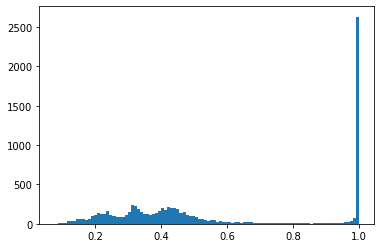

In [61]:
if __name__ == '__main__':
    main(train_df)

if CFG.epochs > 100:
    from IPython.display import clear_output  # セルの出力削除（1000epもログあると重すぎるので消す）
    clear_output()

In [62]:
#%debug

In [63]:
#=====

# Predict and submit

In [64]:
%reload_ext autoreload
%autoreload 2
from src import tta_util

In [65]:
@torch.inference_mode()  # pytorch >= 1.9
def inference(model, pth, test_loader, device, tta_transforms=None, tta_ops=[0]):
    if len(CFG.device_ids) > 1:
        model.load_state_dict(loadpth(pth))
    else:
        model.load_state_dict(torch.load(pth)['model'])
    model.eval().to(device)
    
    if len(CFG.device_ids) > 1:
        LOGGER.info(f"=> inference is_multiGPU {CFG.device_ids}")
        model = nn.DataParallel(model)  # make parallel
        cudnn.benchmark = True
    
    # ttach
    if tta_transforms is not None:
        model = tta.ClassificationTTAWrapper(model, tta_transforms)
    
    LOGGER.info(f"tta_ops: {str(tta_ops)}")
    preds = []
    preds2 = []  # for MultiOutput
    preds3 = []  # for MultiOutput2,3
    for i, (images, _, _,) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        outputs = None
        outputs2 = 0
        outputs3 = 0
        with torch.no_grad():
            
            for _ops in tta_ops:
                
                if "MultiOutput" in CFG.model_cls:
                    if (CFG.model_cls == "CustomModelMultiOutput2") or (CFG.model_cls == "CustomModelMultiOutput3"):
                        o, o2, o3 = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput2,3
                    else:
                        o, o2 = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput
                        o3 = 0
                else:
                    o = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput
                    o2, o3 = 0, 0
                
                if outputs is None:
                    outputs = o
                    outputs2 = o2
                    outputs3 = o3
                else:
                    outputs += o
                    outputs2 += o2
                    outputs3 += o3
        outputs /= len(tta_ops)
        outputs2 /= len(tta_ops)
        outputs3 /= len(tta_ops)
        
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        if "CustomModelMultiOutput" in CFG.model_cls:
            preds2.append(outputs2.argmax(1).cpu().detach().numpy())  # for MultiOutput
        if CFG.model_cls == "CustomModelMultiOutput2":
            preds3.append(outputs3.sigmoid().cpu().detach().numpy())  # for MultiOutput2
        elif CFG.model_cls == "CustomModelMultiOutput3":
            preds3.append(outputs3.argmax(1).cpu().detach().numpy())  # for MultiOutput3
    
    predictions = np.concatenate(preds)
    # for MultiOutput
    if len(preds2) == 0:
        predictions2 = None
    else:
        predictions2 = np.concatenate(preds2) 
    if len(preds3) == 0:
        predictions3 = None
    else:
        predictions3 = np.concatenate(preds3)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    #return predictions, predictions2
    return predictions, predictions2, predictions3  # for MultiOutput2,3

In [66]:
def main_test(test, pths, tta_transforms=None, transforms_type="valid", test_dataset=None, tta_ops=[0], is_cr=False):
    model = eval(CFG.model_cls)(CFG)
    if test_dataset is None:
        test_dataset = TrainDataset(test, 
                                    transforms=get_transforms(data=transforms_type),
                                    is_npy=CFG.is_npy,
                                    #add_ch_type=CFG.add_ch_type,
                                   )
    test_loader = DataLoader(test_dataset, 
                             batch_size=CFG.batch_size * 2, 
                             shuffle=False, 
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    predictions = None
    LOGGER.info(f'========== TEST ==========')  # for MultiOutput
    for i, pth in enumerate(pths):
        print("pth:", pth)
        
        #p, p2 = inference(model, pth, test_loader, device, tta_transforms, tta_ops=tta_ops)  # for MultiOutput
        p, p2, p3 = inference(model, pth, test_loader, device, tta_transforms, tta_ops=tta_ops)  # for MultiOutput2,3
        # 各foldの予測個別で持つ
        test[f'preds_fold{i}'] = p
        # for MultiOutput
        if "CustomModelMultiOutput" in CFG.model_cls:
            test[f'preds_freq_min//N_fold{i}'] = p2
            score2 = accuracy_score(test["freq_min//N"].to_numpy(), p2)
            LOGGER.info(f'freq_min//N {str(Path(pth).stem)} Accuracy: {score2:<.4f}')
            if is_cr:
                LOGGER.info(classification_report(test["freq_min//N"].to_numpy(), p2))
        if CFG.model_cls == "CustomModelMultiOutput2":
            test[f'preds_real_sim_fold{i}'] = p3
            score3 = get_score(test["real_sim"].to_numpy(), p3)
            LOGGER.info(f'real_sim {str(Path(pth).stem)} AUC: {score3:<.4f}')
        elif CFG.model_cls == "CustomModelMultiOutput3":
            test[f'preds_h0deg//10_fold{i}'] = p3
            #score3 = accuracy_score(test["h0deg//10"].to_numpy(), p3)  # testに h0deg//10 は無いのでコメントアウト
            #LOGGER.info(classification_report(test["h0deg//10"].to_numpy(), p3))  # testに h0deg//10 は無いのでコメントアウト
        
        if predictions is None:
            predictions = p
        else:
            predictions += p

    test['preds'] = predictions / len(pths)
    
    return test

In [67]:
# ttach param
# https://www.guruguru.science/competitions/17/discussions/4864ee81-6336-4cad-bb74-a4c9b46e6eb2/
tta_transforms = tta.Compose(
    [
        #tta.HorizontalFlip(),
        #tta.VerticalFlip(),
        #tta.Rotate90(angles=[0, 90, 180, 270]),  # 90度回転
        #tta.Scale(scales=[0.9, 1.1], interpolation="nearest"),  # 画像の大きさscales倍. h * scale_factor, w * scale_factor
        #tta.Add(values=[-1, 0, 1, 2]),  # 画素にfactorの値足す. x + value
        #tta.Multiply(factors=[0.9, 1, 1.1]),  # 画素をfactor倍. x * factor
        #tta.FiveCrops(crop_height=CFG.size//3, crop_width=CFG.size//3),  # 画像を5分割. crop_height: cropする画像の高さ. crop_width: cropする画像の幅
        #tta.Resize(sizes=[(224, 224), (384, 384)], original_size=(CFG.size, CFG.size), interpolation="nearest")  # 指定の大きさにリサイズ
    ]
)
tta_transforms = None

In [68]:
# ==========================================================
# valid inference
# ==========================================================
def _run_valid_tta(tta_ops):
    seed = CFG.seeds[0]
    valid = pd.read_csv(OUTPUT_DIR + f"/folds_seed{seed}.csv")

    # tta inference
    score_list = []
    pred_valid = pd.DataFrame()
    for fold in CFG.trn_fold:
        print(f"===== valid fold{fold} =====")

        # model pths
        pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_score.pth"))
        #pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_loss.pth"))
        print(pths)

        valid_f = valid[valid.fold == fold]
        print(valid_f.shape)

        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            transforms_type = 'valid_norm'
        else:
            transforms_type = 'valid'
        valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type, tta_ops=tta_ops, is_cr=False)

        ## =============================
        ## tta alb
        ## =============================
        #valid_f_tta1 = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
        #valid_f_tta1 = valid_f_tta1.rename(columns={"preds": "preds_tta1"})
        #
        #valid_f = pd.merge(valid_f, valid_f_tta1[["id", "preds_tta1"]], on="id")
        #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_tta1"].to_numpy()) / 2.0
        ## =============================

        ## =============================
        ## tta Dataset
        ## =============================
        #_test_dataset = TrainDataset(valid_f, 
        #                             transforms=get_transforms(data="valid"),
        #                             #prob_spec_start_random=1.0,
        #                             #prob_vshift=1.0,  # CV悪化
        #                             prob_swap_nega=1.0,  # CV悪化
        #                             is_npy=CFG.is_npy,
        #                             add_ch_type=CFG.add_ch_type,
        #                           )
        #valid_f_ttaD = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", test_dataset=_test_dataset)
        #valid_f_ttaD = valid_f_ttaD.rename(columns={"preds": "preds_ttaD"})
        #
        #valid_f = pd.merge(valid_f, valid_f_ttaD[["id", "preds_ttaD"]], on="id")
        #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_ttaD"].to_numpy()) / 2.0
        ## =============================

        score = get_result(valid_f, preds_col="preds", add_info=f"TTA fold{fold} ")
        score_list.append(score)
        pred_valid = pd.concat([pred_valid, valid_f])

    LOGGER.info(f"macro mean folds Score ± std: {str(round(np.mean(score_list), 4))} ± {str(round(np.std(score_list), 4))}")
    tta_oof_score = get_result(pred_valid, preds_col="preds", add_info=f"TTA oof ")
    pred_valid.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)
    display(pred_valid.head())

    #if CFG.is_wandb:
    #    # save log wandb
    #    wandb.log({f"TTA oof Score": tta_oof_score})

In [69]:
_run_valid_tta([0,1,2])
_run_valid_tta([0,1])
_run_valid_tta([0,2])
_run_valid_tta([0])

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.69it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score Accuracy: 0.1628
TTA fold0 Score: 0.8638


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.70it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score Accuracy: 0.2183
TTA fold1 Score: 0.8717


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.70it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score Accuracy: 0.2117
TTA fold2 Score: 0.8839


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.70it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score Accuracy: 0.2017
TTA fold3 Score: 0.8624


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.70it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score Accuracy: 0.2072
TTA fold4 Score: 0.8722
macro mean folds Score ± std: 0.8708 ± 0.0076
TTA oof Score: 0.8589


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.999619   
12        NaN        NaN         NaN            NaN       NaN     0.454066   
17        NaN        NaN         NaN            NaN       NaN     0.998453   
18        NaN        NaN         NaN            NaN       NaN     0.999784   
32        NaN        NaN         NaN            NaN       NaN     0.998764   

    preds_freq_min//N_fold0     preds  
5                         4  0.999619  
12                        3  0.454066  
17                        7  0.998453  
18                        1  0.999784  
32                        9  0.998764

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.49it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score Accuracy: 0.1628
TTA fold0 Score: 0.8630


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.46it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score Accuracy: 0.2178
TTA fold1 Score: 0.8703


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.50it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score Accuracy: 0.2106
TTA fold2 Score: 0.8832


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.49it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score Accuracy: 0.2044
TTA fold3 Score: 0.8631


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.49it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score Accuracy: 0.2044
TTA fold4 Score: 0.8736
macro mean folds Score ± std: 0.8706 ± 0.0075
TTA oof Score: 0.8589


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.999496   
12        NaN        NaN         NaN            NaN       NaN     0.468296   
17        NaN        NaN         NaN            NaN       NaN     0.998789   
18        NaN        NaN         NaN            NaN       NaN     0.999839   
32        NaN        NaN         NaN            NaN       NaN     0.998368   

    preds_freq_min//N_fold0     preds  
5                         4  0.999496  
12                        3  0.468296  
17                        7  0.998789  
18                        1  0.999839  
32                        9  0.998368

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.49it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score Accuracy: 0.1650
TTA fold0 Score: 0.8623


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.50it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score Accuracy: 0.2150
TTA fold1 Score: 0.8717


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.48it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score Accuracy: 0.2078
TTA fold2 Score: 0.8828


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.52it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score Accuracy: 0.1994
TTA fold3 Score: 0.8615


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.48it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score Accuracy: 0.2111
TTA fold4 Score: 0.8716
macro mean folds Score ± std: 0.87 ± 0.0077
TTA oof Score: 0.8580


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.999667   
12        NaN        NaN         NaN            NaN       NaN     0.429433   
17        NaN        NaN         NaN            NaN       NaN     0.998397   
18        NaN        NaN         NaN            NaN       NaN     0.999717   
32        NaN        NaN         NaN            NaN       NaN     0.999240   

    preds_freq_min//N_fold0     preds  
5                         4  0.999667  
12                        3  0.429433  
17                        3  0.998397  
18                        1  0.999717  
32                        9  0.999240

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.59it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score Accuracy: 0.1672
TTA fold0 Score: 0.8596


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.62it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score Accuracy: 0.2111
TTA fold1 Score: 0.8673


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.60it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score Accuracy: 0.2044
TTA fold2 Score: 0.8814


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.69it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score Accuracy: 0.2017
TTA fold3 Score: 0.8607


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth']
(1800, 40)


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.69it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score Accuracy: 0.2056
TTA fold4 Score: 0.8730
macro mean folds Score ± std: 0.8684 ± 0.0081
TTA oof Score: 0.8569


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.999491   
12        NaN        NaN         NaN            NaN       NaN     0.433021   
17        NaN        NaN         NaN            NaN       NaN     0.998983   
18        NaN        NaN         NaN            NaN       NaN     0.999793   
32        NaN        NaN         NaN            NaN       NaN     0.999186   

    preds_freq_min//N_fold0     preds  
5                         4  0.999491  
12                        3  0.433021  
17                        2  0.998983  
18                        1  0.999793  
32                        9  0.999186

In [70]:
#%debug

In [71]:
#=====

In [72]:
def _run_test_tta(tta_ops):
    if IS_MAKE_SUB:
        # model pths
        pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
        #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
        print(pths)

        # 'h0deg//10'列無いとエラーになるので入れとく
        test_df['h0deg//10'] = 0

        # ==========================================================
        # test inference
        # ==========================================================
        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            transforms_type = 'valid_norm'
        else:
            transforms_type = 'valid'
        #submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type)
        submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type, tta_ops=tta_ops)

        ## =============================
        ## tta alb
        ## =============================
        #submit_tta1 = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
        #submit_tta1 = submit_tta1.rename(columns={"preds": "preds_tta1"})
        #
        #submit = pd.merge(submit, submit_tta1[["id", "preds_tta1"]], on="id")
        #submit["preds"] = (submit["preds"].to_numpy() + submit["preds_tta1"].to_numpy()) / 2.0
        ## =============================

        submit["target"] = submit["preds"].to_numpy()
        display(submit.head())
        submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)

        submit = submit[["id", "target"]]
        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))

        # Write prediction
        submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_submission_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)
        display(submit)

        plt.hist(submit["target"], bins=100)
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:37<00:00,  1.66it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score Accuracy: 0.1580


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:37<00:00,  1.66it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score Accuracy: 0.1955


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:37<00:00,  1.67it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score Accuracy: 0.1985


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:37<00:00,  1.67it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score Accuracy: 0.1873


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:37<00:00,  1.67it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score Accuracy: 0.1937


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.346792   
1  1.248537e+09         42746.0  0.486592   
2  1.248567e+09         55878.0  0.316669   
3  1.248537e+09         48020.0  0.736063   
4  1.248543e+09         45246.0  0.499450   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.180906   
1         0          2.0    4.503615   0.799438          0     0.383495   
2         0          3.0    4.500148   0.800086          0     0.158191   
3         0          1.0    4.502120   0.799486          0     0.793651   
4         0          9.0    4.500598   0.802849          0     0.201802   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.368403                        6     0.326427   
1                        2     0.501965                        6     0.534946   
2                        3     0.323144                        7     0.315538   
3                        2     0.705904                        2     0.745497   
4                        3     0.590896                        1     0.610946   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        7     0.459114                        4     0.399110   
1                        6     0.541874                        4     0.470682   
2                        7     0.406045                        4     0.380426   
3                        2     0.733995                        2     0.701268   
4                        1     0.510128                        2     0.583480   

   preds_freq_min//N_fold4     preds  
0                        6  0.346792  
1                      

target range [0.048618, 0.999869]


id    target
0     00054c878  0.346792
1     0007285a3  0.486592
2     00076c5a6  0.316669
3     001349290  0.736063
4     001a52e92  0.499450
...         ...       ...
7970  ffbce04ef  0.992659
7971  ffc2d976b  0.380789
7972  ffc905909  0.297221
7973  ffe276f3e  0.386353
7974  fffa17f67  0.333641

[7975 rows x 2 columns]

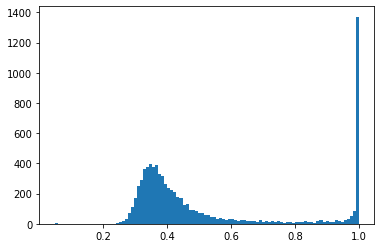

['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.48it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score Accuracy: 0.1601


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.48it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score Accuracy: 0.1992


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.48it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score Accuracy: 0.1980


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.47it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score Accuracy: 0.1853


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth


tta_ops: [0, 1]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.48it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score Accuracy: 0.1930


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.345481   
1  1.248537e+09         42746.0  0.480506   
2  1.248567e+09         55878.0  0.320500   
3  1.248537e+09         48020.0  0.728759   
4  1.248543e+09         45246.0  0.464223   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.182764   
1         0          2.0    4.503615   0.799438          0     0.371496   
2         0          3.0    4.500148   0.800086          0     0.168909   
3         0          1.0    4.502120   0.799486          0     0.751343   
4         0          9.0    4.500598   0.802849          0     0.222037   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.381774                        6     0.320579   
1                        2     0.502953                        3     0.539209   
2                        3     0.320774                        7     0.318954   
3                        2     0.714958                        2     0.768856   
4                        3     0.593111                        1     0.524711   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        7     0.444303                        4     0.397986   
1                        6     0.519885                        4     0.468989   
2                        7     0.410409                        4     0.383456   
3                        2     0.715287                        2     0.693353   
4                        1     0.493710                        2     0.487549   

   preds_freq_min//N_fold4     preds  
0                        6  0.345481  
1                      

target range [0.045805, 0.999875]


id    target
0     00054c878  0.345481
1     0007285a3  0.480506
2     00076c5a6  0.320500
3     001349290  0.728759
4     001a52e92  0.464223
...         ...       ...
7970  ffbce04ef  0.994370
7971  ffc2d976b  0.376757
7972  ffc905909  0.295048
7973  ffe276f3e  0.388504
7974  fffa17f67  0.328384

[7975 rows x 2 columns]

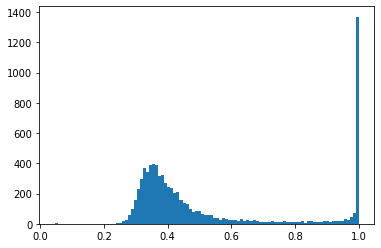

['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.49it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score Accuracy: 0.1599


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.47it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score Accuracy: 0.1944


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.48it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score Accuracy: 0.1964


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.47it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score Accuracy: 0.1860


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth


tta_ops: [0, 2]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:25<00:00,  2.47it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score Accuracy: 0.1934


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.347394   
1  1.248537e+09         42746.0  0.473020   
2  1.248567e+09         55878.0  0.314254   
3  1.248537e+09         48020.0  0.730930   
4  1.248543e+09         45246.0  0.509199   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.179066   
1         0          2.0    4.503615   0.799438          0     0.385259   
2         0          3.0    4.500148   0.800086          0     0.160154   
3         0          1.0    4.502120   0.799486          0     0.714700   
4         0          9.0    4.500598   0.802849          0     0.190294   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.367158                        6     0.326623   
1                        2     0.466077                        6     0.517110   
2                        3     0.323321                        3     0.305192   
3                        3     0.711705                        2     0.756197   
4                        3     0.608293                        2     0.632079   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        7     0.457731                        4     0.406389   
1                        6     0.536215                        4     0.460440   
2                        7     0.403484                        4     0.379120   
3                        2     0.758747                        2     0.713302   
4                        1     0.512219                        2     0.603111   

   preds_freq_min//N_fold4     preds  
0                        6  0.347394  
1                      

target range [0.046464, 0.999871]


id    target
0     00054c878  0.347394
1     0007285a3  0.473020
2     00076c5a6  0.314254
3     001349290  0.730930
4     001a52e92  0.509199
...         ...       ...
7970  ffbce04ef  0.990009
7971  ffc2d976b  0.369662
7972  ffc905909  0.298925
7973  ffe276f3e  0.382705
7974  fffa17f67  0.335744

[7975 rows x 2 columns]

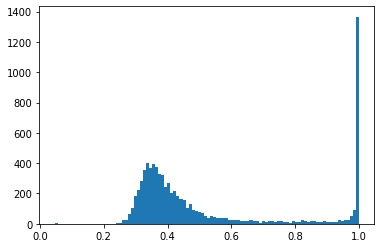

['./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth']


========== TEST ==========


valid_norm
pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:13<00:00,  4.83it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold0_seed0_best_score Accuracy: 0.1597


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:13<00:00,  4.80it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold1_seed0_best_score Accuracy: 0.1961


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:13<00:00,  4.81it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold2_seed0_best_score Accuracy: 0.1979


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:13<00:00,  4.81it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold3_seed0_best_score Accuracy: 0.1826


pth: ./output/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep/kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score.pth


tta_ops: [0]
100%|█████████████████████████████████████████████████████████████████| 63/63 [00:13<00:00,  4.79it/s]
freq_min//N kqi_3090_ex075_v2_tta_v4_norm_hvflip_lb0771_pseudo_th_5_10_100ep_fold4_seed0_best_score Accuracy: 0.1959


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.345430   
1  1.248537e+09         42746.0  0.447336   
2  1.248567e+09         55878.0  0.319697   
3  1.248537e+09         48020.0  0.700743   
4  1.248543e+09         45246.0  0.448495   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.180912   
1         0          2.0    4.503615   0.799438          0     0.363095   
2         0          3.0    4.500148   0.800086          0     0.184573   
3         0          1.0    4.502120   0.799486          0     0.501746   
4         0          9.0    4.500598   0.802849          0     0.217776   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        3     0.392770                        6     0.315172   
1                        2     0.432476                        6     0.507804   
2                        3     0.318764                        9     0.301641   
3                        3     0.734937                        2     0.808980   
4                        3     0.629708                        2     0.481577   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        7     0.426862                        4     0.411436   
1                        3     0.486436                        4     0.446869   
2                        7     0.409637                        4     0.383869   
3                        2     0.748209                        2     0.709841   
4                        1     0.481482                        2     0.431933   

   preds_freq_min//N_fold4     preds  
0                        6  0.345430  
1                      

target range [0.047761, 0.999879]


id    target
0     00054c878  0.345430
1     0007285a3  0.447336
2     00076c5a6  0.319697
3     001349290  0.700743
4     001a52e92  0.448495
...         ...       ...
7970  ffbce04ef  0.991842
7971  ffc2d976b  0.350795
7972  ffc905909  0.296181
7973  ffe276f3e  0.383283
7974  fffa17f67  0.327395

[7975 rows x 2 columns]

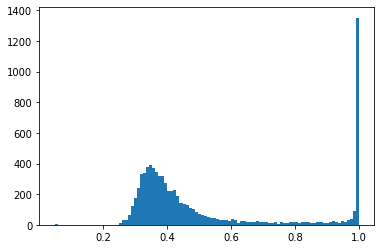

In [73]:
_run_test_tta([0,1,2])
_run_test_tta([0,1])
_run_test_tta([0,2])
_run_test_tta([0])

In [74]:
if CFG.is_wandb:
    wandb.finish()

In [75]:
## submitファイル連結
#if IS_MAKE_SUB:
#    
#    # シュミレーションデータのsubmitファイル
#    _name = CFG.name.replace("_real", "_sim")
#    sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_submission.csv'
#    
#    if os.path.isfile(sim_csv):
#        submit_real = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv')
#        submit_sim = pd.read_csv(sim_csv)
#        submit = pd.concat([submit_sim, submit_real])
#        
#        # 行の順番をtest_dfの順番にする
#        test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
#        submit = pd.merge(test_df[["id"]], submit, on="id")
#        
#        submit = submit[["id", "target"]]
#        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))
#
#        # Write prediction
#        submit.to_csv(OUTPUT_DIR + f'/{CFG.name.split("_real")[0]}_sim_real_submission.csv', index=False)
#        display(submit)
#
#        plt.hist(submit["target"], bins=100)
#        plt.show()
#        plt.clf()  # メモリ解放
#        plt.close()

# Stacking

In [76]:
#### stacking用にtest set全体で推論
#test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
#test_df["target"] = 0.5
#if cfg_is_npy:
#    test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
#else:
#    test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
#    
#if IS_MAKE_SUB:
#    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
#    
#    if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
#        transforms_type = 'valid_norm'
#    else:
#        transforms_type = 'valid'
#    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type)
#
#    submit["target"] = submit["preds"].to_numpy()
#    display(submit.head())
#    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv', index=False)

In [77]:
import joblib
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


def table_train_fn(df, feature_cols, target_col, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    lgb_params = {
            "objective": "binary",
            "learning_rate": 0.03,
            "n_estimators": 100_000,
        }
    
    Y_pred = np.zeros((len(df)))

    for i in tqdm(CFG.seeds):
        print(f"------------ seed:{i} ------------")
        set_seed(seed=i)
        folds = df.copy()

        for j in range(CFG.n_fold):
            print(f"------------ fold:{j} ------------")

            train = folds[folds["fold"] != j]
            val = folds[folds["fold"] == j]
            val_idx = val.index
            
            X_train, X_val = train[feature_cols], val[feature_cols]
            y_train, y_val = train[target_col], val[target_col]
            X_train, X_val = X_train.values, X_val.values
            y_train, y_val = y_train.values, y_val.values

            ### lgb.LGBMClassifier
            #model = lgb.LGBMClassifier(random_state=i, **lgb_params)
            #model.fit(X_train, y_train,
            #          eval_set=[(X_val, y_val)],
            #          eval_metric="error",
            #          early_stopping_rounds=100,
            #          verbose=-1,
            #         )
            
            ### RandomForestClassifier
            #model = RandomForestClassifier(random_state=i)
            #model = model.fit(X_train, y_train)
            
            ### LogisticRegression
            model = LogisticRegression(random_state=i)
            model = model.fit(X_train, y_train)
            
            pred = model.predict_proba(X_val) / len(CFG.seeds)
            Y_pred[val_idx] += pred[:,1]
            
            joblib.dump(model, out_dir + f"/model_seed_{i}_fold_{j}_{target_col}.jlb", compress=True)

    folds["pred"] = Y_pred
    print("oof score:", get_score(folds[target_col].values, folds["pred"].values))
    
    folds.to_csv(out_dir + f"/{target_col}_oof.csv", index=False)
    
    return folds

def table_test_fn(df, feature_cols, target_col, out_dir, model_paths):
    os.makedirs(out_dir, exist_ok=True)
    X = df[feature_cols]
    Y_pred = np.zeros((len(df)))
    for m_p in sorted(model_paths):
        model = joblib.load(m_p)
        
        ### LogisticRegression
        print("model.coef_:", model.coef_)
        
        pred = model.predict_proba(X) / len(model_paths)
        Y_pred += pred[:,1]
    df[target_col] = Y_pred
    df[["id", "target"]].to_csv(out_dir + f"/{target_col}_sub.csv", index=False)
    return df


#### train
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_oof_df_seed{CFG.seeds[0]}.csv'
#if os.path.isfile(sim_csv):
#    sim_oof = pd.read_csv(sim_csv)
#    real_oof = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{CFG.seeds[0]}.csv')
#    stacking_oof = pd.merge(real_oof[["id", "target", "fold", "preds"]], sim_oof[["id", "preds"]], on="id")
#    stacking_oof = stacking_oof.rename(columns={"preds_x":'real_p', "preds_y":'sim_p'})
#    #display(stacking_oof)
#    _ = table_train_fn(stacking_oof, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking")
#
#### test
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_test_all.csv'
#if os.path.isfile(sim_csv):
#    sim_sub = pd.read_csv(sim_csv)
#    real_sub = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv')
#    stacking_sub = pd.merge(real_sub[["id", "target"]], sim_sub[["id", "target"]], on="id")
#    stacking_sub = stacking_sub.rename(columns={"target_x":'real_p', "target_y":'sim_p'})
#    stacking_sub = table_test_fn(stacking_sub, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking", 
#                                 glob.glob(OUTPUT_DIR + "/stacking/*.jlb"))
#    display(stacking_sub)
#    plt.hist(stacking_sub["target"], bins=100)
#    plt.show()
#    plt.clf()  # メモリ解放
#    plt.close()